#### This code is for running the ECMWF S2S Forecast data within the ellipse calculation code.

At the end is a sample timeseries plot of these calculated elliptical metrics. 

In [1]:
##imports for relevant packages 

import datetime as dt
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cartopy.feature
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import xarray as xr
import math
import netCDF4
#from get_ellipse_metrics import get_emetrics_max_min
from fitEllipse2_new import fitEllipseContour
#from EllipseCalc import ellipse_calc
from geopy.distance import great_circle
from matplotlib.patches import Polygon
from matplotlib import cm #colormaps!
import copy
import os
import scipy.stats
import pickle
import matplotlib.ticker as mticker

In [2]:
#### Define functions first:
def point_inside_polygon(x,y,xarr,yarr):

	n = len(xarr)
	inside =False

	p1x = xarr[0]
	p1y = yarr[0]
	for i in range(n+1):
		p2x,p2y = xarr[i % n],yarr[i % n]
		if y > min(p1y,p2y):
			if y <= max(p1y,p2y):
				if x <= max(p1x,p2x):
					if p1y != p2y:
						xinters = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
					if p1x == p2x or x <= xinters:
						inside = not inside
		p1x,p1y = p2x,p2y

	return inside;

In [3]:
home_dir = '/home11/grad/2020/ef935217/Research/Prospectus/' # Define your home working directory
lev_list = [10,50] #Define your list of hPa levels
temp_lev = [850] #Define your temperature level in hPa
#contour_list = [31500,20000,23000]
contour_list = [30000,20000] #Define your list of contours relevant to hPa measures
windlat = 60.0 #Define latitude for zonal-mean winds
write_out = True #write the ellipse data to a text file, True or False 

In [4]:
##create arrays for the elliptical metrics 
rat10 = np.empty((10,47))
wind10 = np.empty((10,47))
cenlat10 = np.empty((10,47))
cenlon10 = np.empty((10,47))
size10 = np.empty((10,47))
ep10 = np.empty((10,47))
  
rat50 = np.empty((10,47))
wind50 = np.empty((10,47))
cenlat50 = np.empty((10,47))
cenlon50 = np.empty((10,47))
size50 = np.empty((10,47))
ep50 = np.empty((10,47))

In [5]:
#Start with defining desired period of record
year = 2018
month = 12
day = 26
date1 = dt.datetime(year,month,day,0)  #first date to plot
total_days = 47
first_fhr = 0
hours = total_days * 24
hr_inc = 24
times = [date1 + dt.timedelta(hours=x) for x in range(0,hours,hr_inc)]
date_list = netCDF4.date2num(times,units="hours since 1800-01-01 00:00:00",calendar="gregorian") #change dates to netcdf times

In [6]:
for plot_lev,the_contour in zip(lev_list,contour_list): #loop through each level
	print("Opening ERAI data "+str(plot_lev)+" and controur level "+str(the_contour))
	   
	ens_mem = [1,2,3,4,5,6,7,8,9,10] #indicate ensemble members
	    
	#plots_loc10 = "./POR_Images/10hPa/2018/"   ##<-- Where are you saving the plot files?
	#plots_loc30 = "./POR_Images/30hPa/2012/" 
	#plots_loc50 = "./POR_Images/50hPa/2012/" 
#	text_file = "./"+date1.strftime("%Y%m%d_%H%M")+"_"+str(plot_lev)+".txt"   ##<-- Where are you saving text files?
#	fout = open(text_file,'w')
	text_file2 = "./"+date1.strftime("%Y%m%d_%H%M")+"_temp"+str(plot_lev)+".txt"  
	fout2 = open(text_file2,'w')
        
	if plot_lev == 10:
 
		gfile = xr.open_dataset("./S2SData/ECMWF_gh_20191226.nc")
		g_files = gfile["gh"]
		tfile = xr.open_dataset("./S2SData/ECMWF_t_20191226.nc")
		t_files = tfile["t"]
		ufile = xr.open_dataset("./S2SData/ECMWF_u_20191226.nc")
		u_files = ufile["u"]


		print("Partitioning and averaging data.")
		print("First, g data")
		g_data = g_files.loc[dict(latitude=slice(90,0),level=lev_list,number=ens_mem)]
		print("u data")
		u_data = u_files.loc[dict(latitude=slice(windlat+1,windlat-1),level=lev_list,number=ens_mem)].mean(dim='longitude')
		print("t data")        
		t_data = t_files.loc[dict(latitude=slice(90,75),level=lev_list,number=ens_mem)]
		tlats = t_data['latitude'].values
		weights=np.cos(np.deg2rad(t_data.latitude))
		weights.name = "weights"

#hgt_250, lon = cutil.add_cyclic_point(data_hght.variables['Geopotential_height_isobaric'][:],coord=lon)
		print("lat and lon")
		lats_era = g_data["latitude"].values
		lons_era = g_data["longitude"].values

        
	print(f"level: {plot_lev}")
  

	for mm in range(len(ens_mem)):
		member = ens_mem[mm]        
		print("AHHHHHH "+str(mm))
		       
		rat = []
		cenlt = []
		cenln = []
		wind = []
		sz = []
		ep = []
		
		for date in date_list: #loop through each day 
			print(f"date: {date_list}")
			ind = np.where(date_list == date)[0]
			for d in ind:
				t = d
				height = g_data.loc[dict(time=times[t],level=plot_lev,number=member)]
				u = u_data.loc[dict(time=times[t],level=plot_lev,number=member)].mean(dim='latitude')
				tdata = t_data.loc[dict(time=times[t],level=plot_lev,number=member)].mean(dim='longitude')   
				#tdata2 = t2_data.loc[dict(time=times[t])]
			temp = tdata.weighted(weights).mean(dim='latitude')
        
			print("t2data")
			#print(tdata2)
			#stop
			#td2 = tdata2.values
			#for i in range(len(td2[:,1])):
			#fout2.write(str(td2[i,:])+'\n')            
           
			formatted_date = times[t].strftime("%Y%m%d")
			emark = []
			eline = []
			cs_temp = []
			#mem_list = list[range(0,30),31]
			#mem_list.append(0)
			#mem_list.append(-1)
			print("##########################")
			print(date)
			print("Date "+times[t].strftime("%H UTC %d %b %Y"))
			valid_label = (times[t].strftime("Valid: %H UTC %d %b %Y"))
			
			
			plt.Figure(figsize=(15,15),dpi=120)#figure(figsize=(12,12),dpi=1200) <---Set fig size here!

			#ax = plt.subplot(1,1,1,projection=ccrs.Orthographic(0,90))
			ax = plt.axes(projection=ccrs.Orthographic(0,90))
			ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='dimgray',facecolor='none')
			#ax.set_extent([-180,180,0,90],ccrs.PlateCarree())
			ax.outline_patch.set_edgecolor('none')
			gl = ax.gridlines(color="grey",linestyle=":",linewidth=0.5)#=lat_lon_width)

			clevs = range(18000,33500,250)
			[x,y] = np.meshgrid(lons_era,lats_era)
			#[x2,y2] = np.meshgrid(tlons_era,tlats_era)


			plt.title(str(plot_lev)+"hPa Elliptical Diagnostics\n"+valid_label)

			mem_color = "blue"
			mem_lw = 3.0
			mem_ms = 8
			cont_color = "#aec2e2"
			cont_lw = 1.0
        
			cs_temp.append(ax.contour(x,y,height,levels=clevs,linewidths=cont_lw,colors=cont_color))
		

			line_w = np.array(clevs,dtype=np.float)
			for i,c in enumerate(clevs):
				if c == the_contour:
					line_w[i] = 1.5 # Make the contour we're using for the ellipse calc fatter
				else:
					line_w[i] = 0.5
			print(clevs)

			ax.contour(x,y,height,clevs,transform=ccrs.PlateCarree(),extend='both',colors='black',linewidths=line_w)
			#ax.contour(x2,y2,tdata2, lev = [tmean], transform=ccrs.PlateCarree(),extend='both',colors='blue',linewidths=line_w)
##NEED TO INCORPORATE THE CLIMATOLOGICAL MEAN TEMP LINE AT 850 MB
			try:
				lev_contour_ind = np.where(np.array(cs_temp[-1].levels)==the_contour)[0][0]
				isoline_list = cs_temp[-1].allsegs[lev_contour_ind]
				print("in try")
				print("Number of ellipses: ",len(isoline_list))                                
			except:
				print("Contours not found for",the_contour,"meter level at",plot_lev,"hPa.")
				isoline_list = []        
        
			if len(isoline_list) > 0:
				lev_contour_ind = np.where(np.array(cs_temp[-1].levels)==the_contour)[0][0]
				isoline_list = cs_temp[-1].allsegs[lev_contour_ind]
				#print(isoline_list)
				print("in elipse ...")
				#quit()
				print("Number of ellipses: ",len(isoline_list))                                
			else:
				print("Contours not found for",the_contour,"meter level at",plot_lev,"hPa.")
				isoline_list = []

			isocount = 0
			small = 0
			ratio1 = 0
			uvalues1 = 0
			cenlat1 = 0
			cenlon1 = []
			size1 = 0
			ephi1 = 0
		        
			for isoline in isoline_list:
				#[iso_lon,iso_lat] = mm(isoline[:,0],isoline[:,1],inverse=True)
				[iso_lon,iso_lat] = [isoline[:,0],isoline[:,1]]
				if len(iso_lon)<15:
					print("-----Not analyzing ellipse with",len(iso_lon),"points, continuing...")  # Check for size!
					small = 1
					continue

				# Checking to see if contours are closed (0) or need to be joined (1)  Checking before convert lat/lon to radians
				lon_diff = abs(iso_lon[0] - iso_lon[len(iso_lon)-1])
				lat_diff = abs(iso_lat[0] - iso_lat[len(iso_lat)-1])
				join = 0
				if lon_diff > 1 or lat_diff > 1:
					join = 1
					print("Diffs lat/lon: ",lat_diff,lon_diff)
				iso_lon = np.deg2rad(iso_lon)
				iso_lat = np.deg2rad(iso_lat)

	
				## Now convert it into polar coordinates for ellipse math.
				ex = np.array((np.cos(iso_lon)*np.cos(iso_lat))/(1+np.sin(iso_lat)))
				ey = np.array((np.sin(iso_lon)*np.cos(iso_lat))/(1+np.sin(iso_lat)))

				## does this contour include the pole?
				overpole = point_inside_polygon(0,0,ex,ey)  #returns true if poly includes the pole, false if not 
				print("It is",overpole, "that the contour includes the pole")
				   
				### contours break if they don't include the pole and need to be reconnected here...
				### first check that contour doesn't include pole, there is more than one contour,... 
				###        ...the contours are not a real split vortex and we didn't get rid of one because it was small...
				if not overpole and len(isoline_list) > 1 and join > 0 and small < 1:
					if isocount > 0:
						ex = np.append(ex,ex2)
						ey = np.append(ey,ey2)
						print("Point didn't include pole - add to these to previous set")
					else:
						ex2 = ex
						ey2 = ey
						print("Point didn't include pole - keeping these to add to next set")
						isocount = 1
						continue

				print("Running ellipse diagnostic now")
				exx,eyy,eaax,ebax,ecenterx,ecentery,ephi = fitEllipseContour(ex,ey)
		
				## Convert back to lat/lon 
				elons = np.where(exx<0,np.where(eyy>0,np.arctan(eyy/exx)+math.pi,np.arctan(eyy/exx)-math.pi),np.arctan(eyy/exx))
				yysinxxlon = eyy/np.sin(elons)
				elats = -2*(np.arctan(yysinxxlon) - (math.pi/4.0))
				elats = np.rad2deg(elats)
				elons = np.rad2deg(elons)
	
				## Still not really sure what this is for...
				for g in range(1,len(elats)):
					if abs(elats[g]-elats[g-1]) > 1.5:
						elats[g] = elats[g-1]
	
				## Center points back to lat/lon
				cenlon = np.where(ecenterx<0,np.where(ecentery>0,np.arctan(ecentery/ecenterx)+math.pi,np.arctan(ecentery/ecenterx)-math.pi),np.arctan(ecentery/ecenterx))
				ysinlon = ecentery/np.sin(cenlon)
				cenlat = np.rad2deg(-2 * (np.arctan(ysinlon) - (math.pi/4.0)))
				cenlon = np.rad2deg(cenlon)
				print("Center of ellipse:",cenlat,"N",cenlon,"E")
	
				## Calculate endpoints of the axes of the vortex, convert to lat/lon
				xa = eaax * np.cos(ephi)
				ya = eaax * np.sin(ephi)
				xb = ebax * np.sin(ephi)
				yb = ebax * np.cos(ephi)
				endx = np.array([ecenterx+xa,ecenterx-xa,ecenterx+xb,ecenterx-xb])
				endy = np.array([ecentery+ya,ecentery-ya,ecentery-yb,ecentery+yb])
				endlon = np.where(endx < 0,np.where(endy>0,np.arctan(endy/endx)+math.pi,np.arctan(endy/endx)-math.pi),np.arctan(endy/endx))
				ysinelon = endy/np.sin(endlon)
				endlat = np.rad2deg(-2 *(np.arctan(ysinelon) - (math.pi/4)))
				endlon = np.rad2deg(endlon)
	
				## Calc great circle distances; (still necessary?) 
				a1gc = great_circle((endlat[0],endlon[0]),(cenlat,cenlon)).km
				a2gc = great_circle((cenlat,cenlon),(cenlat,endlat[1])).km
				b1gc = great_circle((endlat[2],endlon[2]),(cenlat,cenlon)).km
				b2gc = great_circle((cenlat,cenlon),(endlat[3],endlon[3])).km

				ephi = np.rad2deg(ephi)
				## If a1 shorter than b1, adjust phi to correct the orientation angle
				if a1gc < b1gc:
					ephi -= 90
				print("Emetrics phi:",ephi)
				if ephi < -45:
					ephi += 180
		
				ratio = a1gc/b1gc
				if ratio < 1.0:
					ratio = 1.0/ratio
				size = math.pi*a1gc*b1gc
				#estr = times[t].strftime("%H %Y%m%d%H")+" "+f'{cenlon:.3f}'+" "+f'{cenlat:.3f}'+" "+f'{a1gc:.3f}'+" "+f'{b1gc:.3f}'+" "+f'{ephi:.3f}'+" "+f'{u.values:.3f}'+" "+f'{temp.values:.3f}'
				#if write_out:
					#fout.write(estr+"\n")

				exy=np.array(list(zip(elons,elats)))
				plt.plot(elons,elats,color='red',transform=ccrs.Geodetic(),linewidth=mem_lw)
				plt.plot(cenlon,cenlat,markersize=4,marker='o',color='red',transform=ccrs.PlateCarree())
				#ax.add_patch(Polygon(exy,closed=True,color='magenta',fill=False,lw=mem_lw,transform=ccrs.PlateCarree()))
				ratio1 = ratio1+ratio
				uvalues1 = uvalues1+u.values
				cenlat1 = cenlat1+cenlat
				cenlon1.append(cenlon)
				size1 = size1+size
				ephi1 = ephi1+ephi
            
			if len(isoline_list) > 0:
				rat.append(ratio1/len(isoline_list))
				wind.append(uvalues1/len(isoline_list))
				cenlt.append(cenlat1/len(isoline_list))
				cenln.append(np.median(cenlon1))
				sz.append(size1/len(isoline_list))
				ep.append(ephi1/len(isoline_list))
            
			if len(isoline_list) == 0:
				rat.append(np.nan)
				wind.append(np.nan)
				cenlt.append(np.nan)
				cenln.append(np.nan)
				sz.append(np.nan)
				ep.append(np.nan)
            
			#print(cenlon)
			#print(cenlat)
			#print(ephi)
			print("right before savefig")
			plot_label = times[t].strftime("%Y%m%d%H")
        
			#if plot_lev == 10:
				#plt.savefig(plots_loc10+f"{plot_label}_{plot_lev}hpa.png",format='png')            
			#if plot_lev == 30:
				#plt.savefig(plots_loc30+f"{plot_label}_{plot_lev}hpa.png",format='png')
			#if plot_lev == 50:
				#plt.savefig(plots_loc50+f"{plot_label}_{plot_lev}hpa.png",format='png')
            
			#plt.savefig(plots_loc+"ellipse"+str(plot_lev)+"_"+str(fhr/6)+".png",format='png')
			print("right after savefig")
			#plt.close()
			plt.clf()
			#quit()
		
		print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
		print("Ensemble #: "+str(mm))
		print(len(rat))
		print(rat)
            
		if plot_lev == 10:
			print('lev 10')
			rat10[mm]= rat[:]
			wind10[mm]= wind[:]
			cenlat10[mm]= cenlt[:]
			cenlon10[mm]= cenln[:]
			size10[mm]= sz[:]
			ep10[mm]= ep[:]
	
		if plot_lev == 50:
			print('lev 50')
			rat50[mm]= rat[:]
			wind50[mm]= wind[:]
			cenlat50[mm]= cenlt[:]
			cenlon50[mm]= cenln[:]
			size50[mm]= sz[:]
			ep50[mm]= ep[:]


Opening ERAI data 10 and controur level 30000
Partitioning and averaging data.
First, g data
u data
t data
lat and lon
level: 10
AHHHHHH 0
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919568.0
Date 00 UTC 26 Dec 2018


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6375135344759428 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.17156261 0.0293617 ]
old angle of rotation = 41.29674494583318
old axes = [0.28736514 0.17547343]
center = [0.17156261 0.0293617 ]
angle of rotation = 41.29674494583318
axes = [0.28736514 0.17547343]
0.28736513959951804 0.1754734276008961 0.17156261323236385 0.029361703539002304 0.7207641696611163
Center of ellipse: 70.25237438692606 N 9.711670941472397 E
Emetrics phi: 41.29674494583318
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.953676464824646 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.208950712673584 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.15445532 -0.01207949]
old angle of rotation = -25.1869763204346
old axes = [0.12353668 0.36076689]
center = [ 0.15445532 -0.01207949]
angle of rotation = -25.1869763204346
axes = [0.12353668 0.36076689]
0.12353667513919137 0.3607668883166756 0.1544553152067668 -0.012079485003828841 -0.43959566541343004
Center of ellipse: 72.38670917442911 N -4.471828108003124 E
Emetrics phi: -115.1869763204346
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.689955722756366 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.08908779007436 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.19811531 0.07001498]
old angle of rotation = -16.96458402216325
old axes = [0.13475026 0.34799667]
center = [0.19811531 0.07001498]
angle of rotation = -16.96458402216325
axes = [0.13475026 0.34799667]
0.1347502645913476 0.3479966674350892 0.198115313070219 0.07001497842808346 -0.29608784741797145
Center of ellipse: 66.2669167110231 N 19.463672121251058 E
Emetrics phi: -106.96458402216325
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 19199

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.548177552006855 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  26.542649638510312 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.22083455 0.10912442]
old angle of rotation = -9.589352495439385
old axes = [0.16331591 0.29584501]
center = [0.22083455 0.10912442]
angle of rotation = 80.41064750456063
axes = [0.29584501 0.16331591]
0.29584500683181314 0.16331591409719934 0.22083455014537062 0.10912442394951274 1.403430552615145
Center of ellipse: 62.32419928834983 N 26.29607790313625 E
Emetrics phi: 80.41064750456063
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  23.024946403342774 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  24.19501583261529 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23249669 0.16128711]
old angle of rotation = -35.109651932891836
old axes = [0.29460138 0.17017948]
center = [0.23249669 0.16128711]
angle of rotation = 54.890348067108164
axes = [0.17017948 0.29460138]
0.170179483677912 0.29460138440117856 0.23249669414498217 0.16128710849546954 0.9580173013367429
Center of ellipse: 58.400864760089604 N 34.74973592898389 E
Emetrics phi: -35.10965193289183
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
-----Not analyzing ellipse with 10 points, continuing...
Diffs lat/lon:  11.77503183256826 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.19774202 0.18509401]
old angle of rotation = -14.440311981019821
old axes = [0.28621395 0.16761357]
center = [0.19774202 0.18509401]
angle of rotation = -14.440311981019821
axes = [0.28621395 0.16761357]
0.28621394628611324 0.16761357235003005 0.19774202409106292 0.1850940073944765 -0.2520309890839808
Center of ellipse: 59.68969490158123 N 43.107768262116245 E
Emetrics phi: -14.440311981019821
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.22121433 -0.29870367]
old angle of rotation = -30.3004179836587
old axes = [0.03923136 0.04635902]
center = [ 0.22121433 -0.29870367]
angle of rotation = 59.699582016341296
axes = [0.04635902 0.03923136]
0.04635902280499484 0.0

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  15.334871077959491 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  16.823560817084484 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2224117  0.20483694]
old angle of rotation = -43.776432178543104
old axes = [0.27666039 0.17867981]
center = [0.2224117  0.20483694]
angle of rotation = -43.776432178543104
axes = [0.27666039 0.17867981]
0.27666039028796374 0.17867981139901862 0.22241170414148706 0.204836939394029 -0.7640428762915714
Center of ellipse: 56.35294694878723 N 42.64448058729499 E
Emetrics phi: -43.77643217854311
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.30003577 -0.30206051]
old angle of rotation = -13.924793552798832
old axes = [0.03562577 0.06275025]
center

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  14.730306483440593 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  15.367640273065561 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.25486098 0.1741621 ]
old angle of rotation = 31.460403115498668
old axes = [0.17244632 0.33039035]
center = [0.25486098 0.1741621 ]
angle of rotation = 31.460403115498668
axes = [0.17244632 0.33039035]
0.1724463152156973 0.3303903475720668 0.2548609814334093 0.17416209951544484 0.5490876183701336
Center of ellipse: 55.69063350251068 N 34.347184789691234 E
Emetrics phi: -58.539596884501336
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919976.0
Date 00 UTC 12 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  13.13417070363721 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  12.670020711443435 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.25653843 0.15106871]
old angle of rotation = 32.26888459187399
old axes = [0.18956293 0.28624412]
center = [0.25653843 0.15106871]
angle of rotation = -57.731115408126016
axes = [0.28624412 0.18956293]
0.28624412005240735 0.18956293123161588 0.2565384255025609 0.15106870783299242 -1.007598044720629
Center of ellipse: 56.84197302246713 N 30.49270824779139 E
Emetrics phi: -57.73111540812602
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.13717153  0.24063

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.28520039 0.27771616]
old angle of rotation = -27.97071184376217
old axes = [0.21377803 0.12030075]
center = [0.28520039 0.27771616]
angle of rotation = -27.97071184376217
axes = [0.21377803 0.12030075]
0.21377802830018605 0.12030074905026791 0.2852003932046969 0.2777161612950943 -0.48818101580022366
Center of ellipse: 46.58724314899503 N 44.23827140365675 E
Emetrics phi: -27.97071184376217
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00734299  0.22794906]
old angle of rotation = 18.068923982120026
old axes = [0.33302977 0.13600597]
center = [-0.00734299  0.22794906]
angle of rotation = -71.93107601787997
axes = [0.13600597 0.33302977]
0.1360059698188173 0.3330297667646796 -0.007342992915323983 0.22794905757855383 -1.255434111014337
Center of ellipse: 64.30490371475925 N 91.84504849697397 E
Emetrics phi: -161.93107601787997
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  13.357181301037024 5.684341886080802e-14
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  11.402045979648989 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.26718232 -0.09286914]
old angle of rotation = -40.179577319813866
old axes = [0.09620109 0.12013616]
center = [ 0.26718232 -0.09286914]
angle of rotation = 49.82042268018615
axes = [0.12013616 0.09620109]
0.12013615833141218 0.09620108860240689 0.2671823168047099 -0.09286914201486934 0.8695304105045061
Center of ellipse: 58.41158601559139 N -19.166794934125278 E
Emetrics phi: 49.82042268018614
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01763463  0.23652865]
old angle of rotation = 35.04697072716

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920168.0
Date 00 UTC 20 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0881281277805499 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.09203838 0.10816246]
old angle of rotation = 44.67494599706213
old axes = [0.23677806 0.36903385]
center = [0.09203838 0.10816246]
angle of rotation = 44.67494599706213
axes = [0.23677806 0.36903385]
0.23677805524845236 0.3690338501740377 0.09203837741082178 0.108162455

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06582932532455743 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.10351047 0.06540556]
old angle of rotation = 35.62974150469386
old axes = [0.27183219 0.3847566 ]
center = [0.10351047 0.06540556]
angle of rotation = -54.37025849530614
axes = [0.3847566  0.27183219]
0.3847565950274013 0.27183218609875603 0.1035104674122029 0.06540555965891093 -0.94894002590351
Center of ellipse: 76.0385529685719 N 32.28772215113244 E
Emetrics phi: -54.37025849530614
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.13904708145967248 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.09423176 0.03817049]
old angle of rotation = 13.479423268341712
old axes = [0.30303195 0.38135415]
center = [0.09423176 0.03817049]
angle of rotation = 13.47942326834171
axes = [0.30303195 0.38135415]
0.3030319500599133 0.38135415051326493 0.09423176463851038 0.03817048983079219 0.23526031730249797
Center of ellipse: 78.38947085457208 N 22.051408038320663 E
Emetrics phi: -76.5205767316583
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920288.0
Date 00 UTC 25 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.05168167187302686 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07443911 0.0530725 ]
old angle of rotation = -5.785420241841125
old axes = [0.31957884 0.36460493]
center = [0.07443911 0.0530725 ]
angle of rotation = 84.21457975815888
axes = [0.36460493 0.31957884]
0.3646049317704462 0.3195788404595274 0.07443910544055544 0.053072498844984745 1.4698216949632423
Center of ellipse: 79.5529209152768 N 35.48755102202863 E
Emetrics phi: 84.21457975815888
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920336.0
Date 00 UTC 27 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.33327495146743047 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06965637 0.05321305]
old angle of rotation = -17.43898416238018
old axes = [0.34239398 0.36382882]
center = [0.06965637 0.05321305]
angle of rotation = 72.56101583761982
axes = [0.36382882 0.34239398]
0.36382881864824534 0.34239398327950765 0.06965637320801601 0.05321305334355038 1.266428634958217
Center of ellipse: 79.98092839966928 N 37.37753397994857 E
Emetrics phi: 72.56101583761982
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0578647144483142 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06424851 0.04339381]
old angle of rotation = -31.199782846628036
old axes = [0.33477338 0.38128836]
center = [0.06424851 0.04339381]
angle of rotation = 58.80021715337197
axes = [0.38128836 0.33477338]
0.38128836336108096 0.33477338081937313 0.06424851076431598 0.043393809994353286 1.0262573902139884
Center of ellipse: 81.13345850890626 N 34.035315760619554 E
Emetrics phi: 58.80021715337197
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.05741359983732508 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05929074 0.03990266]
old angle of rotation = -23.624480388653776
old axes = [0.31872691 0.40147581]
center = [0.05929074 0.03990266]
angle of rotation = 66.37551961134623
axes = [0.40147581 0.31872691]
0.40147581378218916 0.31872690794011665 0.05929073682144395 0.039902662984744944 1.1584713599400587
Center of ellipse: 81.82431989156983 N 33.94055176526943 E
Emetrics phi: 66.37551961134623
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920456.0
Date 00 UTC 01 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.48333254389288527 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04145673 0.02558682]
old angle of rotation = -9.15669977803877
old axes = [0.3094876  0.41594983]
center = [0.04145673 0.02558682]
angle of rotation = 80.84330022196124
axes = [0.41594983 0.3094876 ]
0.41594982500139654 0.309487603251992 0.04145672837550984 0.02558682385671286 1.4109817670514861
Center of ellipse: 84.42185342918579 N 31.682615544982458 E
Emetrics phi: 80.84330022196123
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920504.0
Date 00 UTC 03 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.10669571645954079 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02042155 0.02172963]
old angle of rotation = 6.199148231341867
old axes = [0.31494034 0.39891352]
center = [0.02042155 0.02172963]
angle of rotation = 6.199148231341867
axes = [0.31494034 0.39891352]
0.31494033808555044 0.3989135189902383 0.020421546773066825 0.02172963286086144 0.10819554745609872
Center of ellipse: 86.58392253180322 N 46.77750105397409 E
Emetrics phi: -83.80085176865813
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.08143208473157415 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02387536 0.04142654]
old angle of rotation = 39.07466424308603
old axes = [0.31415192 0.39488618]
center = [0.02387536 0.04142654]
angle of rotation = 39.07466424308603
axes = [0.31415192 0.39488618]
0.31415192352032867 0.39488617532093245 0.02387536309076358 0.04142654260519027 0.6819815451531492
Center of ellipse: 84.52507356237527 N 60.04385827219384 E
Emetrics phi: -50.92533575691397
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.14317336960352378 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05206195 0.03559052]
old angle of rotation = -25.341557163248584
old axes = [0.40092354 0.31725614]
center = [0.05206195 0.03559052]
angle of rotation = -25.341557163248584
axes = [0.40092354 0.31725614]
0.4009235434765576 0.31725614376708977 0.0520619485462877 0.035590519080278805 -0.44229361008104195
Center of ellipse: 82.78289794731539 N 34.357239864848204 E
Emetrics phi: -25.341557163248584
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.22807322944901642 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06344573 0.03282141]
old angle of rotation = -7.648192113065683
old axes = [0.37959194 0.34475036]
center = [0.06344573 0.03282141]
angle of rotation = 82.35180788693432
axes = [0.34475036 0.37959194]
0.344750358786279 0.3795919388056989 0.06344573367854853 0.03282140717140076 1.4373101925968381
Center of ellipse: 81.82831548423222 N 27.353187448940993 E
Emetrics phi: -7.648192113065676
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6778301921522001 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.17126482 0.02924353]
old angle of rotation = 41.21149895343471
old axes = [0.28711982 0.17505349]
center = [0.17126482 0.02924353]
angle of rotation = 41.21149895343471
axes = [0.28711982 0.17505349]
0.28711982315151635 0.17505349045450586 0.17126481537643334 0.029243526992077967 0.719276346419633
Center of ellipse: 70.28723907166597 N 9.689824393076044 E
Emetrics phi: 41.21149895343471
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919616.0
Date 00 UTC 28 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.42887529910193933 358.49999999999994
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.14330691 -0.01786396]
old angle of rotation = -32.047901558780524
old axes = [0.13793414 0.32053449]
center = [ 0.14330691 -0.01786396]
angle of rotation = -32.047901558780524
axes = [0.13793414 0.32053449]
0.13793413710944943 0.3205344930271881 0.1433069122103458 -0.01786395924455641 -0.5593414005557432
Center of ellipse: 73.56477008883444 N -7.105566801154723 E
Emetrics phi: -122.04790155878052
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 192019

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  28.10265123798554 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.405884533807253 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.15791824 -0.01103057]
old angle of rotation = -24.825934621277213
old axes = [0.12308798 0.36429201]
center = [ 0.15791824 -0.01103057]
angle of rotation = -24.825934621277213
axes = [0.12308798 0.36429201]
0.12308797578878229 0.3642920132009248 0.15791824244870156 -0.011030568555977463 -0.43329429902613886
Center of ellipse: 72.00910236750597 N -3.9956129252010126 E
Emetrics phi: -114.82593462127721
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.123966082833363 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  26.884149456796024 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20645907 0.07202053]
old angle of rotation = -14.84207448287355
old axes = [0.1378747  0.35143596]
center = [0.20645907 0.07202053]
angle of rotation = 75.15792551712646
axes = [0.35143596 0.1378747 ]
0.3514359634989616 0.13787470029252602 0.2064590695146223 0.0720205344991373 1.3117532592425185
Center of ellipse: 65.33164059871666 N 19.23065477356881 E
Emetrics phi: 75.15792551712646
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.5602404965409 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.908142463835404 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2337639  0.08921231]
old angle of rotation = -11.851480786332079
old axes = [0.17572681 0.28215707]
center = [0.2337639  0.08921231]
angle of rotation = 78.14851921366792
axes = [0.28215707 0.17572681]
0.282157069266844 0.17572681185321096 0.2337639044261252 0.08921231313800859 1.3639489658365553
Center of ellipse: 61.90500433953338 N 20.888567467184423 E
Emetrics phi: 78.14851921366792
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  37.82753486968078 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  38.57858794950359 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.27824007 0.0998148 ]
old angle of rotation = -23.731974755549192
old axes = [0.25266218 0.1733644 ]
center = [0.27824007 0.0998148 ]
angle of rotation = -23.731974755549196
axes = [0.25266218 0.1733644 ]
0.2526621779974663 0.17336439658693198 0.27824006992526895 0.0998147972718366 -0.4142010974845099
Center of ellipse: 57.06443269592457 N 19.734750026563912 E
Emetrics phi: -23.731974755549196
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.0532947  -0.37925728]
old angle of rotation = 39.880789626708655
old axes = [0.07706273 0.06195077]
center 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  34.742610141536645 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  35.21675794359042 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.29582172 0.0723533 ]
old angle of rotation = 43.9576117372116
old axes = [0.17177239 0.22972461]
center = [0.29582172 0.0723533 ]
angle of rotation = -46.0423882627884
axes = [0.22972461 0.17177239]
0.22972461119372403 0.17177239497307556 0.2958217234826036 0.07235329740637042 -0.8035912706672497
Center of ellipse: 56.124668785421754 N 13.743819923942882 E
Emetrics phi: -46.04238826278839
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03017281 -0.43404204]
old angle of rotation = 32.12825045231082
old axes = [0.0359408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919904.0
Date 00 UTC 09 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  34.77789537109643 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  34.854629562407055 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.32802272 0.02241452]
old angle of rotation = 4.471668415995607
old a

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  31.946855365361287 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  32.01354317848123 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.28499206 -0.05915021]
old angle of rotation = -31.245272576272722
old axes = [0.14585125 0.30427287]
center = [ 0.28499206 -0.05915021]
angle of rotation = -31.245272576272722
axes = [0.14585125 0.30427287]
0.14585124591053245 0.3042728723352352 0.28499206046282716 -0.059150214063347265 -0.5453328821390501
Center of ellipse: 57.54307098114408 N -11.725289046762134 E
Emetrics phi: -121.24527257627273
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.049617648780583 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  25.366241339474286 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.21302604 -0.02932902]
old angle of rotation = -17.240353090495915
old axes = [0.18956467 0.30375831]
center = [ 0.21302604 -0.02932902]
angle of rotation = -17.240353090495915
axes = [0.18956467 0.30375831]
0.18956466797839863 0.30375831331108083 0.2130260382546409 -0.029329024549336925 -0.3009009256355336
Center of ellipse: 65.72834673706919 N -7.83909244961959 E
Emetrics phi: -107.24035309049592
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920024.0
Date 00 UTC 14 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  16.44955654101996 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  18.007396746348476 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.27841075 0.17488467]
old angle of rotation = -40.24393937470286
old axes = [0.29939696 0.1224663 ]
center = [0.27841075 0.17488467]
angle of rotation = 49.75606062529714
axes = [0.1224663  0.29939696]
0.12246629514072342 0.2993969552471107 0.2784107511029691 0.1748846700069152 0.8684070807333437
Center of ellipse: 53.6001958271183 N 32.13512528342136 E
Emetrics phi: -40.24393937470286
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09633034 -0.28557665]

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920072.0
Date 00 UTC 16 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.1016372  -0.25612775]
old angle of rotation = 38.24419683693157
old axes = [0.18631327 0.15639541]
center = [ 0.1016372  -0.25612775]
angle of rotation = 38.24419683693157
axes = [0.18631327 0.15639541]
0.1863132693265822 0.1563954061745189 0.10163719701807702 -0.2561

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09580048 -0.23425617]
old angle of rotation = 39.71550870924186
old axes = [0.19542379 0.16343284]
center = [ 0.09580048 -0.23425617]
angle of rotation = 39.71550870924186
axes = [0.19542379 0.16343284]
0.19542379020552456 0.16343283871766798 0.09580047863298022 -0.23425616651677517 0.6931663910807537
Center of ellipse: 61.59468091025421 N -67.7575953311374 E
Emetrics phi: 39.71550870924186
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.25266219 0.24742635]
old angle of rotation = -39.91367765401934
old axes = [0.25193061 0.13026697]
center = [0.25266219 0.24742635]
angle of rotation = 50.08632234598067
axes = [0.13026697 0.25193061]
0.130266967567885 0.25193060780613524 0.2526621881919018 0.2474263509611018 0.8741712351525731
Center of ellipse: 51.0492077

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5632751401807425 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.13668801 -0.01313958]
old angle of rotation = -20.044504180765163
old axes = [0.19717486 0.36168238]
center = [ 0.13668801 -0.01313958]
angle of rotation = -20.044504180765163
axes = [0.19717486 0.36168238]
0.1971748553285826 0.36168238009014103 0.13668800710972265 -0.01313958406012384 -0.3498425948841207
Center of ellipse: 74.36230517141644 N -5.490873571976421 E
Emetrics phi: -110.04450418076516
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4220629713250261 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.10417543 -0.0018477 ]
old angle of rotation = -17.82172728340932
old axes = [0.23419622 0.37075458]
center = [ 0.10417543 -0.0018477 ]
angle of rotation = 72.17827271659067
axes = [0.37075458 0.23419622]
0.3707545757285859 0.23419621921639017 0.10417543203880453 -0.0018477040535370276 1.2597485073068992
Center of ellipse: 78.10342286271803 N -1.016118128137771 E
Emetrics phi: 72.17827271659067
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.15512372243141215 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.12210981 0.015239  ]
old angle of rotation = -9.614821369310341
old axes = [0.25618443 0.40287406]
center = [0.12210981 0.015239  ]
angle of rotation = 80.38517863068965
axes = [0.40287406 0.25618443]
0.40287405500687695 0.2561844317377605 0.12210980907837442 0.015239002326480428 1.4029860369093214
Center of ellipse: 75.96924206406659 N 7.113593751179141 E
Emetrics phi: 80.38517863068967
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.12047312 0.0033104 ]
old angle of rotation = 4.983317357301748
old axes = [0.26000916 0.39355388]
center = [0.12047312 0.0033104 ]
angle of rotation = 4.983317357301748
axes = [0.26000916 0.39355388]
0.2600091634575851 0.393553879127731 0.12047312153750035 0.0033104019586886226 0.08697529555669818
Center of ellipse: 76.25587374379629 N 1.5739971043127405 E
Emetrics phi: -85.01668264269826
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.012642223155964416 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.11884856 0.00462181]
old angle of rotation = 9.816074256111746
old axes = [0.25824036 0.39255606]
center = [0.11884856 0.00462181]
angle of rotation = -80.18392574388825
axes = [0.39255606 0.25824036]
0.39255606031082724 0.25824036412104506 0.11884855612117995 0.004621808145392675 -1.3994735114054935
Center of ellipse: 76.43439292509785 N 2.2270083870560975 E
Emetrics phi: -80.18392574388825
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2824959212467064 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.10593288 0.0476832 ]
old angle of rotation = 16.797935892864647
old axes = [0.2785945  0.42966868]
center = [0.10593288 0.0476832 ]
angle of rotation = -73.20206410713534
axes = [0.42966868 0.2785945 ]
0.42966867547899124 0.278594504159946 0.10593288003922988 0.04768319979918094 -1.277617037925475
Center of ellipse: 76.74730572122635 N 24.23377387733384 E
Emetrics phi: -73.20206410713536
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18767497392524746 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.1124236  0.05479715]
old angle of rotation = 15.645751633089342
old axes = [0.29717899 0.42234783]
center = [0.1124236  0.05479715]
angle of rotation = -74.35424836691065
axes = [0.42234783 0.29717899]
0.42234783011397387 0.29717899248531066 0.11242359872455686 0.054797145552464566 -1.2977264468482077
Center of ellipse: 75.74239060699271 N 25.98537968143607 E
Emetrics phi: -74.35424836691065
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.16440534528962303 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.10958279 0.04804742]
old angle of rotation = -11.944064781758097
old axes = [0.30312423 0.40412446]
center = [0.10958279 0.04804742]
angle of rotation = 78.0559352182419
axes = [0.40412446 0.30312423]
0.40412445536896013 0.30312422918062504 0.10958278581100159 0.04804741728777767 1.3623330702817198
Center of ellipse: 76.3536059825323 N 23.675418634159566 E
Emetrics phi: 78.0559352182419
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19205

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1824505928853739 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.0801956 -0.0036859]
old angle of rotation = -28.442251035007573
old axes = [0.28874466 0.42122541]
center = [ 0.0801956 -0.0036859]
angle of rotation = -28.442251035007573
axes = [0.28874466 0.42122541]
0.28874465693426515 0.42122540700634475 0.08019560269537293 -0.003685895477130035 -0.4964109272396471
Center of ellipse: 80.82024672984801 N -2.63153750814106 E
Emetrics phi: -118.44225103500757
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920600.0
Date 00 UTC 07 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.35940376483424075 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.04847201 -0.03362189]
old angle of rotation = -35.64304506027722
old axes = [0.28645431 0.435225  ]
center = [ 0.04847201 -0.03362189]
angle of rotation = 54.35695493972279
axes = [0.435225   0.28645431]
0.4352249977070441 0.2864543143977808 0.048472012740432495 -0.03362188987699452 0.9487078350563585
Center of ellipse: 83.24792584764013 N -34.74653505957679 E
Emetrics phi: 54.35695493972279
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192024

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.27481127362139546 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.01489716 -0.06587057]
old angle of rotation = -24.93054254108683
old axes = [0.3137194  0.40175611]
center = [ 0.01489716 -0.06587057]
angle of rotation = 65.06945745891318
axes = [0.40175611 0.3137194 ]
0.40175611211054535 0.31371940043104496 0.014897156924204936 -0.0658705731413054 1.1356762751444178
Center of ellipse: 82.27289278359748 N -77.25648085091096 E
Emetrics phi: 65.06945745891318
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919568.0
Date 00 UTC 26 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6538918080163612 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.17152603 0.02928285]
old angle of rotation = 41.19993474503066
old axes = [0.28738423 0.17531783]
center = [0.17152603 0.02928285]
angle of rotation = 41.19993474503066
axes = [0.28738423 0.17531783]
0.2873842308608174 0.17531782834660734 0.17152603145570133 0.029282853131165937 0.7190745129075955
Center of ellipse: 70.25786258257313 N 9.688111746663353 E
Emetrics phi: 41.19993474503066
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919616.0
Date 00 UTC 28 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.40566152651332743 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.1428882  -0.01802244]
old angle of rotation = -31.96482959216901
old axes = [0.1381058  0.32015675]
center = [ 0.1428882  -0.01802244]
angle of rotation = -31.96482959216901
axes = [0.1381058  0.32015675]
0.13810579533486358 0.32015675099513824 0.14288819732414837 -0.018022437637596582 -0.5578915212222655
Center of ellipse: 73.6091950160298 N -7.188735615799002 E
Emetrics phi: -121.96482959216901
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919664.0
Date 00 UTC 30 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.347921525625367 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.67548617880196 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.17939459 0.02641067]
old angle of rotation = -18.496857304396872
old axes = [0.12475005 0.3801607 ]
center = [0.17939459 0.02641067]
angle of rotation = -18.496857304396872
axes = [0.12475005 0.3801607 ]
0.12475004670739426 0.3801606968494854 0.17939459432572205 0.0264106727704864 -0.3228310612332884
Center of ellipse: 69.44465423333439 N 8.374987867714196 E
Emetrics phi: -108.49685730439687
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  24.908178863309708 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  25.61825689376932 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.21618497 0.10223084]
old angle of rotation = -5.653215746601293
old axes = [0.15855926 0.30378195]
center = [0.21618497 0.10223084]
angle of rotation = -5.653215746601293
axes = [0.15855926 0.30378195]
0.15855926371974946 0.3037819549933305 0.21618497358847802 0.10223083912587368 -0.098667228103782
Center of ellipse: 63.10192625754188 N 25.308809652774208 E
Emetrics phi: -95.65321574660129
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  21.649957220462227 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  23.872779896696997 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23637143 0.16186005]
old angle of rotation = -21.7328042191309
old axes = [0.26951758 0.17246525]
center = [0.23637143 0.16186005]
angle of rotation = -21.7328042191309
axes = [0.26951758 0.17246525]
0.2695175849079945 0.17246524672999614 0.23637143268790387 0.1618600504311551 -0.37930898931514945
Center of ellipse: 58.028224481649616 N 34.40217048474059 E
Emetrics phi: -21.7328042191309
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  27.161710732206046 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  29.660203383893666 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.22970642 0.13966659]
old angle of rotation = -14.94522548698395
old axes = [0.2832291  0.15935267]
center = [0.22970642 0.13966659]
angle of rotation = 75.05477451301606
axes = [0.15935267 0.2832291 ]
0.15935266611741658 0.283229097754064 0.22970641604646846 0.13966658560919956 1.3099529345940537
Center of ellipse: 59.90540686493257 N 31.30052729524123 E
Emetrics phi: -14.945225486983944
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.17613743 -0.32343071]
old angle of rotation = -33.60846861152024
old axes = [0.030751

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
-----Not analyzing ellipse with 10 points, continuing...
Diffs lat/lon:  17.398267783115486 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.23866322 0.15248334]
old angle of rotation = -2.3206196442112703
old axes = [0.24656516 0.1476086 ]
center = [0.23866322 0.15248334]
angle of rotation = -2.3206196442112703
axes = [0.24656516 0.1476086 ]
0.2465651564262023 0.14760859613104962 0.2386632195270048 0.15248333504489064 -0.04050245347794603
Center of ellipse: 58.37405927098125 N 32.57474858881064 E
Emetrics phi: -2.32061964421127
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.20930946 -0.32977901]
old angle of rotation = -21.98897011368469
old axes = [0.02924595 0.04848022]
center = [ 0.20930946 -0.32977901]
angle of rotation = 68.01102988631531
axes = [0.04848022 0.02924595]
0.04848021937983966 0.029

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
-----Not analyzing ellipse with 8 points, continuing...
Diffs lat/lon:  14.729873399014778 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.25512876 0.16656688]
old angle of rotation = -15.838504814728894
old axes = [0.21586698 0.17378962]
center = [0.25512876 0.16656688]
angle of rotation = 74.1614951852711
axes = [0.17378962 0.21586698]
0.17378962131652576 0.2158669775760086 0.25512876366068826 0.1665668778424454 1.2943622691849028
Center of ellipse: 56.10922622357931 N 33.13946597671802 E
Emetrics phi: -15.838504814728893
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.21843091 -0.30257667]
old angle of rotation = -36.304691711239414
old axes = [0.01553606 0.02272819]
center = [ 0.21843091 -0.30257667]
angle of rotation = 53.69530828876058
axes = [0.02272819 0.01553606]
0.022728192689384374 0.015536063497416234 0.218430911

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  20.152053459199728 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  20.92912642127201 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.28606545 0.17254583]
old angle of rotation = 28.975036532139725
old axes = [0.14918776 0.27274616]
center = [0.28606545 0.17254583]
angle of rotation = -61.024963467860275
axes = [0.27274616 0.14918776]
0.2727461576771968 0.14918776100590342 0.2860654463995772 0.17254582530687373 -1.0650865384234187
Center of ellipse: 53.053722730510785 N 31.097079848437865 E
Emetrics phi: -61.02496346786028
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.2591529 -0.2701016]
old angle of rotation = -40.319474832196875
old axes = [0.0493

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920000.0
Date 00 UTC 13 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  14.22859059656848 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  14.695103665632175 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.22874803 0.05141316]
old angle of rotation = -0.7098151854935908
old

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  12.140777359113748 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  12.609441942216847 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.13679843 0.0460791 ]
old angle of rotation = 1.9086704957590865
old axes = [0.24920003 0.30817598]
center = [0.13679843 0.0460791 ]
angle of rotation = -88.09132950424092
axes = [0.30817598 0.24920003]
0.30817597679572883 0.24920003201369817 0.13679842547908266 0.04607910319377847 -1.5374837423082282
Center of ellipse: 73.57211671128525 N 18.61555416879797 E
Emetrics phi: -88.09132950424092
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
-----Not analyzing ellipse with 5 points, continuing...
Diffs lat/lon:  5.481256168137087 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.10177442 0.22737785]
old angle of rotation = -8.739545837157284
old axes = [0.31308015 0.18389524]
center = [0.10177442 0.22737785]
angle of rotation = -8.739545837157284
axes = [0.31308015 0.18389524]
0.31308015376157633 0.18389524426097248 0.10177441722572708 0.22737784539456243 -0.15253384998735878
Center of ellipse: 62.02288710394275 N 65.88669099423397 E
Emetrics phi: -8.739545837157284
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.17022302 -0.20600954]
old angle of rotation = -43.47358125834416
old axes = [0.1119158  0.17673281]
center = [ 0.17022302 -0.20600954]
angle of rotation = 46.52641874165584
axes = [0.17673281 0.1119158 ]
0.17673281110018943 0.1119

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  42.448049487068545 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  42.66686555743644 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.14285654 0.11310047]
old angle of rotation = 13.557868486947894
old axes = [0.243565   0.36196236]
center = [0.14285654 0.11310047]
angle of rotation = -76.44213151305212
axes = [0.36196236 0.243565  ]
0.36196235666280796 0.24356500038911785 0.1428565401340445 0.11310046744935948 -1.3341668821452741
Center of ellipse: 69.34708434476524 N 38.36889229879337 E
Emetrics phi: -76.44213151305212
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.016534509108666384 358.49999999999994
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.12115491 0.0491094 ]
old angle of rotation = 4.650194174966419
old axes = [0.26809106 0.391228  ]
center = [0.12115491 0.0491094 ]
angle of rotation = -85.34980582503357
axes = [0.391228   0.26809106]
0.39122799873875724 0.26809106119092985 0.12115491487097167 0.049109398096884346 -1.4896351275846713
Center of ellipse: 75.10395909953728 N 22.064869837940574 E
Emetrics phi: -85.34980582503358
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 192038

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.19756648724759884 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.12845023 0.03698056]
old angle of rotation = 8.715191795383804
old axes = [0.29736574 0.38112041]
center = [0.12845023 0.03698056]
angle of rotation = -81.28480820461621
axes = [0.38112041 0.29736574]
0.38112041422620024 0.29736574219880557 0.1284502347212897 0.03698055937056549 -1.4186875350226533
Center of ellipse: 74.77308098640016 N 16.061001234169403 E
Emetrics phi: -81.2848082046162
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.13266207815045306 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.1232093  0.02339875]
old angle of rotation = 12.913545231597475
old axes = [0.30981436 0.37667309]
center = [0.1232093  0.02339875]
angle of rotation = -77.08645476840253
axes = [0.37667309 0.30981436]
0.3766730881057356 0.3098143621676354 0.12320929817105493 0.0233987535685662 -1.345412444398307
Center of ellipse: 75.70354585835169 N 10.753024055026337 E
Emetrics phi: -77.08645476840253
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.04933316132026988 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.09159188 0.0056352 ]
old angle of rotation = 35.0225573057519
old axes = [0.32888179 0.36304835]
center = [0.09159188 0.0056352 ]
angle of rotation = -54.9774426942481
axes = [0.36304835 0.32888179]
0.36304835387118634 0.3288817856846833 0.09159188251536779 0.005635204061807432 -0.9595373893411314
Center of ellipse: 79.51386549201652 N 3.5206934037357094 E
Emetrics phi: -54.9774426942481
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920360.0
Date 00 UTC 28 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.31786478958206743 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.04394798 -0.00347161]
old angle of rotation = -26.150116532559355
old axes = [0.35834479 0.34420164]
center = [ 0.04394798 -0.00347161]
angle of rotation = 63.84988346744066
axes = [0.34420164 0.35834479]
0.3442016398791028 0.3583447905189247 0.04394797643175613 -0.0034716139573058805 1.114390693521533
Center of ellipse: 84.95151359801542 N -4.516627505373035 E
Emetrics phi: -26.150116532559345
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06679234312318982 358.49999999999994
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03853396 -0.00025244]
old angle of rotation = 18.95895915868641
old axes = [0.34493895 0.36297733]
center = [ 0.03853396 -0.00025244]
angle of rotation = -71.04104084131359
axes = [0.36297733 0.34493895]
0.362977334675959 0.34493895393300356 0.03853396259122557 -0.00025244058135065126 -1.2399000667246847
Center of ellipse: 85.58642215194078 N -0.3753461104736059 E
Emetrics phi: -71.04104084131359
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2086921172936016 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04374429 0.00806926]
old angle of rotation = 25.85863042221129
old axes = [0.3239316  0.38637568]
center = [0.04374429 0.00806926]
angle of rotation = 25.858630422211288
axes = [0.3239316  0.38637568]
0.32393159897516466 0.38637567606952783 0.04374428871428946 0.008069260840484621 0.4513182409239584
Center of ellipse: 84.90606090522412 N 10.451539246043875 E
Emetrics phi: -64.14136957778871
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03672369274056564 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05222326 0.02346308]
old angle of rotation = 26.24561091139662
old axes = [0.32603581 0.38984703]
center = [0.05222326 0.02346308]
angle of rotation = -63.75438908860339
axes = [0.38984703 0.32603581]
0.38984703207876004 0.32603580631355666 0.052223263454232054 0.023463075955528902 -1.112724002193676
Center of ellipse: 83.44656439585233 N 24.19362009301994 E
Emetrics phi: -63.75438908860339
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920552.0
Date 00 UTC 05 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.02463303599962785 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07284887 0.0208357 ]
old angle of rotation = 10.528524567171788
old axes = [0.32586933 0.38778897]
center = [0.07284887 0.0208357 ]
angle of rotation = -79.47147543282821
axes = [0.38778897 0.32586933]
0.38778897168783616 0.3258693318625346 0.07284886523088324 0.020835695271532985 -1.387038907720638
Center of ellipse: 81.33396361662257 N 15.96119822714728 E
Emetrics phi: -79.47147543282821
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4884291057682759 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08537716 0.00716269]
old angle of rotation = 0.0190349007131791
old axes = [0.30508283 0.41452128]
center = [0.08537716 0.00716269]
angle of rotation = -89.98096509928683
axes = [0.41452128 0.30508283]
0.4145212762958942 0.3050828273260883 0.08537716334671769 0.007162693759241879 -1.5704641051046615
Center of ellipse: 80.20604603395833 N 4.79558382567726 E
Emetrics phi: -89.98096509928683
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.47915645714725486 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.08699529 -0.00565019]
old angle of rotation = -5.209780852499082
old axes = [0.29381174 0.41872461]
center = [ 0.08699529 -0.00565019]
angle of rotation = -5.209780852499082
axes = [0.29381174 0.41872461]
0.29381174303128665 0.41872460610758994 0.08699529289313876 -0.005650189080379288 -0.09092782918346605
Center of ellipse: 80.03526346099922 N -3.7160394457764134 E
Emetrics phi: -95.20978085249908
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920672.0
Date 00 UTC 10 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18260427263479073 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.08296119 -0.02412078]
old angle of rotation = -6.241567231813999
old axes = [0.27769481 0.41853785]
center = [ 0.08296119 -0.02412078]
angle of rotation = 83.75843276818601
axes = [0.41853785 0.27769481]
0.41853784884704864 0.27769480646504235 0.08296118523528478 -0.02412077555148876 1.4618604281151542
Center of ellipse: 80.12420399620011 N -16.21166892479211 E
Emetrics phi: 83.758432768186
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 2
47
[1.576324995885196, 1.9844449960299129, 2.339298959146678, 1.4549766572628686, 1.535469732966195, 1.2299757229472124, 1.0002123992972909, 0.7344946725122888, 0.7151961992332034, 0.5322931669500272, 0.976

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919592.0
Date 00 UTC 27 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.0761955193021464 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.15241236 0.00270095]
old angle of rotation = -39.82807691876443
old axes = [0.15661027 0.30423946]
center = [0.15241236 0.00270095]
angle of rotation = -39.82807691876443
axes = [0.15661027 0.30423946]
0.1566102695117519 0.3042394573576628 0.15241235764243144 0.0027009487287244782 -0.6951310769699974
Center of ellipse: 72.6655320911453 N 1.0152507871945085 E
Emetrics phi: -129.82807691876442
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.92622679835035 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.221003965601597 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.15574565 -0.01015518]
old angle of rotation = -25.031641489722873
old axes = [0.12317102 0.3595306 ]
center = [ 0.15574565 -0.01015518]
angle of rotation = -25.031641489722873
axes = [0.12317102 0.3595306 ]
0.12317101504498286 0.3595305968479897 0.1557456478721826 -0.010155179958375463 -0.4368845611744825
Center of ellipse: 72.25810412305799 N -3.730611272558329 E
Emetrics phi: -115.03164148972287
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919688.0
Date 00 UTC 31 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.56051904208133 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.058964583296785 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20415573 0.07338373]
old angle of rotation = -15.87070239632145
old axes = [0.13520104 0.33475882]
center = [0.20415573 0.07338373]
angle of rotation = 74.12929760367855
axes = [0.33475882 0.13520104]
0.33475881754606823 0.13520103936922712 0.20415572870882318 0.07338373153191458 1.2938003153749333
Center of ellipse: 65.51939263610382 N 19.770963042537254 E
Emetrics phi: 74.12929760367855
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919736.0
Date 00 UTC 02 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.04303105242826 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.02645753608779 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.24696301 0.11497973]
old angle of rotation = 11.205767902479147
old axes = [0.17981246 0.26051487]
center = [0.24696301 0.11497973]
angle of rotation = -78.79423209752086
axes = [0.26051487 0.17981246]
0.2605148719962975 0.1798124605722319 0.24696301099369547 0.11497973148200999 -1.3752187816823367
Center of ellipse: 59.522849439707265 N 24.965495878151486 E
Emetrics phi: -78.79423209752086
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919784.0
Date 00 UTC 04 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  34.39764017592354 5.684341886080802e-14
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  35.91265842872949 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.25667076 0.12187268]
old angle of rotation = -20.445980771086003
old axes = [0.28498793 0.16990556]
center = [0.25667076 0.12187268]
angle of rotation = 69.554019228914
axes = [0.16990556 0.28498793]
0.16990556119686906 0.28498793152318547 0.2566707599092656 0.12187267549523131 1.2139466435399968
Center of ellipse: 58.276568174654386 N 25.399351165548882 E
Emetrics phi: -20.445980771086
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919832.0
Date 00 UTC 06 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  43.43702869936163 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  44.226091847665195 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2337387  0.09516762]
old angle of rotation = -9.434349268291884
old axes = [0.25441678 0.17602522]
center = [0.2337387  0.09516762]
angle of rotation = -9.434349268291884
axes = [0.25441678 0.17602522]
0.2544167823256214 0.1760252161149079 0.23373870019308965 0.09516761546729496 -0.16466045751481123
Center of ellipse: 61.67204123044715 N 22.153885816540505 E
Emetrics phi: -9.434349268291884
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  40.308367813751474 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  40.84201368259601 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23865285 0.09283163]
old angle of rotation = -13.237683240890696
old axes = [0.23442678 0.17545588]
center = [0.23865285 0.09283163]
angle of rotation = -13.237683240890696
axes = [0.23442678 0.17545588]
0.23442678103874787 0.1754558753318209 0.2386528459577057 0.0928316317868439 -0.2310411578896163
Center of ellipse: 61.2735789603977 N 21.255133247338613 E
Emetrics phi: -13.237683240890696
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919904.0
Date 00 UTC 09 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.662969603269346 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  29.333219974653886 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2818192  0.12310211]
old angle of rotation = -44.62037989192722
old axes = [0.19494474 0.17996514]
center = [0.2818192  0.12310211]
angle of rotation = -44.62037989192722
axes = [0.19494474 0.17996514]
0.19494473887458524 0.17996513980065673 0.2818191963466739 0.12310210898852995 -0.7787725426048017
Center of ellipse: 55.811280124010175 N 23.596300292748946 E
Emetrics phi: -44.62037989192723
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 191971

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919952.0
Date 00 UTC 11 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  10.43610314744597 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  11.777481935994928 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.29980093 0.20348434]
old angle of rotation = 40.68999576441988
old axes = [0.13845014 0.2451897 ]
center = [0.29980093 0.20348434]
angle of rotation = 40.68999576441988
axes = [0.13845014 0.2451897 ]
0.13845013545346282 0.24518970337497623 0.29980093454873913 0.20348434283043082 0.7101743987116739
Center of ellipse: 50.165575499978374 N 34.16597452722291 E
Emetrics phi: -49.31000423558012
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920000.0
Date 00 UTC 13 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.06479884 -0.19621079]
old angle of rotation = 9.865397953122708
old axes = [0.03338101 0.02473287]
center = [ 0.06479884 -0.19621079]
angle of rotation = 9.865397953122708
axes = [0.03338101 0.02473287]
0.03338100762807987 0.024732867996939776 0.0647988438883221 -0.196210791399091 0.17218367630150044
Center 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.04501758 -0.20518547]
old angle of rotation = 14.835894986841877
old axes = [0.08112123 0.05460617]
center = [ 0.04501758 -0.20518547]
angle of rotation = 14.835894986841877
axes = [0.08112123 0.05460617]
0.08112122670223594 0.05460617468471414 0.045017582618487935 -0.2051854720645955 0.2589352150005116
Center of ellipse: 66.2732148849291 N -77.62540530279493 E
Emetrics phi: 14.835894986841879
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03510308 0.29936544]
old angle of rotation = 18.92334068590859
old axes = [0.31199198 0.1232499 ]
center = [0.03510308 0.29936544]
angle of rotation = 18.92334068590859
axes = [0.31199198 0.1232499 ]
0.3119919816654543 0.12324990468009465 0.035103079302951715 0.29936543885411865 0.33027460044570706
Center of ellipse: 56.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.08769703 -0.15824336]
old angle of rotation = 22.43770702861349
old axes = [0.15548772 0.12502358]
center = [ 0.08769703 -0.15824336]
angle of rotation = 22.43770702861349
axes = [0.15548772 0.12502358]
0.15548771640119707 0.12502358206523195 0.08769703360407712 -0.15824335919884278 0.3916118642471789
Center of ellipse: 69.49005016709944 N -61.00517762021733 E
Emetrics phi: 22.437707028613488
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.12001073  0.24655632]
old angle of rotation = -18.176156215878606
old axes = [0.14914007 0.27268279]
center = [-0.12001073  0.24655632]
angle of rotation = 71.8238437841214
axes = [0.27268279 0.14914007]
0.27268279071776563 0.14914006510772296 -0.12001073247176061 0.24655631724171034 1.2535625554709817
Center of ellipse:

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920144.0
Date 00 UTC 19 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4087471388290922 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.044724    0.04888859]
old angle of rotation = 37.185553476828346
old axes = [0.19881166 0.37625429]
center = [-0.044724    0.04888859]
angle of rotation = 37.185553476828346
axes = [0.19881166 0.37625429]
0.19881165815562088 0.37625428746032147 -0.044723995628896056 0.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.01920525277327556 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03054327  0.05598155]
old angle of rotation = 42.57561128133523
old axes = [0.2391806  0.35467902]
center = [-0.03054327  0.05598155]
angle of rotation = 42.57561128133523
axes = [0.2391806  0.35467902]
0.23918059989004795 0.35467902473420115 -0.030543268169820503 0.0559815509084864 0.7430845979085415
Center of ellipse: 82.70218774158292 N 118.61667244109329 E
Emetrics phi: -47.42438871866477
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.30436741841270276 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04440858 0.05627798]
old angle of rotation = 16.506757541461884
old axes = [0.36118221 0.27650967]
center = [0.04440858 0.05627798]
angle of rotation = -73.49324245853812
axes = [0.27650967 0.36118221]
0.276509666527683 0.3611822104124015 0.04440857830027615 0.05627797704496961 -1.2826990588679823
Center of ellipse: 81.79905981261275 N 51.72326323417899 E
Emetrics phi: -163.49324245853813
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.47953066204217976 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05769999 0.06989483]
old angle of rotation = 35.42465059458053
old axes = [0.39263346 0.27023133]
center = [0.05769999 0.06989483]
angle of rotation = 35.42465059458053
axes = [0.39263346 0.27023133]
0.3926334647760208 0.2702313280064461 0.05769998510155118 0.06989482552841049 0.6182767892439971
Center of ellipse: 79.64237446241783 N 50.45944617995992 E
Emetrics phi: 35.42465059458053
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.9160593387732376 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04667382 0.06943384]
old angle of rotation = 44.441840551312445
old axes = [0.40536228 0.26986223]
center = [0.04667382 0.06943384]
angle of rotation = 44.441840551312445
axes = [0.40536228 0.26986223]
0.4053622791871823 0.26986222971929813 0.04667382125127576 0.06943383925509469 0.7756564432667341
Center of ellipse: 80.43519703946089 N 56.09078151571455 E
Emetrics phi: 44.441840551312445
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.9657112109240771 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03735973 0.0525238 ]
old angle of rotation = 44.45819394747607
old axes = [0.40658735 0.28784447]
center = [0.03735973 0.0525238 ]
angle of rotation = 44.45819394747607
axes = [0.40658735 0.28784447]
0.40658734922315415 0.2878444697562546 0.03735973362568028 0.05252380016545599 0.7759418638736724
Center of ellipse: 82.62415763095686 N 54.57608020977536 E
Emetrics phi: 44.45819394747607
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7253504155581751 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01423632 0.03726407]
old angle of rotation = -28.98757800717865
old axes = [0.30808805 0.39533635]
center = [0.01423632 0.03726407]
angle of rotation = -28.987578007178644
axes = [0.30808805 0.39533635]
0.3080880527584741 0.39533634949608043 0.01423631637665779 0.03726407206241056 -0.5059286784039638
Center of ellipse: 85.43126212652227 N 69.0912098520305 E
Emetrics phi: -118.98757800717864
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6228009981619707 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00451078 0.03611386]
old angle of rotation = -19.818805586150617
old axes = [0.32151616 0.40030938]
center = [0.00451078 0.03611386]
angle of rotation = -19.818805586150617
axes = [0.32151616 0.40030938]
0.3215161648777444 0.4003093810872428 0.004510775437268501 0.03611386124919622 -0.34590341129097296
Center of ellipse: 85.83133985679594 N 82.88038431706084 E
Emetrics phi: -109.81880558615062
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06570278501784088 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01260568 0.02678329]
old angle of rotation = -6.215825168770159
old axes = [0.33595828 0.39441592]
center = [0.01260568 0.02678329]
angle of rotation = 83.78417483122985
axes = [0.39441592 0.33595828]
0.39441591807692894 0.33595827520974886 0.012605684907775529 0.026783286219670716 1.4623097118715251
Center of ellipse: 86.60891032120806 N 64.79574931688789 E
Emetrics phi: 83.78417483122985
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920576.0
Date 00 UTC 06 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.32123112083533556 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0311954  0.01527614]
old angle of rotation = 10.51532089340364
old axes = [0.34564833 0.39241722]
center = [0.0311954  0.01527614]
angle of rotation = -79.48467910659636
axes = [0.39241722 0.34564833]
0.39241722443379795 0.34564832502057924 0.03119540230478936 0.015276144426725143 -1.3872693553012514
Center of ellipse: 86.02127255327447 N 26.090630012768475 E
Emetrics phi: -79.48467910659636
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.09156403207727948 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0418944  0.01543258]
old angle of rotation = 14.130930535323328
old axes = [0.33694193 0.39397077]
center = [0.0418944  0.01543258]
angle of rotation = -75.86906946467667
axes = [0.39397077 0.33694193]
0.3939707729872524 0.33694192661315636 0.04189439646407423 0.015432579084336599 -1.3241650625828996
Center of ellipse: 84.88728964913776 N 20.222211932085873 E
Emetrics phi: -75.86906946467667
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.020011086783206622 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05703788 0.02963736]
old angle of rotation = 24.08819964912554
old axes = [0.33942215 0.37863702]
center = [0.05703788 0.02963736]
angle of rotation = -65.91180035087446
axes = [0.37863702 0.33942215]
0.37863701647355347 0.3394221522811023 0.05703788330415792 0.029637363334392763 -1.150377932039913
Center of ellipse: 82.64437436768519 N 27.456767448092723 E
Emetrics phi: -65.91180035087446
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919568.0
Date 00 UTC 26 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6845582689321787 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.17152322 0.02928288]
old angle of rotation = 41.17500164662108
old axes = [0.28721298 0.17538369]
center = [0.17152322 0.02928288]
angle of rotation = 41.17500164662108
axes = [0.28721298 0.17538369]
0.28721297659029 0.17538368754709266 0.17152322015593563 0.029282884393176417 0.7186393482476244
Center of ellipse: 70.25817022171145 N 9.688277674307654 E
Emetrics phi: 41.17500164662107
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 192026

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919616.0
Date 00 UTC 28 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.38259922360332865 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.14227612 -0.01758047]
old angle of rotation = -32.02085508168964
old axes = [0.13756476 0.31892623]
center = [ 0.14227612 -0.01758047]
angle of rotation = -32.02085508168964
axes = [0.13756476 0.31892623]
0.13756475694726217 0.3189262280568522 0.14227612290917507 -0.01758047201460338 -0.5588693504794421
Center of ellipse: 73.68353276172688 N -7.044096316891587 E
Emetrics phi: -122.02085508168963
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.60764547472965 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.94491838565702 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.17723632 0.02327314]
old angle of rotation = -19.539293528126187
old axes = [0.12490745 0.37830785]
center = [0.17723632 0.02327314]
angle of rotation = -19.539293528126187
axes = [0.12490745 0.37830785]
0.12490745027671604 0.37830784976649406 0.17723632485802215 0.023273137685808513 -0.3410250055794212
Center of ellipse: 69.72995988651617 N 7.480784767203666 E
Emetrics phi: -109.5392935281262
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.634205066439392 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  26.659924571229787 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.21986525 0.09814404]
old angle of rotation = -9.279325544157063
old axes = [0.15714209 0.29986866]
center = [0.21986525 0.09814404]
angle of rotation = 80.72067445584294
axes = [0.29986866 0.15714209]
0.299868664560951 0.1571420889486185 0.21986525462813644 0.09814403698583084 1.4088415436849415
Center of ellipse: 62.924490707115 N 24.05515597393201 E
Emetrics phi: 80.72067445584295
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  31.12608162536955 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  31.928192696512234 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.24214176 0.08753772]
old angle of rotation = 10.98675348586309
old axes = [0.18313842 0.27663172]
center = [0.24214176 0.08753772]
angle of rotation = -79.01324651413691
axes = [0.27663172 0.18313842]
0.27663172068283204 0.1831384204366158 0.24214176065350332 0.08753771828904561 -1.3790413043616214
Center of ellipse: 61.122316341099186 N 19.87564978456114 E
Emetrics phi: -79.01324651413691
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  41.29044166487465 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  41.78216806296143 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.24155627 0.07675344]
old angle of rotation = -34.981618595182766
old 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919832.0
Date 00 UTC 06 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  43.51677677496963 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  43.958826110717524 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23562251 0.00801276]
old an

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  44.05402623262929 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  44.200672589765254 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.22784279 -0.00714471]
old angle of rotation = 20.799162980187283
old axes = [0.20488462 0.28369007]
center = [ 0.22784279 -0.00714471]
angle of rotation = -69.20083701981271
axes = [0.28369007 0.20488462]
0.28369007277327646 0.20488461615087625 0.2278427860597158 -0.007144708761659804 -1.2077824511317123
Center of ellipse: 64.3171600524504 N -1.7960961816057246 E
Emetrics phi: -69.20083701981271
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.008195102452525305 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.21283517 -0.01552407]
old angle of rotation = 10.417992942101977
old axes = [0.21314382 0.26646491]
center = [ 0.21283517 -0.01552407]
angle of rotation = 10.417992942101977
axes = [0.21314382 0.26646491]
0.2131438220986452 0.2664649050656267 0.21283517436971053 -0.015524073368209539 0.1818282782892105
Center of ellipse: 65.90747915813259 N -4.1717330821183625 E
Emetrics phi: -79.58200705789802
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 192040

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919952.0
Date 00 UTC 11 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  46.44731602456379 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  46.01444697912703 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.21831544 -0.04735163]
old angle of rotation = 14.916806859377964
old axes = [0.22072449 0.23102992]
center = [ 0.21831544 -0.04735163]
angle of rotation = -75.08319314062203
axes = [0.23102992 0.22072449]
0.23102991600570244 0.22072448557005742 0.21831544425155536 -0.04735163023676118 -1.3104489332146763
Center of ellipse: 64.81472058089618 N -12.237643562844072 E
Emetrics phi: -165.08319314062203
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920000.0
Date 00 UTC 13 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.14968841726627602 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.14893295 -0.08118145]
old angle of rotation = 35.91007519588627
old axes = [0.27421306 0.17549113]
center = [ 0.14893295 -0.08118145]
angle of rotation = 35.91007519588627
axes = [0.27421306 0.17549113]
0.2742130576811609 0.17549112932113115 0.14893295203505302 -0.08118145069299308 0.6267490468069631
Center of ellipse: 70.74606700740004 N -28.594237406971246 E
Emetrics phi: 35.91007519588627
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192024

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920048.0
Date 00 UTC 15 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.950230464801443 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.1037825  -0.07689755]
old angle of rotation = 26.501481281576943
old axes = [0.29301736 0.16865494]
center = [ 0.1037825  -0.07689755]
angle of rotation = 26.501481281576943
axes = [0.29301736 0.16865494]
0.29301736120490574 0.1686549362354226 0.10378250459913287 -0.07689755013468699 0.46253810501916415
Center of ellipse: 75.28008570509779 N -36.53656192755317 E
Emetrics phi: 26.501481281576947
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19202

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.4550982112048132 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.05160531 -0.08205841]
old angle of rotation = -40.97561268576275
old axes = [0.27810009 0.17391557]
center = [-0.05160531 -0.08205841]
angle of rotation = -40.97561268576275
axes = [0.27810009 0.17391557]
0.27810008810875364 0.17391557463009502 -0.05160531239711375 -0.08205840692711161 -0.7151593543885165
Center of ellipse: 78.92649044987347 N -122.1651770441507 E
Emetrics phi: -40.97561268576275
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.36906446 0.15152283]
old angle of rotation = 9.014148798325294
old axes = [0.07806119 0.08865292]
center = [0.36906446 0.15152283]
angle of rotation = -80.9858512016747
axes = [0.08865292 0.07806119]
0.08865292496761891 0.07806118730989976 0.36906446244506563 0.15152282784374166 -1.4134697509994298
Cent

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.24718567246536338 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.05240359 -0.08689416]
old angle of rotation = 41.7598271378776
old axes = [0.18834283 0.28196431]
center = [-0.05240359 -0.08689416]
angle of rotation = -48.24017286212241
axes = [0.28196431 0.18834283]
0.2819643077556855 0.18834282961241378 -0.05240358947533546 -0.0868941615906102 -0.8419498481752525
Center of ellipse: 78.41173742920176 N -121.0930764975364 E
Emetrics phi: -48.24017286212241
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.357511   0.14939558]
old angle of rotation = 14.128722887586122
old axes = [0.07301013 0.10233673]
center = [0.357511   0.14939558]
angle of rotation = 14.128722887586122
axes = [0.07301013 0.10233673]
0.07301013041636498 0.10233672565958137 0.3575110011351942 0.14939557632293565 0.2465927334902585
Center 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.1796860549501531 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.04484761 -0.0744806 ]
old angle of rotation = 34.304551111837014
old axes = [0.22291807 0.28572441]
center = [-0.04484761 -0.0744806 ]
angle of rotation = -55.69544888816299
axes = [0.28572441 0.22291807]
0.2857244114838182 0.2229180749501721 -0.04484760935355614 -0.07448059658640398 -0.9720689614746593
Center of ellipse: 80.0623297405687 N -121.05375062511388 E
Emetrics phi: -55.69544888816299
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.32322461 0.18043943]
old angle of rotation = -37.198153927461995
old axes = [0.09628877 0.04784918]
center = [0.32322461 0.18043943]
angle of rotation = 52.801846072538005
axes = [0.04784918 0.09628877]
0.04784917942663586 0.09628877389246199 0.3232246115244436 0.18043942510009353

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920240.0
Date 00 UTC 23 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.27185674061794884 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04817811 0.00010879]
old angle of rotation = -43.18422757413285
old axes = [0.25673123 0.34425166]
center = [0.04817811 0.00010879]
angle of rotation = 46.81577242586716
axes = [0.34425166 0.25673123]
0.34425165521948775 0.25673123461275904 0.04817810805251498 0.000108

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.13252395686297547 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07443277 0.01278671]
old angle of rotation = -31.225411369676017
old axes = [0.26948628 0.35205951]
center = [0.07443277 0.01278671]
angle of rotation = 58.77458863032398
axes = [0.35205951 0.26948628]
0.35205951495456433 0.2694862785669923 0.07443276577749974 0.012786707234547997 1.025810088104378
Center of ellipse: 81.36208972815486 N 9.747621499835958 E
Emetrics phi: 58.77458863032399
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.13512567556863786 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.12375366 0.02497579]
old angle of rotation = -4.169723893858378
old axes = [0.26226178 0.38754502]
center = [0.12375366 0.02497579]
angle of rotation = 85.83027610614164
axes = [0.38754502 0.26226178]
0.38754502295224574 0.2622617840466078 0.12375366193387452 0.02497578994707273 1.4980209159479894
Center of ellipse: 75.60908891266202 N 11.410087451955729 E
Emetrics phi: 85.83027610614162
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920360.0
Date 00 UTC 28 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.12674876 -0.01912022]
old angle of rotation = -0.48587977006977134
old axes = [0.25522513 0.38578958]
center = [ 0.12674876 -0.01912022]
angle of rotation = -0.48587977006977134
axes = [0.25522513 0.38578958]
0.2552251310245035 0.38578957940146885 0.126748761761771 -0.019120215632006905 -0.008480201756550508
Center of ellipse: 75.39099773288142 N -8.578462296089567 E
Emetrics phi: -90.48587977006977
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 19202

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.045176901752569165 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09518897 -0.03158488]
old angle of rotation = 1.4461513302490336
old axes = [0.27711991 0.37319795]
center = [ 0.09518897 -0.03158488]
angle of rotation = -88.55384866975096
axes = [0.37319795 0.27711991]
0.3731979504615056 0.2771199061478894 0.09518896893725506 -0.03158488449218221 -1.545556224599955
Center of ellipse: 78.5456516056825 N -18.35648662279343 E
Emetrics phi: -88.55384866975096
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920456.0
Date 00 UTC 01 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0033972741419390218 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.08197955 -0.02863506]
old angle of rotation = 12.604898298003992
old axes = [0.30066884 0.35586602]
center = [ 0.08197955 -0.02863506]
angle of rotation = -77.39510170199601
axes = [0.35586602 0.30066884]
0.3558660208624237 0.3006688441314719 0.0819795526562793 -0.028635063423005022 -1.3507993496156976
Center of ellipse: 80.0741452552469 N -19.25406269284324 E
Emetrics phi: -77.39510170199601
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920504.0
Date 00 UTC 03 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18874664714838474 358.50000000000006
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.05489324 -0.0270563 ]
old angle of rotation = 21.031866320570042
old axes = [0.31058001 0.37024815]
center = [ 0.05489324 -0.0270563 ]
angle of rotation = -68.96813367942997
axes = [0.37024815 0.31058001]
0.37024814828794017 0.31058000544573394 0.05489324269350916 -0.02705630065215202 -1.2037210116616441
Center of ellipse: 82.99585241450153 N -26.238201855836753 E
Emetrics phi: -68.96813367942995
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 192019

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.19971622994383154 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.0451706  -0.00952473]
old angle of rotation = 21.72759262012055
old axes = [0.31612288 0.36823503]
center = [ 0.0451706  -0.00952473]
angle of rotation = -68.27240737987945
axes = [0.36823503 0.31612288]
0.3682350319718931 0.3161228799287231 0.04517059737524202 -0.009524725286584155 -1.1915782970417714
Center of ellipse: 84.71376275301472 N -11.907028616628489 E
Emetrics phi: -68.27240737987945
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920576.0
Date 00 UTC 06 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03168314136151906 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05092066 0.01489799]
old angle of rotation = 42.6431535841004
old axes = [0.32880854 0.35776256]
center = [0.05092066 0.01489799]
angle of rotation = -47.3568464158996
axes = [0.35776256 0.32880854]
0.3577625608017942 0.3288085410009762 0.05092065609176448 0.01489799472335395 -0.8265328933187239
Center of ellipse: 83.92600684649342 N 16.308035959832303 E
Emetrics phi: -47.3568464158996
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.013479615982546989 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07036122 0.01902087]
old angle of rotation = -26.42130207019843
old axes = [0.35368581 0.3361908 ]
center = [0.07036122 0.01902087]
angle of rotation = -26.42130207019843
axes = [0.35368581 0.3361908 ]
0.353685805967742 0.336190800132419 0.07036121634916127 0.01902087485793456 -0.4611387137889565
Center of ellipse: 81.66252441882969 N 15.127293114553453 E
Emetrics phi: -26.421302070198426
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.07848213152028904 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06923204 0.0230808 ]
old angle of rotation = 39.317163196218175
old axes = [0.32811014 0.37481133]
center = [0.06923204 0.0230808 ]
angle of rotation = -50.68283680378183
axes = [0.37481133 0.32811014]
0.37481132602212064 0.32811014225211343 0.06923203818097365 0.023080804776873628 -0.8845823764769521
Center of ellipse: 81.65212792293214 N 18.437524945281798 E
Emetrics phi: -50.68283680378183
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 4
47
[1.5748609752502336, 1.9819226811829151, 2.3395140899620777, 1.4565580616722396, 1.5257540183490796, 1.2145967478141344, 0.9297659318227282, 0.8084613337959297, 0.7198259983966122, 1.0953229294169742, 0.9727611134485988, 0.6888036696783878, 0.6419893080938565, 0.5974911

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.0239814146736421 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.15234864 0.00242136]
old angle of rotation = -39.799132428457945
old axes = [0.15725561 0.3040727 ]
center = [0.15234864 0.00242136]
angle of rotation = -39.799132428457945
axes = [0.15725561 0.3040727 ]
0.15725561197425822 0.3040726976083066 0.15234863590797643 0.0024213611193039386 -0.6946259003138376
Center of ellipse: 72.67319349595688 N 0.9105568431280343 E
Emetrics phi: -129.79913242845794
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  28.310905356707245 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.585262423450345 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.1545947  -0.01411276]
old angle of rotation = -25.26946788470969
old axes = [0.1248009  0.35877115]
center = [ 0.1545947  -0.01411276]
angle of rotation = -25.26946788470969
axes = [0.1248009  0.35877115]
0.12480089578946399 0.35877115077893257 0.15459470365449907 -0.014112756644674887 -0.441035414815151
Center of ellipse: 72.35195407520833 N -5.2160025059304385 E
Emetrics phi: -115.2694678847097
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.069826750910032 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  25.716178149779324 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.21577827 0.107327  ]
old angle of rotation = -6.910416279368615
old axes = [0.15689952 0.30427557]
center = [0.21577827 0.107327  ]
angle of rotation = 83.0895837206314
axes = [0.30427557 0.15689952]
0.3042755697234077 0.1568995166888464 0.21577827415786657 0.1073269960767965 1.450186810036498
Center of ellipse: 62.900578750569586 N 26.44551418056836 E
Emetrics phi: 83.0895837206314
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  23.96396544546851 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  24.873326742890143 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.22255655 0.12715215]
old angle of rotation = 6.661185865939679
old axes = [0.18209678 0.28349148]
center = [0.22255655 0.12715215]
angle of rotation = -83.33881413406033
axes = [0.28349148 0.18209678]
0.2834914757604934 0.18209677873974622 0.22255654988485118 0.1271521474555982 -1.4545367013469397
Center of ellipse: 61.24709513882556 N 29.74041278055789 E
Emetrics phi: -83.33881413406033
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
-----Not analyzing ellipse with 12 points, continuing...
Diffs lat/lon:  18.40909305099803 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.19364816 0.17700017]
old angle of rotation = -7.1377476583872355
old axes = [0.28031958 0.18507815]
center = [0.19364816 0.17700017]
angle of rotation = -7.1377476583872355
axes = [0.28031958 0.18507815]
0.28031957633346993 0.185078153082773 0.1936481601199207 0.177000174565008 -0.1245771978153727
Center of ellipse: 60.59923864902457 N 42.42823979899144 E
Emetrics phi: -7.1377476583872355
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 192028

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  11.320845173316371 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  13.988020600089584 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.12010662 0.17658229]
old angle of rotation = 9.760593725238289
old axes = [0.25000522 0.18480885]
center = [0.12010662 0.17658229]
angle of rotation = 9.760593725238289
axes = [0.25000522 0.18480885]
0.2500052179222129 0.1848088535813993 0.12010662458791879 0.17658229329890826 0.17035449745490688
Center of ellipse: 65.89025529921224 N 55.777494573403246 E
Emetrics phi: 9.760593725238289
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.27274503 -0.34862521]
old angle of rotation = -3.810546773602849
old axes = [0.0379215

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919880.0
Date 00 UTC 08 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5268281353003488 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06525485 0.16854745]
old angle of rotation = 44.37240067489691
old axes = [0.27627334 0.17472702]
center = [0.06525485 0.16854745]
angle of rotation = 44.37240067489691
axes = [0.27627334 0.17472702]
0.27627334176141666 0.1747270

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.544557156819991 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05405769 0.15461583]
old angle of rotation = -25.73529439811406
old axes = [0.18382371 0.26869162]
center = [0.05405769 0.15461583]
angle of rotation = -25.73529439811406
axes = [0.18382371 0.26869162]
0.18382370810615248 0.2686916162293547 0.05405769063774733 0.15461582826004922 -0.4491656212171427
Center of ellipse: 71.39585394612973 N 70.72905366530725 E
Emetrics phi: -115.73529439811406
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18528981608669426 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08462506 0.09438154]
old angle of rotation = 32.344582378691975
old axes = [0.20434902 0.26279627]
center = [0.08462506 0.09438154]
angle of rotation = -57.65541762130803
axes = [0.26279627 0.20434902]
0.26279626624998037 0.20434901523973084 0.08462506168864597 0.09438154427444216 -1.0062768691041823
Center of ellipse: 75.55090751399516 N 48.11973250441768 E
Emetrics phi: -57.65541762130803
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.545338633227388 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.11937439 0.07861697]
old angle of rotation = -42.70737123293336
old axes = [0.31540528 0.20743206]
center = [0.11937439 0.07861697]
angle of rotation = -42.70737123293336
axes = [0.31540528 0.20743206]
0.3154052786633092 0.20743206420045968 0.11937439012081502 0.07861696557046877 -0.7453842428861973
Center of ellipse: 73.73087211120894 N 33.367893357052786 E
Emetrics phi: -42.70737123293336
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920048.0
Date 00 UTC 15 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.46316688795933914 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.11099748 0.12946878]
old angle of rotation = -25.251852632042354
old axes = [0.33327786 0.22963812]
center = [0.11099748 0.12946878]
angle of rotation = -25.251852632042354
axes = [0.33327786 0.22963812]
0.33327785527808346 0.22963811963036646 0.11099748494698042 0.12946878260687478 -0.4407279706575352
Center of ellipse: 70.64419266344123 N 49.39252126569946 E
Emetrics phi: -25.251852632042354
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19202

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.8478848969200001 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.09779363 0.1773052 ]
old angle of rotation = -1.1986879024782937
old axes = [0.34257692 0.22959809]
center = [0.09779363 0.1773052 ]
angle of rotation = -1.1986879024782937
axes = [0.34257692 0.22959809]
0.34257691528799344 0.22959808805190152 0.09779363291026455 0.17730519881888482 -0.02092105060207092
Center of ellipse: 67.10630834370419 N 61.120832300747125 E
Emetrics phi: -1.1986879024782937
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  2.042729054002571 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.09725339 0.18891487]
old angle of rotation = 8.239514758416487
old axes = [0.32867192 0.23415904]
center = [0.09725339 0.18891487]
angle of rotation = 8.239514758416487
axes = [0.32867192 0.23415904]
0.32867191981303356 0.23415904062897117 0.09725339048181904 0.18891486698356044 0.14380666130103284
Center of ellipse: 66.00857518871035 N 62.760586255141604 E
Emetrics phi: 8.239514758416487
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920168.0
Date 00 UTC 20 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.1633142030045391 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.11207739 0.18144159]
old angle of rotation = 29.68303276325018
old axes = [0.26692255 0.26974721]
center = [0.11207739 0.18144159]
angle of rotation = -60.316967236749825
axes = [0.26974721 0.26692255]
0.2697472079406821 0.26692254562696394 0.11207739034677697 0.18144159106397761 -1.0527296730988305
Center of ellipse: 65.92222832801234 N 58.29616452224083 E
Emetrics phi: -150.31696723674983
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8073071370922236 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.12899111 0.14871335]
old angle of rotation = 40.49726589088746
old axes = [0.23144718 0.29735556]
center = [0.12899111 0.14871335]
angle of rotation = -49.502734109112545
axes = [0.29735556 0.23144718]
0.2973555554259264 0.2314471778131377 0.12899111441136416 0.14871334903989938 -0.8639856989433157
Center of ellipse: 67.72617901727332 N 49.06225646556819 E
Emetrics phi: -49.50273410911254
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.05464074662359053 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.16862451 0.05834761]
old angle of rotation = 18.100109366018618
old axes = [0.24182722 0.312287  ]
center = [0.16862451 0.05834761]
angle of rotation = -71.89989063398139
axes = [0.312287   0.24182722]
0.31228699823724243 0.24182721694902523 0.16862450855956915 0.05834761134628785 -1.2548898233868082
Center of ellipse: 69.76592593269737 N 19.08669168798419 E
Emetrics phi: -71.89989063398139
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.49297661306424345 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.14519761 0.05826342]
old angle of rotation = 3.977575437607179
old axes = [0.2397919  0.29564262]
center = [0.14519761 0.05826342]
angle of rotation = -86.02242456239283
axes = [0.29564262 0.2397919 ]
0.2956426165382289 0.239791896242915 0.14519760921092248 0.058263420422966825 -1.501374539162197
Center of ellipse: 72.216178220783 N 21.864102768751067 E
Emetrics phi: -86.02242456239283
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920384.0
Date 00 UTC 29 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.26782729805013616 358.49999999999994
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.15584359 0.07857354]
old angle of rotation = 4.03498031839737
old axes = [0.21057839 0.34828983]
center = [0.15584359 0.07857354]
angle of rotation = 4.03498031839737
axes = [0.21057839 0.34828983]
0.2105783850651104 0.3482898306511634 0.15584358906260568 0.07857354015522816 0.07042369180920323
Center of ellipse: 70.1996737678571 N 26.75642137118649 E
Emetrics phi: -85.96501968160263
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06972315264403761 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.19062855 0.04116214]
old angle of rotation = 22.58978053527805
old axes = [0.2164577  0.32418586]
center = [0.19062855 0.04116214]
angle of rotation = -67.41021946472196
axes = [0.32418586 0.2164577 ]
0.32418585837292 0.21645769887969007 0.19062854511660182 0.04116214260784429 -1.1765302791513677
Center of ellipse: 67.9291579487622 N 12.184721062985655 E
Emetrics phi: -67.41021946472196
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0662544911719678 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.20091692 0.00303114]
old angle of rotation = -41.99382643447672
old axes = [0.27893331 0.22019665]
center = [0.20091692 0.00303114]
angle of rotation = -41.99382643447672
axes = [0.27893331 0.22019665]
0.2789333076450448 0.22019665111815245 0.20091691527501676 0.0030311448355414966 -0.7329305367926496
Center of ellipse: 67.27660502953387 N 0.8643305695964861 E
Emetrics phi: -41.99382643447672
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920528.0
Date 00 UTC 04 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  44.313278709307696 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  44.2476214036102 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.20071831 -0.00320737]
old angle of rotation = -0.229931533918935
old axes = [0.20084276 0.27936334]
center = [ 0.20071831 -0.00320737]
angle of rotation = 89.77006846608107
axes = [0.27936334 0.20084276]
0.2793633435900713 0.20084276217804162 0.20071831082203487 -0.0032073713761600533 1.5667832644738502
Center of ellipse: 67.29817688982489 N -0.9154780321030351 E
Emetrics phi: 89.77006846608107
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920576.0
Date 00 UTC 06 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  42.560118647637296 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  42.70059079508944 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20329009 0.04512302]
old angle of rotation = 22.70892189083918
old axes = [0.19230018 0.27771066]
center = [0.20329009 0.04512302]
angle of rotation = -67.29107810916082
axes = [0.27771066 0.19230018]
0.27771066223648905 0.19230017803291863 0.2032900880999742 0.04512301890425532 -1.1744508702215366
Center of ellipse: 66.47392339340632 N 12.514691421918611 E
Emetrics phi: -67.29107810916082
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920624.0
Date 00 UTC 08 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  42.20061415962789 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  42.581406189910496 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20755735 0.0897178 ]
old angle of rotation = 44.991322634743504
old axes = [0.20307975 0.23880944]
center = [0.20755735 0.0897178 ]
angle of rotation = -45.008677365256496
axes = [0.23880944 0.20307975]
0.23880944369373855 0.2030797508204714 0.20755735244624407 0.08971779679354089 -0.7855496119915724
Center of ellipse: 64.51732507513508 N 23.37667765715859 E
Emetrics phi: -45.0086773652565
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1934698594178883 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.20952686 0.0159123 ]
old angle of rotation = 12.030435885554963
old axes = [0.23160814 0.19477383]
center = [0.20952686 0.0159123 ]
angle of rotation = 12.030435885554963
axes = [0.23160814 0.19477383]
0.2316081376407948 0.19477382829264855 0.20952685719631578 0.015912295684196734 0.20997071665301384
Center of ellipse: 66.26615141719215 N 4.342930952290056 E
Emetrics phi: 12.030435885554963
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 5
47
[1.5773877007676906, 1.9817117185198847, 2.3469907814359376, 1.4368813078252802, 1.5486231949122198, 1.2758877201592624, 0.9436313171668884, 0.7557365453887889, 0.48650255824929795, 0.6924805095798302, 0.0, 0.9242258284272126, 1.3957431058829375, 1.47836911778625, 1.501830

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919592.0
Date 00 UTC 27 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.9943555792221233 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.15253759 0.00235127]
old angle of rotation = -39.83265901190217
old axes = [0.15717652 0.30437273]
center = [0.15253759 0.00235127]
angle of rotation = -39.83265901190217
axes = [0.15717652 0.30437273]
0.15717651568342458 0.3043727288489727 0.15253759099253372 0.002351265316150472 -0.6952110495818841
Center of ellipse: 72.65215817094419 N 0.8831063219727419 E
Emetrics phi: -129.83265901190217
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  28.022884729773217 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.291939653504343 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.15614829 -0.01010666]
old angle of rotation = -25.28138963879898
old axes = [0.12246712 0.36147322]
center = [ 0.15614829 -0.01010666]
angle of rotation = -25.28138963879898
axes = [0.12246712 0.36147322]
0.12246712087268459 0.3614732248127724 0.15614828678336967 -0.010106663841640738 -0.44124348867662216
Center of ellipse: 72.21351160967134 N -3.70329121426092 E
Emetrics phi: -115.28138963879898
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919688.0
Date 00 UTC 31 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.38922028797444 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  26.944551670360028 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20957848 0.07774682]
old angle of rotation = -15.456179450976299
old axes = [0.13987541 0.33708793]
center = [0.20957848 0.07774682]
angle of rotation = 74.5438205490237
axes = [0.33708793 0.13987541]
0.3370879266320198 0.13987540908790166 0.20957847511805747 0.07774681573040931 1.3010351055962708
Center of ellipse: 64.79911723939995 N 20.353220029957455 E
Emetrics phi: 74.5438205490237
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  28.24434804499692 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  29.498650324991857 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.24649679 0.14302846]
old angle of rotation = -32.56715308318908
old axes = [0.28523474 0.17002843]
center = [0.24649679 0.14302846]
angle of rotation = -32.56715308318908
axes = [0.28523474 0.17002843]
0.2852347432519214 0.17002842813114663 0.24649678711254425 0.1430284623493292 -0.5684040493026723
Center of ellipse: 58.18623358676759 N 30.12422451690549 E
Emetrics phi: -32.56715308318908
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.551191527497153 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  30.237904879128983 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20073994 0.13974972]
old angle of rotation = -9.475162516464309
old axes = [0.31006081 0.15181576]
center = [0.20073994 0.13974972]
angle of rotation = -9.475162516464307
axes = [0.31006081 0.15181576]
0.31006080759749644 0.15181575588859714 0.2007399427578088 0.13974971573084757 -0.16537278307385359
Center of ellipse: 62.5112299275137 N 34.84459136093763 E
Emetrics phi: -9.475162516464307
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  5.779865295994327 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.17680924 0.15311708]
old angle of rotation = 2.1547735214544246
old axes = [0.32656127 0.14201314]
center = [0.17680924 0.15311708]
angle of rotation = 2.1547735214544246
axes = [0.32656127 0.14201314]
0.3265612657185336 0.14201313610086203 0.17680924130781278 0.15311707921626375 0.03760789258417238
Center of ellipse: 63.67104548791393 N 40.892614061808146 E
Emetrics phi: 2.1547735214544246
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919904.0
Date 00 UTC 09 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.21546923 0.16822444]
old angle of rotation = 15.205321901179657
old axes = [0.27912338 0.16504387]
center = [0.21546923 0.16822444]
angle of rotation = 15.20532190117966
axes = [0.27912338 0.16504387]
0.279123377355663 0.16504386536192406 0.2154692281006205 0.1682244433795173 0.2653829310011889
Center of ellipse: 59.42213921542361 N 37.9804168193097 E
Emetrics phi: 15.20532190117966
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


1919952.0
Date 00 UTC 11 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  17.551475707476826 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  20.1668877060995 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.24094459 0.19958905]
old angle of rotation = 30.573196623458077
old axes = [0.18408839 0.23838431]
center = [0.24094459 0.19958905]
angle of rotation = -59.426803376541926
axes = [0.23838431 0.18408839]
0.23838431022491008 0.18408838650491685 0.2409445935655325 0.1995890541841227 -1.03719338285594
Center of ellipse: 55.25291926459307 N 39.63701832693173 E
Emetrics phi: -59.426803376541926
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  16.356036672498668 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  18.269976397957706 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23775014 0.20874988]
old angle of rotation = 43.61730178589869
old axes = [0.16034437 0.28443143]
center = [0.23775014 0.20874988]
angle of rotation = 43.61730178589869
axes = [0.16034437 0.28443143]
0.16034437252235256 0.2844314297274368 0.23775014477934164 0.20874988079411924 0.761265526999935
Center of ellipse: 54.886461617639064 N 41.2838476136899 E
Emetrics phi: -46.3826982141013
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 19199

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.22757219 0.22856742]
old angle of rotation = -29.27544617590925
old axes = [0.30753342 0.14311617]
center = [0.22757219 0.22856742]
angle of rotation = -29.27544617590925
axes = [0.30753342 0.14311617]
0.30753341522779304 0.14311616870995483 0.22757219103330273 0.22856741819444784 -0.5109529257599994
Center of ellipse: 54.24680693503082 N 45.12501046686794 E
Emetrics phi: -29.275446175909245
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 192052

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.16547601 0.25335785]
old angle of rotation = -18.005338442038298
old axes = [0.28336457 0.15654383]
center = [0.16547601 0.25335785]
angle of rotation = -18.005338442038298
axes = [0.28336457 0.15654383]
0.28336457128211323 0.1565438263560996 0.1654760061690856 0.2533578453425967 -0.3142524387494745
Center of ellipse: 56.32737308104102 N 56.85017896873117 E
Emetrics phi: -18.005338442038298
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920120.0
Date 00 UTC 18 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.14704249 0.23329644]
old angle of rotation = -32.31103841541334
old axes = [0.25787897 0.17272837]
center = [0.14704249 0.23329644]
angle of rotation = -32.31103841541334
axes = [0.25787897 0.17272837]
0.2578789705715136 0.17272837297396626 0.14704249212058354 0.2332964353753373 -0.5639340050873342
Center of 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.16015488 0.21794612]
old angle of rotation = -35.213406201293616
old axes = [0.27922559 0.17278692]
center = [0.16015488 0.21794612]
angle of rotation = -35.213406201293616
axes = [0.27922559 0.17278692]
0.2792255885229705 0.17278692419904307 0.16015487906542467 0.21794612221977894 -0.6145898790547627
Center of ellipse: 59.731431622284084 N 53.6901768252605 E
Emetrics phi: -35.213406201293616
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.06821407 -0.29992727]
old angle of rotation = 11.113199807742285
old axes = [0.14278053 0.07394794]
center = [ 0.06821407 -0.29992727]
angle of rotation = 11.113199807742289
axes = [0.14278053 0.07394794]
0.14278053092727028 0.07394793520505737 0.06821407446520546 -0.29992726859357055 0.19396192707710375
Center of ellipse: 55.80560628600632 N -77

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  28.68197317649502 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  29.862920500505297 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.22364828 0.16787148]
old angle of rotation = -38.8263423137085
old axes = [0.32006301 0.17386386]
center = [0.22364828 0.16787148]
angle of rotation = -38.8263423137085
axes = [0.32006301 0.17386386]
0.3200630113888584 0.17386386208893262 0.22364828371049383 0.16787148060898552 -0.6776475098806064
Center of ellipse: 58.753601243084375 N 36.89206967604258 E
Emetrics phi: -38.8263423137085
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.07846885 -0.277755  ]
old angle of rotation = 9.53146136184033
old axes = [0.15183232 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  34.46917900516567 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  35.2370083940315 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.13760175 0.03073675]
old angle of rotation = -9.002188044534012
old axes = [0.22606093 0.34945894]
center = [0.13760175 0.03073675]
angle of rotation = 80.99781195546598
axes = [0.34945894 0.22606093]
0.34945893923564286 0.22606093050208553 0.1376017481466771 0.030736745607338634 1.4136785055341081
Center of ellipse: 73.94920735493591 N 12.591715620190428 E
Emetrics phi: 80.99781195546599
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  38.28833482765754 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  38.46615814463695 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.12210985 0.0330792 ]
old angle of rotation = -4.6691697269355075
old axes = [0.23075316 0.36576616]
center = [0.12210985 0.0330792 ]
angle of rotation = 85.33083027306449
axes = [0.36576616 0.23075316]
0.36576615951873215 0.2307531646721331 0.12210985202043581 0.03307920030996343 1.4893039417254275
Center of ellipse: 75.57950781374747 N 15.157469919155714 E
Emetrics phi: 85.33083027306449
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 191990

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920360.0
Date 00 UTC 28 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  37.14500630505107 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  37.402987136746766 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.12811854 0.04448184]
old angle of rotation = 2.4405882708537114
old axes = [0.22698772 0.3681304 ]
center = [0.12811854 0.04448184]
angle of rotation = -87.55941172914629
axes = [0.3681304  0.22698772]
0.36813039720067164 0.22698772474108642 0.12811853726029446 0.04448183832590368 -1.5282000257829442
Center of ellipse: 74.55324833280613 N 19.14663490264558 E
Emetrics phi: -87.55941172914629
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920408.0
Date 00 UTC 30 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  33.90970342701422 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  34.60194171799371 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.14382187 0.04585032]
old angle of rotation = 1.14766407521227
old axes = [0.22239974 0.37134168]
center = [0.14382187 0.04585032]
angle of rotation = 1.1476640752122698
axes = [0.22239974 0.37134168]
0.2223997366334644 0.3713416812926924 0.1438218745987161 0.04585031720210813 0.020030516819309948
Center of ellipse: 72.83161610532375 N 17.682246639043896 E
Emetrics phi: -88.85233592478772
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  36.576592388675174 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  37.1355648307618 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.15054072 0.0340832 ]
old angle of rotation = -2.804893398445697
old axes = [0.22550237 0.36336414]
center = [0.15054072 0.0340832 ]
angle of rotation = -2.804893398445697
axes = [0.22550237 0.36336414]
0.22550237098626322 0.3633641449306578 0.150540724026074 0.034083202080884806 -0.04895462497033062
Center of ellipse: 72.45118690397085 N 12.756992664844313 E
Emetrics phi: -92.8048933984457
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 19199

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920480.0
Date 00 UTC 02 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  41.23078549592512 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  41.516556833324366 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.11916093 -0.03515047]
old angle of rotation = -17.206012785491186
old axes = [0.24732394 0.32503845]
center = [ 0.11916093 -0.03515047]
angle of rotation = 72.7939872145088
axes = [0.32503845 0.24732394]
0.32503845127458686 0.2473239444753043 0.1191609276193186 -0.03515047468004009 1.2704947525478345
Center of ellipse: 75.8360407243878 N -16.435175011485345 E
Emetrics phi: 72.79398721450882
-----Not analyzing ellipse with 5 points, continuing...
right before savefig
right after savefig
date: [19195

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920528.0
Date 00 UTC 04 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.058446820842803504 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.06234621 -0.05007301]
old angle of rotation = -18.592658765118692
old axes = [0.33348053 0.36667834]
center = [ 0.06234621 -0.05007301]
angle of rotation = -18.592658765118692
axes = [0.33348053 0.36667834]
0.3334805325147527 0.36667833622371737 0.0623462104471617 -0.050073008515032186 -0.3245031121511042
Center of ellipse: 80.85617479007195 N -38.76949334649921 E
Emetrics phi: -108.5926587651187
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.23751418321865003 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03133441 -0.03829288]
old angle of rotation = -0.8653546224690474
old axes = [0.33335378 0.38449173]
center = [ 0.03133441 -0.03829288]
angle of rotation = -0.8653546224690474
axes = [0.33335378 0.38449173]
0.3333537787109096 0.3844917321439998 0.031334413183674886 -0.03829288026002485 -0.015103287359437379
Center of ellipse: 84.33472282238772 N -50.70712045456945 E
Emetrics phi: -90.86535462246904
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.00491792755552467 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.01838145 -0.00474039]
old angle of rotation = 25.476926452786465
old axes = [0.32297869 0.40436785]
center = [ 0.01838145 -0.00474039]
angle of rotation = -64.52307354721353
axes = [0.40436785 0.32297869]
0.4043678463923208 0.32297868711516675 0.018381450627298332 -0.004740388456460136 -1.1261400769053331
Center of ellipse: 87.8249855985192 N -14.460907756770752 E
Emetrics phi: -64.52307354721354
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920672.0
Date 00 UTC 10 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.10385169186464793 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0359647  0.01136205]
old angle of rotation = 39.49031089814
old axes = [0.32360862 0.39737965]
center = [0.0359647  0.01136205]
angle of rotation = -50.509689101860005
axes = [0.39737965 0.32360862]
0.3973796539804284 0.3236086212855453 0.03596469898223857 0.01136205369304481 -0.8815603789861546
Center of ellipse: 85.68002254984175 N 17.532493125643942 E
Emetrics phi: -50.509689101860005
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 6
47
[1.5750212190842108, 1.984687438426992, 2.3496223251749457, 1.475956756473445, 1.5320194899843098, 1.1537745842170115, 0.8378139315121486, 0.6873172089001918, 0.7676910607532096, 0.9236704816297623, 0.930178

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.9983350128174138 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.15233162 0.00332822]
old angle of rotation = -39.93257048305225
old axes = [0.15659447 0.30273544]
center = [0.15233162 0.00332822]
angle of rotation = -39.93257048305225
axes = [0.15659447 0.30273544]
0.15659446621696022 0.30273544055199764 0.15233161961558273 0.0033282153590880603 -0.6969548337139643
Center of ellipse: 72.67318265478332 N 1.2516269423547894 E
Emetrics phi: -129.93257048305225
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919640.0
Date 00 UTC 29 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  28.119137590459715 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.403246291146225 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.15508549 -0.01110029]
old angle of rotation = -25.165140306701268
old axes = [0.1229546  0.35995062]
center = [ 0.15508549 -0.01110029]
angle of rotation = -25.16514030670126
axes = [0.1229546  0.35995062]
0.12295460078837273 0.3599506228838414 0.15508548832080188 -0.011100287463150373 -0.4392145550782727
Center of ellipse: 72.3245745044953 N -4.093979883903129 E
Emetrics phi: -115.16514030670126
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.358581468980496 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.74905458000793 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.17882708 0.03052445]
old angle of rotation = -19.249483583521034
old axes = [0.12489883 0.37803985]
center = [0.17882708 0.03052445]
angle of rotation = -19.249483583521034
axes = [0.12489883 0.37803985]
0.12489883067452835 0.378039854247508 0.17882708457653873 0.03052445444443986 -0.3359668678410389
Center of ellipse: 69.43519622304218 N 9.686607591670363 E
Emetrics phi: -109.24948358352103
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919712.0
Date 00 UTC 01 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.605276694007188 5.684341886080802e-14
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.279287139839653 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2224794  0.11088883]
old angle of rotation = -4.562284652001809
old axes = [0.16422292 0.29007128]
center = [0.2224794  0.11088883]
angle of rotation = 85.43771534799818
axes = [0.29007128 0.16422292]
0.2900712754709237 0.1642229217746512 0.22247940066098817 0.1108888328111306 1.4911694382042613
Center of ellipse: 62.08040837799006 N 26.49271762337342 E
Emetrics phi: 85.43771534799819
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  29.70060129857243 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  30.68608205285559 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2551121  0.12653675]
old angle of rotation = -40.804312462561434
old axes = [0.27845139 0.17177152]
center = [0.2551121  0.12653675]
angle of rotation = -40.804312462561434
axes = [0.27845139 0.17177152]
0.27845138696249716 0.171771521202495 0.2551120955741556 0.12653674664815026 -0.7121696014842525
Center of ellipse: 58.20931529088771 N 26.38161827372453 E
Emetrics phi: -40.804312462561434
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  36.0420554065076 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  37.047177488067064 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.24662207 0.11428925]
old angle of rotation = -16.711741674863195
old axes = [0.31056245 0.15795855]
center = [0.24662207 0.11428925]
angle of rotation = -16.711741674863195
axes = [0.31056245 0.15795855]
0.31056245239505953 0.1579585475991387 0.24662207377899206 0.11428924550170766 -0.29167491596911443
Center of ellipse: 59.58687365477491 N 24.863881588966322 E
Emetrics phi: -16.711741674863195
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 19197

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919856.0
Date 00 UTC 07 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  37.0908677668443 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  38.154736898318006 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.21523719 0.11663696]
old angle of rotation = -2.388040206568803
old axes = [0.24923677 0.17405536]
center = [0.21523719 0.11663696]
angle of rotation = 87.6119597934312
axes = [0.17405536 0.24923677]
0.17405535810222983 0.24923676825191055 0.21523718748533696 0.11663695547293762 1.5291171625202655
Center of ellipse: 62.48809578229637 N 28.453248200527035 E
Emetrics phi: -2.388040206568803
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919904.0
Date 00 UTC 09 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  39.653645456400056 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  41.01684999890611 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.21245746 0.12884443]
old angle of rotation = 31.86657482780229
old axes = [0.23832416 0.18477391]
center = [0.21245746 0.12884443]
angle of rotation = 31.86657482780229
axes = [0.23832416 0.18477391]
0.23832415529516482 0.1847739110343031 0.212457462637993 0.12884443100671467 0.556176652078295
Center of ellipse: 62.09221067858325 N 31.23463880749656 E
Emetrics phi: 31.866574827802292
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 191973

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  33.726832125618564 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  34.39002308921434 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2620787 0.0923735]
old angle of rotation = 3.1792318290284
old axes = [0.18159204 0.25266308]
center = [0.2620787 0.0923735]
angle of rotation = 3.1792318290284
axes = [0.18159204 0.25266308]
0.18159204427954084 0.2526630751866887 0.26207869503288683 0.09237350028725946 0.055488063100747005
Center of ellipse: 58.940748250547 N 19.415757386705913 E
Emetrics phi: -86.8207681709716
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920024.0
Date 00 UTC 14 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  34.63896226479074 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  35.00777289505592 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.26169671 0.00547238]
old ang

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  32.433054407147665 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  32.57087054824851 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.24981546 -0.0158434 ]
old angle of rotation = -9.566637929581537
old axes = [0.15396528 0.34645686]
center = [ 0.24981546 -0.0158434 ]
angle of rotation = 80.43336207041847
axes = [0.34645686 0.15396528]
0.34645685512138163 0.15396528290012712 0.2498154566244806 -0.015843402513148846 1.4038269965775254
Center of ellipse: 61.89328913113995 N -3.6288626366981918 E
Emetrics phi: 80.43336207041847
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 19199

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  30.07328053873683 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  30.402671337398033 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.22849322 0.05100534]
old angle of rotation = 0.3376992046869683
old axes = [0.17642281 0.33536449]
center = [0.22849322 0.05100534]
angle of rotation = 0.3376992046869683
axes = [0.17642281 0.33536449]
0.17642280908870916 0.33536448751104125 0.2284932193138404 0.05100534457708468 0.005893963003153863
Center of ellipse: 63.64682232905551 N 12.583534270497752 E
Emetrics phi: -89.66230079531303
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.24917597  0.15974986]
old angle of rotation = -27.12468751742807
old axes = [0.020

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920144.0
Date 00 UTC 19 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  30.384083721917605 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  30.878516735858867 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23037974 0.05779785]
old a

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  31.577519975911663 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  31.67702917631557 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.16160263 0.05245754]
old angle of rotation = 30.191455552815494
old axes = [0.25238143 0.30999466]
center = [0.16160263 0.05245754]
angle of rotation = -59.80854444718452
axes = [0.30999466 0.25238143]
0.3099946609842801 0.2523814286770092 0.16160263272861158 0.05245753619265543 -1.0438560214287416
Center of ellipse: 70.71465548314747 N 17.983854246778826 E
Emetrics phi: -59.80854444718452
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920216.0
Date 00 UTC 22 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  32.02853814635368 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  32.30169149828409 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.16783427 0.06793178]
old angle of rotation = 30.89562870583862
old axes = [0.24634397 0.32115805]
center = [0.16783427 0.06793178]
angle of rotation = -59.10437129416138
axes = [0.32115805 0.24634397]
0.32115804523027075 0.2463439676452381 0.16783426893911466 0.06793178420810812 -1.031565881404338
Center of ellipse: 69.47431343577851 N 22.035894256410582 E
Emetrics phi: -59.10437129416138
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.42492577593354497 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.12333521 0.03380594]
old angle of rotation = 15.536897175569079
old axes = [0.27700744 0.35557194]
center = [0.12333521 0.03380594]
angle of rotation = -74.46310282443093
axes = [0.35557194 0.27700744]
0.3555719393441485 0.27700744350114626 0.12333520853672328 0.033805937643616064 -1.2996263155374088
Center of ellipse: 75.42464288251637 N 15.328194534314822 E
Emetrics phi: -74.46310282443093
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.11263264912982152 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06881727 0.00635608]
old angle of rotation = 0.2631666124572762
old axes = [0.31088208 0.34852212]
center = [0.06881727 0.00635608]
angle of rotation = -89.73683338754273
axes = [0.34852212 0.31088208]
0.34852212150645834 0.31088207842491133 0.06881727402944689 0.006356078561442888 -1.5662032029261972
Center of ellipse: 82.09312907953824 N 5.276962677927925 E
Emetrics phi: -89.73683338754273
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03041110722089968 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07403404 0.00723857]
old angle of rotation = 2.0889741591564137
old axes = [0.30433557 0.35410164]
center = [0.07403404 0.00723857]
angle of rotation = -87.91102584084359
axes = [0.35410164 0.30433557]
0.3541016400418106 0.30433557071132405 0.07403403560173966 0.007238572302053741 -1.5343368497285372
Center of ellipse: 81.49154089314946 N 5.584263732531546 E
Emetrics phi: -87.91102584084359
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.02664074530881777 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07047921 0.01066118]
old angle of rotation = 0.9930345212944373
old axes = [0.2942981 0.3627172]
center = [0.07047921 0.01066118]
angle of rotation = -89.00696547870557
axes = [0.3627172 0.2942981]
0.3627171996771121 0.29429810406753837 0.07047920638147784 0.010661177376090595 -1.553464604812343
Center of ellipse: 81.84559259682864 N 8.60174813060405 E
Emetrics phi: -89.00696547870557
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920456.0
Date 00 UTC 01 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.008857421166780455 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06876393 0.01533252]
old angle of rotation = 12.754516001929161
old axes = [0.30827634 0.36039889]
center = [0.06876393 0.01533252]
angle of rotation = -77.24548399807084
axes = [0.36039889 0.30827634]
0.36039889226907423 0.308276342853595 0.06876393291514385 0.015332517923292613 -1.3481880280629293
Center of ellipse: 81.94004796087128 N 12.569807181151203 E
Emetrics phi: -77.24548399807084
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920504.0
Date 00 UTC 03 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2921883415948159 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05514067 0.0408759 ]
old angle of rotation = -33.90041759073525
old axes = [0.35570753 0.31629221]
center = [0.05514067 0.0408759 ]
angle of rotation = -33.90041759073525
axes = [0.35570753 0.31629221]
0.3557075271042103 0.31629221104579647 0.05514067020746685 0.040875897292798606 -0.5916739047593337
Center of ellipse: 82.14685061996637 N 36.54961969997132 E
Emetrics phi: -33.90041759073525
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920552.0
Date 00 UTC 05 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.23756446945311893 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04027255 0.06298756]
old angle of rotation = 39.517360878892895
old axes = [0.31535347 0.35264318]
center = [0.04027255 0.06298756]
angle of rotation = -50.482639121107105
axes = [0.35264318 0.31535347]
0.3526431830018051 0.3153534742560433 0.040272550632229925 0.06298756436572585 -0.8810882677594154
Center of ellipse: 81.44884839241979 N 57.40624804501414 E
Emetrics phi: -50.482639121107105
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920600.0
Date 00 UTC 07 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0014466665232646392 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0703334 0.0761214]
old angle of rotation = -44.979777811973655
old axes = [0.35466931 0.32091928]
center = [0.0703334 0.0761214]
angle of rotation = 45.02022218802635
axes = [0.32091928 0.35466931]
0.3209192799035603 0.35466931138395313 0.07033340440992152 0.07612140339579042 0.7857511071604655
Center of ellipse: 78.1659774465815 N 47.26319248365616 E
Emetrics phi: -44.97977781197365
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.21654379027017967 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08896019 0.05476264]
old angle of rotation = 21.234822433426938
old axes = [0.30387794 0.36539176]
center = [0.08896019 0.05476264]
angle of rotation = 21.234822433426938
axes = [0.30387794 0.36539176]
0.3038779417354858 0.3653917587600209 0.08896019404104138 0.054762640822065466 0.37061756753965447
Center of ellipse: 78.07249516947037 N 31.615866321358972 E
Emetrics phi: -68.76517756657306
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919568.0
Date 00 UTC 26 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6576226790501352 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.17157962 0.02936969]
old angle of rotation = 41.29542120849634
old axes = [0.28715299 0.17528554]
center = [0.17157962 0.02936969]
angle of rotation = 41.29542120849634
axes = [0.28715299 0.17528554]
0.28715299106810005 0.17528553739843009 0.1715796154358019 0.029369693499123273 0.720741066086157
Center of ellipse: 70.25036055795618 N 9.71331908159691 E
Emetrics phi: 41.29542120849634
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 192026

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919616.0
Date 00 UTC 28 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.46972486769303856 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.14206936 -0.0188948 ]
old angle of rotation = -31.911139166669294
old axes = [0.13771697 0.32041706]
center = [ 0.14206936 -0.0188948 ]
angle of rotation = -31.911139166669294
axes = [0.13771697 0.32041706]
0.13771696501950992 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.907290899486448 5.684341886080802e-14
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.083876759303195 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.15460338 -0.01422407]
old angle of rotation = -25.076337983760006
old axes = [0.12243378 0.3598013 ]
center = [ 0.15460338 -0.01422407]
angle of rotation = -25.076337983760006
axes = [0.12243378 0.3598013 ]
0.1224337767670854 0.3598012993168866 0.15460338252394004 -0.014224069650115224 -0.4376646621595285
Center of ellipse: 72.34985028793149 N -5.256620167996524 E
Emetrics phi: -115.07633798376001
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919688.0
Date 00 UTC 31 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.633516523798257 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  25.89165532773601 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20203812 0.07588952]
old angle of rotation = -15.372188603614132
old axes = [0.132114   0.35609115]
center = [0.20203812 0.07588952]
angle of rotation = 74.62781139638588
axes = [0.35609115 0.132114  ]
0.35609115356664633 0.13211399679057817 0.20203812102383015 0.0758895210813019 1.3025010224242806
Center of ellipse: 65.6423527383421 N 20.58717322925347 E
Emetrics phi: 74.62781139638588
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  24.841504178272977 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  25.548649562636896 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.22338102 0.11708696]
old angle of rotation = -8.280753197522966
old axes = [0.16085338 0.29919889]
center = [0.22338102 0.11708696]
angle of rotation = 81.71924680247704
axes = [0.29919889 0.16085338]
0.29919888693429825 0.16085338147256817 0.22338101899590435 0.11708695549893108 1.4262699189530725
Center of ellipse: 61.68959639916898 N 27.661642036416357 E
Emetrics phi: 81.71924680247704
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.838020344131543 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.035587677743905 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23940587 0.15293929]
old angle of rotation = -32.726028054898464
old axes = [0.28577277 0.17775489]
center = [0.23940587 0.15293929]
angle of rotation = -32.726028054898464
axes = [0.28577277 0.17775489]
0.28577276829504616 0.17775488570473297 0.23940587391410478 0.1529392853663969 -0.5711769406580138
Center of ellipse: 58.28164950868623 N 32.5715982806898 E
Emetrics phi: -32.726028054898464
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.707749415385898 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  29.038162258791786 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.2014932 0.1474687]
old angle of rotation = -9.614336330529152
old axes = [0.28652231 0.16701879]
center = [0.2014932 0.1474687]
angle of rotation = -9.614336330529152
axes = [0.28652231 0.16701879]
0.2865223071117281 0.16701878608903362 0.2014932034366195 0.14746869981947308 -0.16780182436184352
Center of ellipse: 61.960639885828975 N 36.19962370058586 E
Emetrics phi: -9.614336330529152
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919856.0
Date 00 UTC 07 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  35.13236697159207 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  36.853135195140254 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.18776586 0.13920545]
old angle of rotation = -4.497235465314492
old axes = [0.26641904 0.17772934]
center = [0.18776586 0.13920545]
angle of rotation = -4.497235465314492
axes = [0.26641904 0.17772934]
0.2664190416244726 0.1777293383667436 0.18776585685734667 0.13920545397680378 -0.07849156610719712
Center of ellipse: 63.68781425666677 N 36.55242008052012 E
Emetrics phi: -4.497235465314492
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  27.619423164962065 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.299677446504177 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.17936866 0.16482147]
old angle of rotation = 11.135137225808668
old axes = [0.21123563 0.22701937]
center = [0.17936866 0.16482147]
angle of rotation = -78.86486277419134
axes = [0.22701937 0.21123563]
0.2270193726870614 0.21123562682329627 0.1793686641964485 0.16482147492768395 -1.3764515195431481
Center of ellipse: 62.619174016860136 N 42.5798354215466 E
Emetrics phi: -78.86486277419134
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.2603721  -0.26774032]
old angle of rotation = -20.667295687706343
old axes = [0.02032673 0.02856865]
center =

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  34.979644386106955 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  35.336016011758026 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.18563248 0.12029064]
old angle of rotation = 20.487051130485128
old axes = [0.18799829 0.3111214 ]
center = [0.18563248 0.12029064]
angle of rotation = -69.51294886951489
axes = [0.3111214  0.18799829]
0.3111213956243086 0.18799829102664353 0.18563247753444423 0.12029064169096958 -1.2132298305435048
Center of ellipse: 65.05408001114067 N 32.943410550416154 E
Emetrics phi: -69.51294886951487
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3787946759329017 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.17995463 0.06666361]
old angle of rotation = -31.432168162396835
old axes = [0.29468849 0.19066766]
center = [0.17995463 0.06666361]
angle of rotation = -31.432168162396835
axes = [0.29468849 0.19066766]
0.294688486363839 0.19066765797723978 0.17995462627782158 0.06666360866184183 -0.5485948254743604
Center of ellipse: 68.27339820733513 N 20.326985690318544 E
Emetrics phi: -31.432168162396835
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920048.0
Date 00 UTC 15 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.030173280942499048 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08483053 0.03141123]
old angle of rotation = -44.944846808126265
old axes = [0.2441908  0.21610237]
center = [0.08483053 0.03141123]
angle of rotation = 45.055153191873735
axes = [0.21610237 0.2441908 ]
0.21610236536361413 0.24419080485794434 0.0848305252506343 0.031411232195212406 0.7863607681886292
Center of ellipse: 79.66226491951222 N 20.31869351051844 E
Emetrics phi: -44.94484680812626
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920096.0
Date 00 UTC 17 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.030032190780353574 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01521515 0.05929035]
old angle of rotation = 11.320794229319189
old axes = [0.23351276 0.26803998]
center = [0.01521515 0.05929035]
angle of rotation = -78.67920577068082
axes = [0.26803998 0.23351276]
0.26803997690919734 0.23351276270099416 0.015215147486683032 0.0592903475171306 -1.3732111935525029
Center of ellipse: 82.99442126888796 N 75.60727686877492 E
Emetrics phi: -78.67920577068082
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920144.0
Date 00 UTC 19 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.184309797306895 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01577777 0.12037329]
old angle of rotation = -3.5758184053890676
old axes = [0.24423429 0.3138946 ]
center = [0.01577777 0.12037329]
angle of rotation = 86.42418159461094
axes = [0.3138946  0.24423429]
0.3138945979209476 0.2442342909256109 0.015777768964713057 0.12037329278724558 1.508386522167444
Center of ellipse: 76.15599954384884 N 82.5326019281063 E
Emetrics phi: 86.42418159461093
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 192026

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920192.0
Date 00 UTC 21 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.08488707385406258 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03688857 0.12081966]
old angle of rotation = 19.919438376128884
old axes = [0.26189724 0.32544924]
center = [0.03688857 0.12081966]
angle of rotation = -70.08056162387112
axes = [0.32544924 0.26189724]
0.32544924199914016 0.26189724140173254 0.036888567114723145 0.12081966214137677 -1.2231365419833349
Center of ellipse: 75.60042620880616 N 73.02156134966232 E
Emetrics phi: -70.08056162387112
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920240.0
Date 00 UTC 23 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.40238308536577705 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0485999  0.11931717]
old angle of rotation = 28.306864226352904
old axes = [0.27546734 0.33060771]
center = [0.0485999  0.11931717]
angle of rotation = -61.6931357736471
axes = [0.33060771 0.27546734]
0.3306077118971123 0.2754673444638592 0.048599902156791386 0.11931717196891105 -1.076748345130041
Center of ellipse: 75.31744042285393 N 67.83810117255335 E
Emetrics phi: -61.6931357736471
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3236323642677519 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07506617 0.11050476]
old angle of rotation = 37.67338148480132
old axes = [0.28325971 0.35520712]
center = [0.07506617 0.11050476]
angle of rotation = 37.67338148480132
axes = [0.28325971 0.35520712]
0.28325971248926474 0.35520712166703117 0.07506616822702376 0.11050476290217787 0.6575245472696531
Center of ellipse: 74.78183968485155 N 55.811631964348955 E
Emetrics phi: -52.326618515198675
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920336.0
Date 00 UTC 27 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.08294735591410074 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.10508733 0.07217447]
old angle of rotation = 24.265501412848607
old axes = [0.29775512 0.36673395]
center = [0.10508733 0.07217447]
angle of rotation = 24.265501412848607
axes = [0.29775512 0.36673395]
0.2977551195271597 0.36673

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.12725234205793612 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.11149275 0.05792368]
old angle of rotation = 14.019980208246617
old axes = [0.29576759 0.37230495]
center = [0.11149275 0.05792368]
angle of rotation = -75.98001979175339
axes = [0.37230495 0.29576759]
0.3723049451884821 0.2957675891287404 0.11149274964149086 0.05792367628040207 -1.3261015110965528
Center of ellipse: 75.67759393195614 N 27.453168788772615 E
Emetrics phi: -75.98001979175338
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.09206336063348175 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.1038263  -0.00662814]
old angle of rotation = 0.9837906368318174
old axes = [0.29440187 0.3932906 ]
center = [ 0.1038263  -0.00662814]
angle of rotation = -89.01620936316819
axes = [0.3932906  0.29440187]
0.3932905976863714 0.29440186832445264 0.10382630294746105 -0.006628144924528149 -1.5536259410318896
Center of ellipse: 78.12089913556902 N -3.6527361635082496 E
Emetrics phi: -89.01620936316819
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920456.0
Date 00 UTC 01 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.016950621222783013 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.05874305 -0.03741182]
old angle of rotation = -6.736685978142106
old axes = [0.30038051 0.37474396]
center = [ 0.05874305 -0.03741182]
angle of rotation = 83.2633140218579
axes = [0.37474396 0.30038051]
0.37474396341740457 0.3003805084293948 0.05874304739727466 -0.0374118190662463 1.4532189758033822
Center of ellipse: 82.03216640016441 N -32.49193093815646 E
Emetrics phi: 83.26331402185791
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920504.0
Date 00 UTC 03 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0612814232958101 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03777628 -0.02075853]
old angle of rotation = 3.9521580360898456
old axes = [0.29933882 0.36422232]
center = [ 0.03777628 -0.02075853]
angle of rotation = -86.04784196391016
axes = [0.36422232 0.29933882]
0.3642223162653798 0.29933882401190615 0.03777627518528102 -0.020758529435393434 -1.5018181565059758
Center of ellipse: 85.06368953006385 N -28.78933768193336 E
Emetrics phi: -86.04784196391014
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.34967802961759986 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03948038 -0.01555298]
old angle of rotation = 12.603508321473013
old axes = [0.30048527 0.36332862]
center = [ 0.03948038 -0.01555298]
angle of rotation = 12.603508321473013
axes = [0.30048527 0.36332862]
0.30048527238641226 0.36332862192896204 0.03948038058187343 -0.015552977064126606 0.21997271751220804
Center of ellipse: 85.14040301271778 N -21.50155978320676 E
Emetrics phi: -77.39649167852698
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.016217089558701048 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.05309532 -0.01216202]
old angle of rotation = 8.414437404733073
old axes = [0.30955081 0.35528275]
center = [ 0.05309532 -0.01216202]
angle of rotation = -81.58556259526692
axes = [0.35528275 0.30955081]
0.35528274853420827 0.3095508124478006 0.053095320429781795 -0.012162015608942879 -1.4239366893793377
Center of ellipse: 83.76431086038872 N -12.901603483600518 E
Emetrics phi: -81.58556259526692
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920624.0
Date 00 UTC 08 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.14160729743446865 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.04719605 -0.01754611]
old angle of rotation = -26.154875253359517
old axes = [0.30758901 0.35987362]
center = [ 0.04719605 -0.01754611]
angle of rotation = 63.84512474664048
axes = [0.35987362 0.30758901]
0.35987361678340907 0.3075890100965881 0.04719604855089964 -0.017546112980477237 1.114307638175387
Center of ellipse: 84.23494420164101 N -20.393664628154895 E
Emetrics phi: 63.84512474664049
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2057735721803624 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03159083 -0.00945665]
old angle of rotation = -28.619231517162223
old axes = [0.29503038 0.38033832]
center = [ 0.03159083 -0.00945665]
angle of rotation = 61.38076848283778
axes = [0.38033832 0.29503038]
0.3803383214028013 0.29503038370892265 0.031590828530607885 -0.009456647763686547 1.0712965074298837
Center of ellipse: 86.22261134003398 N -16.6649597978137 E
Emetrics phi: 61.38076848283777
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 8
47
[1.5755201787115167, 1.9839885881237893, 2.34656123778418, 1.4676133997920624, 1.578826632149178, 1.2810753856349268, 0.9042923990310564, 0.7023359934638589, 0.7362878880743382, 0.8327550088241372, 0.7855480449760068, 0.7433024583872236, 0.6924690011410037, 0.867362098

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6280839997275578 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.1713089  0.02921142]
old angle of rotation = 41.200382557791606
old axes = [0.28738621 0.17534382]
center = [0.1713089  0.02921142]
angle of rotation = 41.200382557791606
axes = [0.28738621 0.17534382]
0.2873862090005554 0.17534382355730282 0.1713088977231511 0.029211416595620793 0.7190823287147063
Center of ellipse: 70.28300629885457 N 9.67694236459312 E
Emetrics phi: 41.2003825577916
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  27.8206911753023 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  28.13306581484369 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [ 0.15476696 -0.01180491]
old angle of rotation = -25.395131861029068
old axes = [0.12308374 0.35921077]
center = [ 0.15476696 -0.01180491]
angle of rotation = -25.395131861029068
axes = [0.12308374 0.35921077]
0.1230837403972158 0.3592107659790883 0.154766961997189 -0.011804909225582007 -0.4432286649530723
Center of ellipse: 72.3543054481841 N -4.361811671274929 E
Emetrics phi: -115.39513186102907
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 191995

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.576174049641402 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  25.969850844407716 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.20156705 0.07176765]
old angle of rotation = -17.97008802999201
old axes = [0.13496593 0.34096959]
center = [0.20156705 0.07176765]
angle of rotation = -17.97008802999201
axes = [0.13496593 0.34096959]
0.13496593375836236 0.34096958524270615 0.20156705237210942 0.07176765229298149 -0.31363720299658204
Center of ellipse: 65.84591997696268 N 19.598197163595934 E
Emetrics phi: -107.97008802999201
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919736.0
Date 00 UTC 02 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  26.431347415481923 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.02274417328035 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23674652 0.10824776]
old angle of rotation = -1.6030626662014125
old axes = [0.18694605 0.26537959]
center = [0.23674652 0.10824776]
angle of rotation = 88.39693733379859
axes = [0.26537959 0.18694605]
0.2653795862444134 0.18694605090120062 0.23674651525449786 0.10824775564615655 1.542817605153883
Center of ellipse: 60.81722561185209 N 24.57133036538752 E
Emetrics phi: 88.39693733379859
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  26.88163207744187 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  27.891401607228048 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.23805843 0.14523208]
old angle of rotation = -35.83671136448839
old axes = [0.29251656 0.16528814]
center = [0.23805843 0.14523208]
angle of rotation = 54.16328863551162
axes = [0.16528814 0.29251656]
0.16528813842592338 0.29251655926716313 0.23805842631604335 0.14523207706337962 0.9453277203977045
Center of ellipse: 58.83643783426905 N 31.38607417698739 E
Emetrics phi: -35.83671136448839
-----Not analyzing ellipse with 5 points, continuing...
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  19.862092120970956 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  21.061013216317157 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.19452636 0.16425003]
old angle of rotation = -20.558594845719973
old axes = [0.32719398 0.15522706]
center = [0.19452636 0.16425003]
angle of rotation = 69.44140515428003
axes = [0.15522706 0.32719398]
0.15522706175311896 0.3271939849021436 0.19452636426528755 0.164250026770978 1.2119811571535475
Center of ellipse: 61.43248425906702 N 40.1763657780819 E
Emetrics phi: -20.558594845719966
-----Not analyzing ellipse with 13 points, continuing...
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
-----Not analyzing ellipse with 12 points, continuing...
Diffs lat/lon:  11.206266347973049 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.1678168  0.20361647]
old angle of rotation = -13.972066747613043
old axes = [0.27446209 0.15866094]
center = [0.1678168  0.20361647]
angle of rotation = -13.97206674761304
axes = [0.27446209 0.15866094]
0.27446209205428806 0.158660939764289 0.16781679781230366 0.2036164663914407 -0.24385856805426312
Center of ellipse: 60.43763402543604 N 50.50530546335888 E
Emetrics phi: -13.97206674761304
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.32921532 -0.24379689]
old angle of rotation = -7.56749072967936
old axes = [0.01685375 0.03161988]
center = [ 0.32921532 -0.24379689]
angle of rotation = 82.43250927032065
axes = [0.03161988 0.01685375]
0.03161988384760736 0.016853745990267757 0.329215315

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919928.0
Date 00 UTC 10 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  21.344172957140735 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  22.113332264917254 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.25736401 0.1720895 ]
old a

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  24.611880399945044 5.684341886080802e-14
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  25.10225148474116 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.28812135 0.17384869]
old angle of rotation = 33.611877989386095
old axes = [0.15335604 0.29048609]
center = [0.28812135 0.17384869]
angle of rotation = -56.388122010613905
axes = [0.29048609 0.15335604]
0.2904860923337278 0.15335603812609125 0.28812135282643603 0.17384868777722493 -0.9841583881014976
Center of ellipse: 52.8030578924883 N 31.106236426485182 E
Emetrics phi: -56.388122010613905
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  15.417536262204806 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  15.848836962513055 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.24539768 0.21301398]
old angle of rotation = 34.12574581213107
old axes = [0.14564555 0.28239137]
center = [0.24539768 0.21301398]
angle of rotation = 34.12574581213107
axes = [0.14564555 0.28239137]
0.14564554664430743 0.2823913745791988 0.24539768478057714 0.2130139813454258 0.5956066241203535
Center of ellipse: 53.996463967237176 N 40.95915122962008 E
Emetrics phi: -55.87425418786893
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 191990

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  6.5017000156361675 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
-----Not analyzing ellipse with 12 points, continuing...
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.13827109 0.2957254 ]
old angle of rotation = -9.722824553177148
old axes = [0.21569229 0.15145292]
center = [0.13827109 0.2957254 ]
angle of rotation = 80.27717544682285
axes = [0.15145292 0.21569229]
0.1514529201225942 0.21569229139756346 0.13827109220766076 0.29572539685440147 1.4011010257482088
Center of ellipse: 53.841012347755104 N 64.94081570730233 E
Emetrics phi: -9.722824553177148
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 192000

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920096.0
Date 00 UTC 17 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  8.840205502370509 5.684341886080802e-14
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  8.302005433813129 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.1204172  0

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  23.226298623800254 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  23.302455183941447 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.05643814 0.07709745]
old angle of rotation = -27.912395488649338
old axes = [0.22659806 0.30485352]
center = [0.05643814 0.07709745]
angle of rotation = 62.08760451135066
axes = [0.30485352 0.22659806]
0.3048535233971274 0.2265980618576772 0.056438141338067266 0.0770974463627759 1.083633123399154
Center of ellipse: 79.08422706511541 N 53.794512298397706 E
Emetrics phi: 62.08760451135066
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 191990

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.019282159435192625 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0701311  0.00548151]
old angle of rotation = -4.014027050024537
old axes = [0.29967307 0.37442549]
center = [0.0701311  0.00548151]
angle of rotation = 85.98597294997548
axes = [0.37442549 0.29967307]
0.37442549246710344 0.2996730703450422 0.0701310983252387 0.005481511248092964 1.5007383385078534
Center of ellipse: 81.95231464746146 N 4.469204701754221 E
Emetrics phi: 85.98597294997548
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.08366017277529636 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08255114 0.01163709]
old angle of rotation = 11.00690289966849
old axes = [0.30011118 0.38555814]
center = [0.08255114 0.01163709]
angle of rotation = -78.99309710033151
axes = [0.38555814 0.30011118]
0.38555813877650424 0.30011118211936244 0.08255114139247298 0.011637092419906916 -1.3786896307483705
Center of ellipse: 80.46884697797067 N 8.024015033072313 E
Emetrics phi: -78.99309710033151
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920288.0
Date 00 UTC 25 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.05307852762640408 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.10134729 0.02183228]
old angle of rotation = 22.2387605711348
old axes = [0.29206241 0.40550535]
center = [0.10134729 0.02183228]
angle of rotation = -67.76123942886521
axes = [0.40550535 0.29206241]
0.40550534815448197 0.292062

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06957259259402804 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.1103061 0.0164727]
old angle of rotation = 22.08194250900764
old axes = [0.28741358 0.41019382]
center = [0.1103061 0.0164727]
angle of rotation = -67.91805749099237
axes = [0.41019382 0.28741358]
0.4101938215896151 0.28741357530636985 0.1103061025069217 0.016472704753383315 -1.1853937247766158
Center of ellipse: 77.27228141022636 N 8.49357133453123 E
Emetrics phi: -67.91805749099237
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03444007870818666 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.1126989  -0.01623367]
old angle of rotation = 4.448867078598257
old axes = [0.28259528 0.41437108]
center = [ 0.1126989  -0.01623367]
angle of rotation = -85.55113292140176
axes = [0.41437108 0.28259528]
0.4143710822809884 0.28259528250471916 0.11269889826818195 -0.01623366892376958 -1.4931489482897757
Center of ellipse: 77.00831760964365 N -8.196767397305203 E
Emetrics phi: -85.55113292140175
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920408.0
Date 00 UTC 30 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.022396287625753075 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09500786 -0.03954832]
old angle of rotation = -14.723493524509198
old axes = [0.27261192 0.42116325]
center = [ 0.09500786 -0.03954832]
angle of rotation = 75.2765064754908
axes = [0.42116325 0.27261192]
0.4211632535089992 0.2726119234349211 0.09500786430866587 -0.03

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.04109849310428615 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09041884 -0.06033211]
old angle of rotation = -17.683914471378863
old axes = [0.27753734 0.40833449]
center = [ 0.09041884 -0.06033211]
angle of rotation = 72.31608552862114
axes = [0.40833449 0.27753734]
0.40833448793788085 0.27753734391707247 0.09041884122853114 -0.06033211152361816 1.262153794628263
Center of ellipse: 77.59269486567807 N -33.713261235703946 E
Emetrics phi: 72.31608552862114
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192048

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18714181185200118 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.07845948 -0.08595821]
old angle of rotation = -9.212536725048528
old axes = [0.29319356 0.36818973]
center = [ 0.07845948 -0.08595821]
angle of rotation = -9.212536725048528
axes = [0.29319356 0.36818973]
0.2931935611642915 0.3681897257763184 0.07845947772498672 -0.08595820772881 -0.16078909831299237
Center of ellipse: 76.72336576936834 N -47.61132525410691 E
Emetrics phi: -99.21253672504852
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.22762024446657136 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.05544085 -0.05047041]
old angle of rotation = 6.912434970250342
old axes = [0.32200675 0.35879045]
center = [ 0.05544085 -0.05047041]
angle of rotation = 6.9124349702503425
axes = [0.32200675 0.35879045]
0.3220067472143897 0.35879044654345343 0.055440854232098886 -0.05047040779126838 0.12064474956086475
Center of ellipse: 81.42477027916922 N -42.313063802625784 E
Emetrics phi: -83.08756502974965
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2457660509392383 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.06327667 -0.02272049]
old angle of rotation = 42.48517677569103
old axes = [0.33484206 0.36796002]
center = [ 0.06327667 -0.02272049]
angle of rotation = -47.51482322430898
axes = [0.36796002 0.33484206]
0.36796002154830904 0.334842063351348 0.06327667168977685 -0.022720486090117287 -0.8292901087672598
Center of ellipse: 82.30734353612736 N -19.751475462082524 E
Emetrics phi: -47.51482322430898
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920648.0
Date 00 UTC 09 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.05968316226441317 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.06970618 -0.01660792]
old angle of rotation = -36.74909341246846
old axes = [0.38950356 0.33334635]
center = [ 0.06970618 -0.01660792]
angle of rotation = -36.74909341246846
axes = [0.38950356 0.33334635]
0.3895035554046889 0.3333463538681637 0.06970617660015507 -0.01

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920672.0
Date 00 UTC 10 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.015551867102885808 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.07666011 -0.01883285]
old angle of rotation = 44.05614248130065
old axes = [0.33183906 0.38904697]
center = [ 0.07666011 -0.01883285]
angle of rotation = -45.94385751869935
axes = [0.38904697 0.33183906]
0.3890469743395723 0.3

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3221514440697746 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01304999 0.15917962]
old angle of rotation = 19.048346370695143
old axes = [0.28698322 0.25833139]
center = [0.01304999 0.15917962]
angle of rotation = 19.048346370695143
axes = [0.28698322 0.25833139]
0.28698321973996643 0.2583313894923295 0.013049985798775601 0.15917962098019622 0.33245636122894257
Center of ellipse: 71.85144047397836 N 85.31321492968965 E
Emetrics phi: 19.048346370695143
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.17947684500305172 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01892826  0.15127126]
old angle of rotation = 33.63425352473365
old axes = [0.25038513 0.28408548]
center = [-0.01892826  0.15127126]
angle of rotation = -56.365746475266356
axes = [0.28408548 0.25038513]
0.2840854788543865 0.2503851308720792 -0.018928259531528657 0.1512712563947115 -0.9837678613377864
Center of ellipse: 72.66389749881448 N 97.13223344805205 E
Emetrics phi: -56.36574647526635
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.10008699528042087 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03100589  0.10565954]
old angle of rotation = 28.36699183596467
old axes = [0.21661458 0.31061463]
center = [-0.03100589  0.10565954]
angle of rotation = -61.63300816403533
axes = [0.31061463 0.21661458]
0.3106146349355661 0.21661457547555438 -0.03100588986477331 0.10565953795141991 -1.075698920370962
Center of ellipse: 77.43238787318832 N 106.35437542001836 E
Emetrics phi: -61.63300816403533
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3553781433415537 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03315804  0.08879182]
old angle of rotation = -37.81335846515313
old axes = [0.30133062 0.23079591]
center = [-0.03315804  0.08879182]
angle of rotation = -37.81335846515313
axes = [0.30133062 0.23079591]
0.30133061873453953 0.23079590663181734 -0.033158039554847016 0.08879182105112776 -0.6599676064537916
Center of ellipse: 79.1712435425865 N 110.47742914861514 E
Emetrics phi: -37.81335846515313
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919784.0
Date 00 UTC 04 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6378042441280627 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01085135  0.08218539]
old angle of rotation = -35.570505014593145
old axes = [0.28100465 0.2331029 ]
center = [-0.01085135  0.08218539]
angle of rotation = -35.570505014593145
axes = [0.28100465 0.2331029 ]
0.2810046492080013 0.2331028969424169 -0.0108513502240314 0.08

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.47588725833156786 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01625917  0.15437826]
old angle of rotation = 14.755779756661964
old axes = [0.37261988 0.18106861]
center = [-0.01625917  0.15437826]
angle of rotation = 14.755779756661964
axes = [0.37261988 0.18106861]
0.37261987600131763 0.1810686103522592 -0.016259166344138626 0.15437826118468315 0.25753694045287895
Center of ellipse: 72.35256110039646 N 96.01224463383558 E
Emetrics phi: 14.755779756661964
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.14697898 -0.21746231]
old angle of rotation = 2.9211135834490873
old axes = [0.11644835 0.07547411]
center = [ 0.14697898 -0.21746231]
angle of rotation = 2.9211135834490873
axes = [0.11644835 0.07547411]
0.11644835009007375 0.07547410889170841 0.14697898229426162 -0.2174623058185926 0.05098304985591671

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.22452303088938663 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00711005  0.18331049]
old angle of rotation = 33.857587554382604
old axes = [0.33196962 0.21042025]
center = [-0.00711005  0.18331049]
angle of rotation = 33.857587554382604
axes = [0.33196962 0.21042025]
0.3319696164643337 0.2104202541999891 -0.007110051562188094 0.18331048575965705 0.5909263796062311
Center of ellipse: 69.20953632751083 N 92.22121413369956 E
Emetrics phi: 33.857587554382604
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.18780795 -0.12594985]
old angle of rotation = 28.18162145668158
old axes = [0.06315817 0.07974652]
center = [ 0.18780795 -0.12594985]
angle of rotation = -61.81837854331843
axes = [0.07974652 0.06315817]
0.079746515548384 0.06315816982076561 0.18780795106855863 -0.1259498495925020

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.20689124851008955 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0136136  0.18288611]
old angle of rotation = 32.01286066595506
old axes = [0.28247379 0.26376384]
center = [0.0136136  0.18288611]
angle of rotation = -57.98713933404495
axes = [0.26376384 0.28247379]
0.2637638392272922 0.2824737935269228 0.013613599474652377 0.1828861098247554 -1.0120665051917963
Center of ellipse: 69.21577018795217 N 85.7428920429543 E
Emetrics phi: -147.98713933404494
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00405901  0.19955866]
old angle of rotation = 32.107019585098215
old axes = [0.34471846 0.23451837]
center = [-0.00405901  0.19955866]
angle of rotation = 32.107019585098215
axes = [0.34471846 0.23451837]
0.3447184619382424 0.23451837023252917 -0.004059010947471173 0.19955866198405597 0.5603732047622675
Center of ellipse: 67.42421897884874 N 91.16523196896445 E
Emetrics phi: 32.10701958509821
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06819994682265929 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0601939   0.19299329]
old angle of rotation = 33.159542001479835
old axes = [0.36369131 0.22987069]
center = [-0.0601939   0.19299329]
angle of rotation = 33.159542001479835
axes = [0.36369131 0.22987069]
0.3636913144106624 0.2298706886159529 -0.060193895119419534 0.19299328567968083 0.5787431863791735
Center of ellipse: 67.14195107648929 N 107.32250803214146 E
Emetrics phi: 33.159542001479835
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920048.0
Date 00 UTC 15 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0226964037512829 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.09220463  0.18405406]
old angle of rotation = 30.33198937656841
old axes = [0.35772576 0.23126484]
center = [-0.09220463  0.18405406]
angle of rotation = 30.33198937656841
axes = [0.35772576 0.23126484]
0.35772575959191705 0.23126483914988333 -0.09220462694746455 0.184

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03492229472897179 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.10092309  0.1690582 ]
old angle of rotation = 30.179929530135478
old axes = [0.35474365 0.22854857]
center = [-0.10092309  0.1690582 ]
angle of rotation = 30.179929530135478
axes = [0.35474365 0.22854857]
0.3547436523832157 0.22854856718634328 -0.10092309250252171 0.16905820102644173 0.5267391383207293
Center of ellipse: 67.722879189723 N 120.83603875190778 E
Emetrics phi: 30.179929530135475
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3899932076332462 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0781087   0.14639638]
old angle of rotation = 4.1135082808268955
old axes = [0.32403142 0.25041633]
center = [-0.0781087   0.14639638]
angle of rotation = 4.1135082808268955
axes = [0.32403142 0.25041633]
0.3240314211443819 0.2504163347671023 -0.0781086954733275 0.1463963797853068 0.07179426330848085
Center of ellipse: 71.15746490192107 N 118.08181804200866 E
Emetrics phi: 4.113508280826895
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.009689099339993845 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01859602 0.11859007]
old angle of rotation = -38.89827982384664
old axes = [0.34306179 0.23671281]
center = [0.01859602 0.11859007]
angle of rotation = -38.89827982384664
axes = [0.34306179 0.23671281]
0.3430617901177017 0.23671281352667745 0.018596017616824466 0.1185900715141891 -0.6789030562882038
Center of ellipse: 76.31002149239316 N 81.08806570833586 E
Emetrics phi: -38.89827982384664
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920240.0
Date 00 UTC 23 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7778320250159538 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00344522  0.04434512]
old angle of rotation = 3.5062725878909777
old axes = [0.27021628 0.3651363 ]
center = [-0.00344522  0.04434512]
angle of rotation = -86.49372741210902
axes = [0.3651363  0.27021628]
0.365136300999136 0.270

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.9895044824436496 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02816258  0.04154741]
old angle of rotation = -7.6254946629519855
old axes = [0.27487641 0.34309832]
center = [-0.02816258  0.04154741]
angle of rotation = -7.6254946629519855
axes = [0.27487641 0.34309832]
0.2748764140304881 0.34309832268543017 -0.028162578767523205 0.0415474109671557 -0.1330899889617674
Center of ellipse: 84.25315043103055 N 124.1310670802274 E
Emetrics phi: -97.62549466295198
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920312.0
Date 00 UTC 26 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2866018497193892 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01684172  0.04160034]
old angle of rotation = -13.473116102285882
old axes = [0.28701903 0.35856983]
center = [-0.01684172  0.04160034]
angle of rotation = -13.473116102285882
axes = [0.28701903 0.35856983]
0.2870190345590221 0.3585698327539204 -0.016841719499198916 0.04160034277156314 -0.23515023648835376
Center of ellipse: 84.86055714341327 N 112.04035162058587 E
Emetrics phi: -103.47311610228589
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.08066422427805264 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01625924  0.04956515]
old angle of rotation = -8.37719483030506
old axes = [0.29638377 0.36831925]
center = [-0.01625924  0.04956515]
angle of rotation = 81.62280516969494
axes = [0.36831925 0.29638377]
0.36831925270020743 0.2963837694333435 -0.016259244591955126 0.0495651484975289 1.4245866949250257
Center of ellipse: 84.02787632099951 N 108.16144827811067 E
Emetrics phi: 81.62280516969494
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3290631053206994 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02006294  0.08596735]
old angle of rotation = 3.3934661546196425
old axes = [0.27083863 0.38244546]
center = [-0.02006294  0.08596735]
angle of rotation = -86.60653384538037
axes = [0.38244546 0.27083863]
0.3824454615132123 0.2708386268404435 -0.020062935883165375 0.0859673490982666 -1.511569169341793
Center of ellipse: 79.91030556618335 N 103.13647961964182 E
Emetrics phi: -86.60653384538037
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18439692248549022 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01274084  0.05096247]
old angle of rotation = 13.348378838384575
old axes = [0.31074155 0.3685916 ]
center = [-0.01274084  0.05096247]
angle of rotation = -76.65162116161544
axes = [0.3685916  0.31074155]
0.36859159556410354 0.3107415471923222 -0.01274084037366249 0.05096247385957954 -1.3378231662615498
Center of ellipse: 83.98592219909351 N 104.0364782782617 E
Emetrics phi: -76.65162116161544
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192048

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06427349169908325 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02171797  0.04062788]
old angle of rotation = 1.7640448145511776
old axes = [0.31996118 0.34239744]
center = [-0.02171797  0.04062788]
angle of rotation = -88.23595518544883
axes = [0.34239744 0.31996118]
0.34239743772173115 0.31996118337525303 -0.021717972861253102 0.04062788422098625 -1.5400079366282458
Center of ellipse: 84.72468272228595 N 118.12710192125145 E
Emetrics phi: -88.23595518544883
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920552.0
Date 00 UTC 05 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.29553567741241693 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01801284  0.07437442]
old angle of rotation = -44.952887236657276
old axes = [0.33146718 0.32183881]
center = [-0.01801284  0.07437442]
angle of rotation = -44.952887236657276
axes = [0.33146718 0.32183881]
0.33146717892963784 0.3218388052766932 -0.018012836158262407 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.10528836286514576 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00642937  0.09046052]
old angle of rotation = -20.09183864754143
old axes = [0.357112   0.30265497]
center = [-0.00642937  0.09046052]
angle of rotation = -20.09183864754143
axes = [0.357112   0.30265497]
0.35711199597024146 0.3026549718789444 -0.006429368496923257 0.09046052381271368 -0.35066873717904246
Center of ellipse: 79.63618883239249 N 94.06538959804074 E
Emetrics phi: -20.09183864754143
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3210251148573704 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01081216 0.06954179]
old angle of rotation = -26.830687587747995
old axes = [0.38822755 0.30042597]
center = [0.01081216 0.06954179]
angle of rotation = -26.830687587747995
axes = [0.38822755 0.30042597]
0.3882275524327374 0.30042596732419313 0.010812155783721893 0.06954178525626765 -0.4682838389801775
Center of ellipse: 81.94863209097888 N 81.16257391242523 E
Emetrics phi: -26.830687587747995
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 0
47
[1.0480614350268165, 1.0671836907378203, 1.152319458185767, 1.273992801505046, 1.3612490654810294, 1.451048066692619, 1.3902632772811574, 1.3061383030429476, 1.258716188695682, 1.1980482183730279, 1.7319510320518492, 1.5389107066914072, 1.345552052011308, 1.0585762091513706, 1.233924894249089, 1.312957025363696, 1.3449112231742033, 1.3964991567705836, 1.453326219880912, 1.4327122271075834, 1.4379833492872462, 1.4537972720869632, 1.2761871208405808, 1.256348766317861, 1.2722082931610177, 1.3707256368252532, 1.4152463686742172, 1.4123580539800902, 1.34706533912941, 1.2361138589348386, 1.1972638646521416, 1.2380624549707113, 1.1980576474727826, 1.3350998987726304, 1.4302592847866658, 1.3477172751086093, 1.24625263443905, 1.1937300641419188, 1.1409431007768636, 1.0861224594398708, 1.0743714349608287, 1.0366051327125336, 1.153538122377167, 1.2409719955315008, 1.2672727330485083, 1.2543435041296809, 1.2015437207311224]
lev 50


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2666560479561326 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00581916  0.15366982]
old angle of rotation = 43.0928266773018
old axes = [0.26743753 0.2689285 ]
center = [-0.00581916  0.15366982]
angle of rotation = 43.0928266773018
axes = [0.26743753 0.2689285 ]
0.2674375340024304 0.26892849614863096 -0.005819159521214673 0.15366981522450848 0.7521117095101645
Center of ellipse: 72.51508592123969 N 92.16863700876048 E
Emetrics phi: -46.90717332269819
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.11552321979874591 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01704999  0.13685091]
old angle of rotation = 27.359297841194945
old axes = [0.23833053 0.29330561]
center = [-0.01704999  0.13685091]
angle of rotation = -62.64070215880506
axes = [0.29330561 0.23833053]
0.29330561255931903 0.23833052747668926 -0.017049986337379447 0.1368509129501726 -1.093286498432268
Center of ellipse: 74.29585851498612 N 97.10177445421525 E
Emetrics phi: -62.640702158805055
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3545482708273511 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02735942  0.08727058]
old angle of rotation = 44.13358530861362
old axes = [0.22141652 0.29418747]
center = [-0.02735942  0.08727058]
angle of rotation = -45.86641469138639
axes = [0.29418747 0.22141652]
0.2941874718090885 0.22141651597561612 -0.027359424003087426 0.08727057982374085 -0.8005199524497912
Center of ellipse: 79.54868196467802 N 107.40626617663597 E
Emetrics phi: -45.86641469138638
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192048

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.8329052859381676 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02641907  0.13476831]
old angle of rotation = -0.9607716302133472
old axes = [0.38203709 0.1594004 ]
center = [-0.02641907  0.13476831]
angle of rotation = -0.9607716302133472
axes = [0.38203709 0.1594004 ]
0.3820370913567944 0.15940040300363983 -0.026419065193034667 0.134768307796883 -0.016768628306976337
Center of ellipse: 74.36058368928325 N 101.09122841878522 E
Emetrics phi: -0.9607716302133471
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09605393 -0.22732203]
old angle of rotation = 41.75389293348753
old axes = [0.10389964 0.11764067]
center = [ 0.09605393 -0.22732203]
angle of rotation = -48.246107066512465
axes = [0.11764067 0.10389964]
0.11764066811372027 0.10389964058950359 0.0960539296513961 -0.227322033

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


Center of ellipse: 58.74754758175155 N -68.64457113006294 E
Emetrics phi: -82.28591439417694
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
-----Not analyzing ellipse with 3 points, continuing...
Diffs lat/lon:  11.89235569954144 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00457222  0.13941461]
old angle of rotation = 7.584917587877343
old axes = [0.438

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00966248 0.14745507]
old angle of rotation = 9.08686937633707
old axes = [0.4062242  0.15320185]
center = [0.00966248 0.14745507]
angle of rotation = -80.91313062366294
axes = [0.15320185 0.4062242 ]
0.15320184906279985 0.4062242027176214 0.009662484019384354 0.14745507277210487 -1.412200537479171
Center of ellipse: 73.18831855751816 N 86.25086358970145 E
Emetrics phi: -170.91313062366294
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.07704865 -0.27097598]
old angle of rotation = 10.66126877649705
old axes = [0.08788586 0.09695348]
center = [ 0.07704865 -0.27097598]
angle of rotation = -79.33873122350296
axes = [0.09695348 0.08788586]
0.0969534790787711 0.08788586011609438 0.07704864528451445 -0.27097598290880914 -1.3847220842049557
Center of ellipse: 58.5

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  12.963701991659427 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.05754818 -0.20839515]
old angle of rotation = 15.251881623967188
old axes = [0.0904711  0.11769271]
center = [ 0.05754818 -0.20839515]
angle of rotation = -74.7481183760328
axes = [0.11769271 0.0904711 ]
0.11769270621881434 0.09047109634988036 0.05754817801549224 -0.20839515369444975 -1.3046007753322495
Center of ellipse: 65.60137128607458 N -74.56254593861763 E
Emetrics phi: -74.74811837603282
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919952.0
Date 00 UTC 11 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  22.83111757204852 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  24.969375176937596 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.11889454 0.19491573]
old angle of rotation = -15.152829804025197
old

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  22.732286024444768 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  24.796253433701395 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.12043275 0.20012064]
old angle of rotation = -20.10461604684792
old axes = [0.32828763 0.18529442]
center = [0.12043275 0.20012064]
angle of rotation = -20.10461604684792
axes = [0.32828763 0.18529442]
0.32828763111691367 0.1852944229357591 0.12043274829480555 0.20012064011975814 -0.3508917448667827
Center of ellipse: 63.70684821468297 N 58.96044012296278 E
Emetrics phi: -20.10461604684792
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.0919744 -0.2245269]
old angle of rotation = 2.4393040192362183
old axes = [0.140172

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08736074 0.22881191]
old angle of rotation = -13.44607224923834
old axes = [0.2901059  0.19838342]
center = [0.08736074 0.22881191]
angle of rotation = -13.44607224923834
axes = [0.2901059  0.19838342]
0.29010589930601094 0.19838341939422888 0.08736074210348393 0.22881190677270197 -0.23467823221024864
Center of ellipse: 62.47583038124269 N 69.10306587683407 E
Emetrics phi: -13.44607224923834
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09308192 -0.21685269]
old angle of rotation = 20.207994446398246
old axes = [0.15295712 0.19070314]
center = [ 0.09308192 -0.21685269]
angle of rotation = -69.79200555360177
axes = [0.19070314 0.15295712]
0.19070313512188874 0.15295712199875733 0.0930819193359768 -0.21685269439592458 -1.2181002884805185
Center of ellipse: 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


Center of ellipse: 63.85583000930304 N -68.92462330072092 E
Emetrics phi: -69.66912462499427
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920096.0
Date 00 UTC 17 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.06605022 -0.20722532]
old angle of rotation = 17.84878890443156
old axes = [0.14205612 0.20108365]
center = [ 0.06605022 -0.20722532]
angle of rotation = -72.15121109556844
ax

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.051515   -0.21312318]
old angle of rotation = 25.22420190295367
old axes = [0.13624047 0.18655233]
center = [ 0.051515   -0.21312318]
angle of rotation = -64.77579809704633
axes = [0.18655233 0.13624047]
0.18655233350700506 0.1362404725693144 0.05151500317641675 -0.21312318070039435 -1.130550952400536
Center of ellipse: 65.26597421065831 N -76.41140921236827 E
Emetrics phi: -64.77579809704633
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05358038 0.24942493]
old angle of rotation = -11.830727594086163
old axes = [0.3165661  0.18570196]
center = [0.05358038 0.24942493]
angle of rotation = 78.16927240591384
axes = [0.18570196 0.3165661 ]
0.18570196403981026 0.31656610310356365 0.053580384960773324 0.2494249327691701 1.364311177371546
Center of ellipse: 61.3

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.5780718826376585 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.01986264 -0.13292659]
old angle of rotation = -33.412212997942206
old axes = [0.18502742 0.16790912]
center = [ 0.01986264 -0.13292659]
angle of rotation = 56.5877870020578
axes = [0.16790912 0.18502742]
0.16790912063260205 0.18502741798680508 0.01986263985220823 -0.1329265904527919 0.9876431996031598
Center of ellipse: 74.69036491658927 N -81.50142177808507 E
Emetrics phi: -33.4122129979422
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01960291 0.25736785]
old angle of rotation = -7.594443350503649
old axes = [0.34910638 0.19316571]
center = [0.01960291 0.25736785]
angle of rotation = -7.594443350503649
axes = [0.34910638 0.19316571]
0.3491063804776782 0.1931657142964409 0.019602907339951563 0.2573678488666149 -0.1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920240.0
Date 00 UTC 23 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.050554293546923645 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00386484 0.13646558]
old angle of rotation = 8.419578887958249
old axes = [0.32686949 0.35193359]
center = [0.00386484 0.13646558]
angle of rotation = -81.58042111204175
axes = [0.35193359 0.32686949]
0.3519335863903489 0.326869493040217 0.0038648441579644983 0.136465

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.11873036517026492 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00800994 0.12960798]
old angle of rotation = 38.8448521212424
old axes = [0.3314658  0.35249029]
center = [0.00800994 0.12960798]
angle of rotation = 38.8448521212424
axes = [0.3314658  0.35249029]
0.3314658019434833 0.3524902865027625 0.008009943980529156 0.12960798219974454 0.6779705669659833
Center of ellipse: 75.20248651121354 N 86.46354318111698 E
Emetrics phi: -51.1551478787576
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2017716124179998 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01106379 0.10652153]
old angle of rotation = -38.71861934500291
old axes = [0.37354032 0.29974441]
center = [0.01106379 0.10652153]
angle of rotation = -38.71861934500291
axes = [0.37354032 0.29974441]
0.37354032312358126 0.2997444125599585 0.011063788620378288 0.10652153402981626 -0.6757673893966709
Center of ellipse: 77.77446460801535 N 84.07027369318212 E
Emetrics phi: -38.7186193450029
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.24363960946385532 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02284798  0.10465785]
old angle of rotation = 38.411348712055684
old axes = [0.29343474 0.3866722 ]
center = [-0.02284798  0.10465785]
angle of rotation = -51.58865128794432
axes = [0.3866722  0.29343474]
0.3866722038697581 0.293434737061595 -0.02284798407538155 0.10465785129506291 -0.9003918216378417
Center of ellipse: 77.77126414374152 N 102.3150933610171 E
Emetrics phi: -51.58865128794432
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.14856050619727057 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01390614  0.08771667]
old angle of rotation = 29.560929095717015
old axes = [0.28091294 0.39975406]
center = [-0.01390614  0.08771667]
angle of rotation = -60.439070904282985
axes = [0.39975406 0.28091294]
0.39975405531920355 0.2809129444091377 -0.013906143459348725 0.08771666803766978 -1.0548607841260447
Center of ellipse: 79.84951115080533 N 99.00840334140821 E
Emetrics phi: -60.439070904282985
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920480.0
Date 00 UTC 02 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.10498206329627635 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01098631  0.10622191]
old angle of rotation = 6.791892804960663
old axes = [0.25157998 0.40428626]
center = [-0.01098631  0.10622191]
angle of rotation = 6.791892804960663
axes = [0.25157998 0.40428626]
0.251579976328988 0.4042862593069812 -0.01098631414180938 0.10622

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.15604114233228472 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00678377 0.09985408]
old angle of rotation = 0.9073224919718131
old axes = [0.23719198 0.41310314]
center = [0.00678377 0.09985408]
angle of rotation = -89.09267750802817
axes = [0.41310314 0.23719198]
0.41310314266921394 0.23719197718526364 0.006783773972047826 0.09985407921414666 -1.5549605619325886
Center of ellipse: 78.56925526486874 N 86.11347583213993 E
Emetrics phi: -89.09267750802819
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1553726514964211 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01442791 0.07541452]
old angle of rotation = 0.24870262600511198
old axes = [0.22723478 0.40635742]
center = [0.01442791 0.07541452]
angle of rotation = 0.24870262600511198
axes = [0.22723478 0.40635742]
0.22723478256111876 0.4063574212579327 0.014427914149956799 0.07541452355435554 0.004340679682145276
Center of ellipse: 81.21863125590205 N 79.16934298524563 E
Emetrics phi: -89.75129737399489
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.14186807219159903 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01900304 0.05392809]
old angle of rotation = 1.39812655205437
old axes = [0.25243994 0.38270508]
center = [0.01900304 0.05392809]
angle of rotation = -88.60187344794564
axes = [0.38270508 0.25243994]
0.38270507953304256 0.25243993736036796 0.01900304312560599 0.05392809495664073 -1.546394415101992
Center of ellipse: 83.45497884194462 N 70.5886930261273 E
Emetrics phi: -88.60187344794564
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4616769161541825 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01845224 0.01306294]
old angle of rotation = 2.360135187026189
old axes = [0.27495887 0.41574627]
center = [0.01845224 0.01306294]
angle of rotation = 2.360135187026189
axes = [0.27495887 0.41574627]
0.2749588668987201 0.415746274492293 0.01845224214233145 0.013062942792548113 0.04119212980577915
Center of ellipse: 87.40974502353878 N 35.29591936743288 E
Emetrics phi: -87.63986481297381
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 192050

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3214745243730448 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01347317 0.15943792]
old angle of rotation = 19.202056166149923
old axes = [0.28825654 0.25806579]
center = [0.01347317 0.15943792]
angle of rotation = 19.202056166149923
axes = [0.28825654 0.25806579]
0.2882565353787126 0.2580657853057089 0.013473173900085123 0.15943792343474994 0.3351391032521955
Center of ellipse: 71.81875558806094 N 85.16974183228483 E
Emetrics phi: 19.202056166149923
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919616.0
Date 00 UTC 28 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1572022923447065 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01687226  0.15030617]
old angle of rotation = 32.84972338786436
old axes = [0.25047252 0.28189051]
center = [-0.01687226  0.15030617]
angle of rotation = -57.15027661213564
axes = [0.28189051 0.25047252]
0.2818905135213572 0.2504725168338492 -0.016872255338866347 0.150

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.11449154560609998 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0191318   0.13512083]
old angle of rotation = 29.119263396487717
old axes = [0.23504093 0.29217202]
center = [-0.0191318   0.13512083]
angle of rotation = -60.88073660351228
axes = [0.29217202 0.23504093]
0.2921720177238513 0.2350409340613505 -0.019131797787677964 0.1351208270040233 -1.062569304770719
Center of ellipse: 74.45786602824884 N 98.05895645068807 E
Emetrics phi: -60.88073660351229
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1486748520904655 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03587602  0.10281982]
old angle of rotation = 38.28556378849891
old axes = [0.22293555 0.29989539]
center = [-0.03587602  0.10281982]
angle of rotation = -51.714436211501095
axes = [0.29989539 0.22293555]
0.29989539041173885 0.22293555496887377 -0.03587601911002876 0.10281982077254521 -0.9025871827032768
Center of ellipse: 77.57006856103551 N 109.23496442612127 E
Emetrics phi: -51.714436211501095
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 192040

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.7520584761475106 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03038349  0.12440305]
old angle of rotation = 1.0653950494921778
old axes = [0.36556529 0.17780292]
center = [-0.03038349  0.12440305]
angle of rotation = -88.93460495050783
axes = [0.17780292 0.36556529]
0.17780291939555143 0.365565291367871 -0.030383485004001655 0.12440304934531919 -1.5522016753468102
Center of ellipse: 75.40488184118294 N 103.72490335089267 E
Emetrics phi: -178.93460495050783
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.098288   -0.21141089]
old angle of rotation = 11.771748243635027
old axes = [0.07252526 0.10561669]
center = [ 0.098288   -0.21141089]
angle of rotation = 11.771748243635027
axes = [0.07252526 0.10561669]
0.07252526133230407 0.10561669229799842 0.09828800214758765 -0.21141089486

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.36965589753064876 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00792269  0.1322038 ]
old angle of rotation = 16.624504596226064
old axes = [0.41269059 0.16977935]
center = [-0.00792269  0.1322038 ]
angle of rotation = 16.624504596226068
axes = [0.41269059 0.16977935]
0.4126905933501941 0.1697793453562113 -0.007922686469596363 0.13220379905991209 0.2901523417170754
Center of ellipse: 74.91119489748793 N 93.42951000030415 E
Emetrics phi: 16.624504596226068
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.15482843 -0.21458535]
old angle of rotation = 27.13314095552968
old axes = [0.08163339 0.04568779]
center = [ 0.15482843 -0.21458535]
angle of rotation = 27.13314095552968
axes = [0.08163339 0.04568779]
0.08163338771801944 0.04568779278536837 0.15482843187806994 -0.214585349564003

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


Center of ellipse: 64.57193968537118 N -50.17914150007286 E
Emetrics phi: 47.51254327224481
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919880.0
Date 00 UTC 08 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2899928629064732 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01729629  0.14094486]
old angle of rotation = 27.29275919700711
old axes = [0.36388822 0.19900484]
center = [-0.01729629  0.14094486]
an

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.19395685856815703 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01519191  0.162412  ]
old angle of rotation = 27.934910038242624
old axes = [0.34152112 0.20626601]
center = [-0.01519191  0.162412  ]
angle of rotation = -62.06508996175738
axes = [0.20626601 0.34152112]
0.20626600662154543 0.34152111624052733 -0.015191908832883079 0.16241200034253628 -1.0832401703791477
Center of ellipse: 71.47090671340874 N 95.34385916914586 E
Emetrics phi: -152.06508996175737
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.08573816155990244 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02714846  0.19165138]
old angle of rotation = 30.031765437879656
old axes = [0.35725897 0.18622581]
center = [-0.02714846  0.19165138]
angle of rotation = 30.031765437879656
axes = [0.35725897 0.18622581]
0.357258968206501 0.18622580616933052 -0.027148457389401845 0.19165138047431823 0.5241531870776366
Center of ellipse: 68.09007366885366 N 98.06261463051818 E
Emetrics phi: 30.031765437879656
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.10352014 -0.22893794]
old angle of rotation = 37.853731701465875
old axes = [0.01626957 0.03986262]
center = [ 0.10352014 -0.22893794]
angle of rotation = -52.146268298534125
axes = [0.03986262 0.01626957]
0.03986262200515516 0.016269565589484274 0.10352014196265795 -0.22893794399160877 -0.910124074437761

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.04890362  0.21194935]
old angle of rotation = 29.25506724895777
old axes = [0.31644501 0.19966946]
center = [-0.04890362  0.21194935]
angle of rotation = 29.255067248957765
axes = [0.31644501 0.19966946]
0.31644501433713224 0.19966946424547138 -0.04890361742334829 0.21194935033686702 0.5105972463866726
Center of ellipse: 65.45658715107743 N 102.99262224561986 E
Emetrics phi: 29.25506724895776
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09851733 -0.22172205]
old angle of rotation = -27.52422691498904
old axes = [0.09583291 0.06834223]
center = [ 0.09851733 -0.22172205]
angle of rotation = -27.52422691498904
axes = [0.09583291 0.06834223]
0.09583291221517892 0.06834222890281348 0.09851733043849344 -0.22172205288299152 -0.4803883837326001
Center of ellips

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


Center of ellipse: 62.7068343744057 N -70.77293930965651 E
Emetrics phi: -13.510595516411911
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920072.0
Date 00 UTC 16 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.04485944  0.21279352]
old angle of rotation = 24.598935208535895
old axes = [0.31401465 0.21592459]
center = [-0.04485944  0.21279352]
angle of rotation = 24.598935208535895
a

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.28571743310574504 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02854341  0.21212351]
old angle of rotation = 19.466394543153328
old axes = [0.31422551 0.23103524]
center = [-0.02854341  0.21212351]
angle of rotation = -70.53360545684667
axes = [0.23103524 0.31422551]
0.2310352369912811 0.3142255142702403 -0.02854341410357865 0.21212351355145628 -1.2310436485246137
Center of ellipse: 65.83792234804258 N 97.66370707940054 E
Emetrics phi: -160.53360545684666
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.06555866 -0.21266038]
old angle of rotation = -44.62831841696453
old axes = [0.08815066 0.07004151]
center = [ 0.06555866 -0.21266038]
angle of rotation = -44.62831841696453
axes = [0.08815066 0.07004151]
0.08815066376167076 0.07004151160596431 0.0655586597371071 -0.21266037886200442 -0.7789110960044547


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3068604857294872 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01479798 0.12193834]
old angle of rotation = 13.703248006822447
old axes = [0.26973496 0.32838019]
center = [0.01479798 0.12193834]
angle of rotation = 13.703248006822447
axes = [0.26973496 0.32838019]
0.269734960046752 0.3283801889059684 0.014797983249244355 0.12193833574332774 0.23916679593640208
Center of ellipse: 75.99453537071912 N 83.0806327274183 E
Emetrics phi: -76.29675199317755
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920216.0
Date 00 UTC 22 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7066285143896494 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04643919 0.0888111 ]
old angle of rotation = -5.509159386682401
old axes = [0.28095181 0.37316977]
center = [0.04643919 0.0888111 ]
angle of rotation = 84.4908406133176
axes = [0.37316977 0.28095181]
0.37316977249156613 0.2809518068059354 0.0464391928878515 0.0888111027

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5490260781043048 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06203938 0.089244  ]
old angle of rotation = -3.206518508482082
old axes = [0.28967044 0.38738272]
center = [0.06203938 0.089244  ]
angle of rotation = 86.79348149151791
axes = [0.38738272 0.28967044]
0.3873827245665026 0.2896704377650391 0.06203937843614973 0.08924400434637063 1.5148320212957465
Center of ellipse: 77.59381690611006 N 55.194294941384946 E
Emetrics phi: 86.79348149151791
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 192050

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4441241456956888 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07209344 0.05692574]
old angle of rotation = 14.269762554234083
old axes = [0.31536842 0.37600833]
center = [0.07209344 0.05692574]
angle of rotation = -75.73023744576592
axes = [0.37600833 0.31536842]
0.3760083341365553 0.31536842163313433 0.07209343964160135 0.05692574338215355 -1.321741986745716
Center of ellipse: 79.50323639919831 N 38.294995158207044 E
Emetrics phi: -75.73023744576592
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4044781351327629 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04557239 0.04834011]
old angle of rotation = 37.07118949989818
old axes = [0.3299246  0.35742938]
center = [0.04557239 0.04834011]
angle of rotation = -52.92881050010182
axes = [0.35742938 0.3299246 ]
0.35742937635354827 0.32992459717287176 0.04557239348351424 0.04834011379873687 -0.9237820123909232
Center of ellipse: 82.39827995221978 N 46.688090436226744 E
Emetrics phi: -52.92881050010182
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.4216547611529293 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.038703   0.05074087]
old angle of rotation = 33.66421347018915
old axes = [0.33630233 0.3576285 ]
center = [0.038703   0.05074087]
angle of rotation = -56.33578652981085
axes = [0.3576285  0.33630233]
0.35762850370176524 0.3363023301061775 0.038702998017627804 0.05074087039277671 -0.9832449616458699
Center of ellipse: 82.69705985854802 N 52.66513796145268 E
Emetrics phi: -56.335786529810846
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920456.0
Date 00 UTC 01 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6926476132580746 358.50000000000006
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02590763 0.05819464]
old angle of rotation = 28.228144496605108
old axes = [0.33677751 0.35671244]
center = [0.02590763 0.05819464]
angle of rotation = -61.771855503394896
axes = [0.35671244 0.33677751]
0.35671244127

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.20792872632722492 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01206676 0.07450508]
old angle of rotation = 14.147132885065005
old axes = [0.32388666 0.36162517]
center = [0.01206676 0.07450508]
angle of rotation = -75.852867114935
axes = [0.36162517 0.32388666]
0.3616251734597093 0.32388666175131886 0.012066755112376749 0.07450507976433265 -1.3238822782333477
Center of ellipse: 81.36746467043288 N 80.80032571743291 E
Emetrics phi: -75.852867114935
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920528.0
Date 00 UTC 04 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5193216958907598 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00947695 0.10299853]
old angle of rotation = 12.133761119343756
old axes = [0.31574285 0.36985967]
center = [0.00947695 0.10299853]
angle of rotation = 12.133761119343756
axes = [0.31574285 0.36985967]
0.31574284827751126 0.3698596665306327 0.009476950656604675 0.102998

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.36312763558773753 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01498835 0.0909664 ]
old angle of rotation = 18.864093983659473
old axes = [0.30215927 0.38473001]
center = [0.01498835 0.0909664 ]
angle of rotation = -71.13590601634053
axes = [0.38473001 0.30215927]
0.3847300089998899 0.3021592660030527 0.014988350380313997 0.09096640452539731 -1.2415557763743854
Center of ellipse: 79.46524725497432 N 80.64355703100944 E
Emetrics phi: -71.13590601634053
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5985154855962023 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01305587 0.06560809]
old angle of rotation = 23.817670522425423
old axes = [0.28900168 0.39546061]
center = [0.01305587 0.06560809]
angle of rotation = 23.817670522425423
axes = [0.28900168 0.39546061]
0.28900167629186935 0.3954606136278583 0.013055874701361197 0.06560809442829452 0.41569677077152156
Center of ellipse: 82.34585523876477 N 78.74528452194723 E
Emetrics phi: -66.18232947757457
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.13058493183366693 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01026644  0.03011096]
old angle of rotation = 30.85340359983576
old axes = [0.29201999 0.38261412]
center = [-0.01026644  0.03011096]
angle of rotation = -59.14659640016425
axes = [0.38261412 0.29201999]
0.3826141222033916 0.2920199872350718 -0.010266438581903743 0.03011095655602919 -1.0323028485310917
Center of ellipse: 86.35572332454316 N 108.82699387293833 E
Emetrics phi: -59.14659640016425
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 2
47
[1.0532667980358414, 1.0582968724729573, 1.1430250786217175, 1.262401754134184, 1.330287540069332, 1.3579913962713483, 1.32276771978207, 1.2736705645312236, 1.6790593008417685, 1.9413251320138678, 2.1690530841901987, 2.0260383409986003, 1.6667630785302756, 1.7601830533126634, 1.60130652352728

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.25736283348808797 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00582275  0.15427528]
old angle of rotation = -33.30809825453282
old axes = [0.26849204 0.26663926]
center = [-0.00582275  0.15427528]
angle of rotation = 56.69190174546718
axes = [0.26663926 0.26849204]
0.2666392613062714 0.2684920371815046 -0.005822748315748069 0.15427528374603927 0.9894603446755226
Center of ellipse: 72.44734656253428 N 92.16146499378068 E
Emetrics phi: -33.30809825453282
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919640.0
Date 00 UTC 29 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1065047369453822 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02106158  0.13663326]
old angle of rotation = 30.2742705309609
old axes = [0.23967533 0.29353031]
center = [-0.02106158  0.13663326]
angle of rotation = -59.7257294690391
axes = [0.29353031 0.23967533]
0.29353030928932505 0.23967532875244144 -0.021061576869440657 0.136

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06644606112060103 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02200535  0.12169591]
old angle of rotation = 29.483160712194717
old axes = [0.23001042 0.29720475]
center = [-0.02200535  0.12169591]
angle of rotation = -60.51683928780528
axes = [0.29720475 0.23001042]
0.2972047540536423 0.23001042246654546 -0.022005346484829102 0.12169590760410497 -1.0562180984724625
Center of ellipse: 75.90011758521494 N 100.24960862367705 E
Emetrics phi: -60.51683928780528
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.16267736419578682 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03088392  0.11066138]
old angle of rotation = 39.082771864776774
old axes = [0.21931295 0.29836614]
center = [-0.03088392  0.11066138]
angle of rotation = -50.91722813522323
axes = [0.29836614 0.21931295]
0.29836614170818526 0.21931295217280644 -0.03088392213068316 0.11066137970795065 -0.8886732769487379
Center of ellipse: 76.89202550165656 N 105.59361630268286 E
Emetrics phi: -50.917228135223226
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4753027426428673 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02272377  0.10281575]
old angle of rotation = -18.39904340717972
old axes = [0.31131276 0.21228196]
center = [-0.02272377  0.10281575]
angle of rotation = 71.60095659282028
axes = [0.21228196 0.31131276]
0.21228195942467484 0.31131276335407454 -0.022723765954176637 0.10281574504989904 1.2496724401222548
Center of ellipse: 77.97815862661385 N 102.46284742385403 E
Emetrics phi: -18.399043407179718
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  1.7795608867698292 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01097399 0.11031372]
old angle of rotation = 8.327559325262614
old axes = [0.46896514 0.15189828]
center = [0.01097399 0.11031372]
angle of rotation = 8.327559325262616
axes = [0.46896514 0.15189828]
0.4689651394487781 0.15189828242593537 0.010973989431929895 0.11031371539393223 0.14534332888099005
Center of ellipse: 77.34824343820152 N 84.31891695497234 E
Emetrics phi: 8.327559325262616
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.13476412 -0.24731178]
old angle of rotation = 40.34751638560445
old axes = [0.04139719 0.06368526]
center = [ 0.13476412 -0.24731178]
angle of rotation = -49.65248361439556
axes = [0.06368526 0.04139719]
0.06368526390401341 0.041397186542063244 0.1347641238781131 -0.24731178217620955 -0.866599320863737
Center of

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7644224037147751 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01060186 0.12116987]
old angle of rotation = 22.71436683732948
old axes = [0.42294594 0.17654942]
center = [0.01060186 0.12116987]
angle of rotation = -67.28563316267052
axes = [0.17654942 0.42294594]
0.1765494160907879 0.4229459389362713 0.010601864111826176 0.1211698713428437 -1.174355837977686
Center of ellipse: 76.13004029032574 N 84.99958986031974 E
Emetrics phi: -157.28563316267054
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919904.0
Date 00 UTC 09 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7702078883547188 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00453195 0.14399552]
old angle of rotation = 38.523088851025015
old axes = [0.34504735 0.21876166]
center = [0.00453195 0.14399552]
angle of rotation = 38.523088851025015
axes = [0.34504735 0.21876166]
0.3450473539650897 0.21876166178236298 0.0045319520979045375 0.14399

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.37490860346089505 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01423496  0.14055957]
old angle of rotation = -43.27303312693055
old axes = [0.2411925  0.32767912]
center = [-0.01423496  0.14055957]
angle of rotation = -43.27303312693055
axes = [0.2411925  0.32767912]
0.24119250349434254 0.32767912362927476 -0.014234958721064589 0.14055957376602773 -0.7552569053895153
Center of ellipse: 73.91711022864821 N 95.78282721552918 E
Emetrics phi: -133.27303312693056
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03010101  0.1998694 ]
old angle of rotation = 18.71370882178032
old axes = [0.36704804 0.18453242]
center = [-0.03010101  0.1998694 ]
angle of rotation = 18.71370882178032
axes = [0.36704804 0.18453242]
0.367048036735616 0.1845324223719573 -0.030101012113576887 0.1998694026317752 0.3266158341995753
Center of ellipse: 67.14627115384106 N 98.56457427375113 E
Emetrics phi: 18.71370882178032
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.01650717 -0.17874669]
old angle of rotation = -6.070105506593934
old axes = [0.11788588 0.07913904]
center = [ 0.01650717 -0.17874669]
angle of rotation = -6.070105506593934
axes = [0.11788588 0.07913904]
0.11788587581393747 0.07913903607044462 0.01650717346812522 -0.17874669123456785 -0.10594332703350252
Center of ellipse: 6

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.07904299 -0.14811994]
old angle of rotation = 41.72176634463897
old axes = [0.09988433 0.08709824]
center = [ 0.07904299 -0.14811994]
angle of rotation = 41.72176634463897
axes = [0.09988433 0.08709824]
0.09988432973033477 0.08709824176508833 0.07904299428123313 -0.14811993677705793 0.7281821924617092
Center of ellipse: 70.93890197000738 N -61.913753531960275 E
Emetrics phi: 41.72176634463897
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
#########################

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6486714278195933 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.08452188  0.11993199]
old angle of rotation = 25.080598614791587
old axes = [0.24059833 0.32205177]
center = [-0.08452188  0.11993199]
angle of rotation = 25.080598614791587
axes = [0.24059833 0.32205177]
0.2405983345217937 0.32205177381356687 -0.08452187899607477 0.1199319882045303 0.4377390241992422
Center of ellipse: 73.30590089986056 N 125.17420667189069 E
Emetrics phi: -64.9194013852084
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920120.0
Date 00 UTC 18 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5357938718663036 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.10405956  0.08717351]
old angle of rotation = 41.80145534000176
old axes = [0.23203325 0.33026447]
center = [-0.10405956  0.08717351]
angle of rotation = -48.19854465999824
axes = [0.33026447 0.23203325]
0.33026447129383774 0.2320332458712817 -0.10405955561390426 0.087

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.43286265417985703 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.09082945  0.08349757]
old angle of rotation = 38.81884737904576
old axes = [0.25731617 0.32467502]
center = [-0.09082945  0.08349757]
angle of rotation = -51.181152620954244
axes = [0.32467502 0.25731617]
0.32467502064106407 0.25731617406283247 -0.09082944912286584 0.08349757334889646 -0.8932796282013769
Center of ellipse: 75.9331476912147 N 137.40833635176762 E
Emetrics phi: -51.181152620954244
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.129741751697523 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.06361229  0.08470938]
old angle of rotation = -0.7600396236145271
old axes = [0.28499659 0.32970241]
center = [-0.06361229  0.08470938]
angle of rotation = 89.23996037638547
axes = [0.32970241 0.28499659]
0.3297024100766435 0.284996594183052 -0.0636122864633633 0.08470938155702855 1.5575311329172046
Center of ellipse: 77.90586140521107 N 126.90462088566096 E
Emetrics phi: 89.23996037638547
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2789395302509661 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02301328  0.08526658]
old angle of rotation = -24.249140771395037
old axes = [0.26764837 0.35131778]
center = [-0.02301328  0.08526658]
angle of rotation = -24.24914077139504
axes = [0.26764837 0.35131778]
0.26764837179209394 0.3513177811422303 -0.023013278110727595 0.0852665804655036 -0.42322734724044103
Center of ellipse: 79.90573778710454 N 105.10412701323182 E
Emetrics phi: -114.24914077139505
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3636920555537273 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03085642  0.06683241]
old angle of rotation = -30.30967607631008
old axes = [0.26758063 0.36469357]
center = [-0.03085642  0.06683241]
angle of rotation = 59.69032392368992
axes = [0.36469357 0.26758063]
0.3646935661342794 0.26758062545195826 -0.030856417155696036 0.06683241030042109 1.0417926840503295
Center of ellipse: 81.57990167300942 N 114.78269483341084 E
Emetrics phi: 59.69032392368992
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920360.0
Date 00 UTC 28 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8834197485147399 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01154691 0.05463069]
old angle of rotation = -25.08091484567593
old axes = [0.26464922 0.35049191]
center = [0.01154691 0.05463069]
angle of rotation = 64.91908515432407
axes = [0.35049191 0.26464922]
0.35049190662533264 0.26464922084754106 0.01154690601432564 0.0546306

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6409429749901818 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03209406 0.05871688]
old angle of rotation = -18.28598484260862
old axes = [0.26293449 0.35736016]
center = [0.03209406 0.05871688]
angle of rotation = 71.71401515739139
axes = [0.35736016 0.26293449]
0.35736016421592615 0.26293449287640414 0.03209405679293219 0.05871688161236819 1.251645684321599
Center of ellipse: 82.34344868186724 N 61.339427637298044 E
Emetrics phi: 71.71401515739139
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19205

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6047964620926791 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02999226 0.06074129]
old angle of rotation = -4.9512143585440835
old axes = [0.25757079 0.36457925]
center = [0.02999226 0.06074129]
angle of rotation = -4.9512143585440835
axes = [0.25757079 0.36457925]
0.25757078581201276 0.36457925093021487 0.029992256107042516 0.06074128734048169 -0.08641499252861329
Center of ellipse: 82.24912901835654 N 63.72119875501098 E
Emetrics phi: -94.95121435854408
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.22213170693076734 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01414049 0.06350118]
old angle of rotation = 6.1708558118956764
old axes = [0.2636795  0.36235021]
center = [0.01414049 0.06350118]
angle of rotation = -83.82914418810432
axes = [0.36235021 0.2636795 ]
0.36235020784127653 0.26367950118302913 0.014140493277116356 0.063501179913616 -1.4630945752114892
Center of ellipse: 82.55556032588386 N 77.44615683235854 E
Emetrics phi: -83.82914418810432
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03070944879728188 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00116317 0.05380094]
old angle of rotation = 10.117085475928551
old axes = [0.29218812 0.33652909]
center = [0.00116317 0.05380094]
angle of rotation = -79.88291452407145
axes = [0.33652909 0.29218812]
0.33652908545946403 0.29218812258130233 0.0011631691244521365 0.05380093608895408 -1.3942198745342458
Center of ellipse: 83.83936843488067 N 88.76146577012045 E
Emetrics phi: -79.88291452407145
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3486500030583386 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02394419 0.04080519]
old angle of rotation = 34.76328196873538
old axes = [0.31233184 0.36938878]
center = [0.02394419 0.04080519]
angle of rotation = 34.76328196873538
axes = [0.31233184 0.36938878]
0.3123318352846102 0.36938878142008585 0.023944189269494834 0.040805186443233735 0.6067337291536088
Center of ellipse: 84.58252978401083 N 59.59589648263955 E
Emetrics phi: -55.23671803126462
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192043

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920624.0
Date 00 UTC 08 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8636023501798817 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02142995 0.04502378]
old angle of rotation = 27.489321598037506
old axes = [0.31589575 0.38982801]
center = [0.02142995 0.04502378]
angle of rotation = -62.5106784019625
axes = [0.38982801 0.31589575]
0.38982800709772336 0.31589575404848047 0.021429946288907497 0.04502377754209075 -1.091017155769553
Center of ellipse: 84.29077576364902 N 64.54697507336422 E
Emetrics phi: -62.510678401962494
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.043380035132472 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01856217 0.06156067]
old angle of rotation = 33.158615865864576
old axes = [0.3137385 0.3939988]
center = [0.01856217 0.06156067]
angle of rotation = -56.84138413413543
axes = [0.3939988 0.3137385]
0.39399880451186686 0.3137384950532352 0.018562169176105113 0.06156066777447771 -0.9920693045315294
Center of ellipse: 82.6420875554473 N 73.22055214179643 E
Emetrics phi: -56.84138413413543
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.30415792318278534 358.50000000000006
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01373535 0.15928389]
old angle of rotation = 19.24680107924348
old axes = [0.28803949 0.25798714]
center = [0.01373535 0.15928389]
angle of rotation = 19.24680107924348
axes = [0.28803949 0.25798714]
0.2880394887774867 0.2579871447588346 0.013735347515517152 0.15928389464857365 0.3359200493091967
Center of ellipse: 71.83341170307635 N 85.071469944893 E
Emetrics phi: 19.24680107924348
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 192040

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.17043360213796177 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01761991  0.1504764 ]
old angle of rotation = 32.33286646169642
old axes = [0.24985835 0.28234431]
center = [-0.01761991  0.1504764 ]
angle of rotation = -57.66713353830358
axes = [0.28234431 0.24985835]
0.28234431178226166 0.24985835207001297 -0.017619910565245644 0.15047640048362848 -1.0064813504306451
Center of ellipse: 72.76989872668665 N 96.6785895823687 E
Emetrics phi: -57.66713353830359
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919688.0
Date 00 UTC 31 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.09400831271662469 358.49999999999994
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0292563   0.10648566]
old angle of rotation = 34.08460866890592
old axes = [0.2149947 0.3074246]
center = [-0.0292563   0.10648566]
angle of rotation = -55.91539133109408
axes = [0.3074246 0.2149947]
0.3074245953434727 0.21499470239980867 -0.02925630269218015 0.10648565577789536 -0.9759076812686864
Center of ellipse: 77.39654510814988 N 105.36261773725248 E
Emetrics phi: -55.91539133109408
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3513192260404736 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0237818   0.07719899]
old angle of rotation = -33.46277901350432
old axes = [0.30242334 0.22512329]
center = [-0.0237818   0.07719899]
angle of rotation = 56.53722098649569
axes = [0.22512329 0.30242334]
0.22512328815351493 0.3024233435748547 -0.023781800451049266 0.07719898676619388 0.9867606561419864
Center of ellipse: 80.76345626519611 N 107.12189122325553 E
Emetrics phi: -33.4627790135043
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919784.0
Date 00 UTC 04 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.10698539042059 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01786538 0.03961127]
old angle of rotation = -23.3946177620066
old axes = [0.30349885 0.22790756]
center = [0.01786538 0.03961127]
angle of rotation = 66.6053822379934
axes = [0.22790756 0.30349885]
0.227907555708706 0.3034988491627218 0.017865376202581093 0.03961126734431777 1.1624832196023343
Center of ellipse: 85.02370315409311 N 65.7237903799247 E
Emetrics phi: -23.394617762006604
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919832.0
Date 00 UTC 06 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  34.98036262945195 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  36.13584602217697 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.03490634 0.02558205]
old angle of rotation = -13.27115744047867
old a

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.9390858386026011 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05010775 0.04790524]
old angle of rotation = -15.624001526119077
old axes = [0.3129945  0.23142657]
center = [0.05010775 0.04790524]
angle of rotation = -15.624001526119077
axes = [0.3129945  0.23142657]
0.31299449840004717 0.23142656701028344 0.05010775096027647 0.047905242723424266 -0.27269026896739673
Center of ellipse: 82.06884096021157 N 43.712689140164024 E
Emetrics phi: -15.624001526119079
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8694430444930461 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05942452 0.10279616]
old angle of rotation = -4.680366538936665
old axes = [0.35508993 0.22520449]
center = [0.05942452 0.10279616]
angle of rotation = -4.680366538936666
axes = [0.35508993 0.22520449]
0.35508993497400754 0.22520449176942717 0.05942452464679795 0.10279616480586962 -0.08168780630461621
Center of ellipse: 76.4572202023315 N 59.968602867618095 E
Emetrics phi: -4.680366538936666
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919952.0
Date 00 UTC 11 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.05420197654721193 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.10781647 0.0619197 ]
old angle of rotation = -24.738740456000784
old axes = [0.31800069 0.25680634]
center = [0.10781647 0.0619197 ]
angle of rotation = -24.738740456000784
axes = [0.31800069 0.25680634]
0.31800069427613253 0.2568063364690221 0.10781647385716739 0.06191969774094924 -0.43177247375353706
Center of ellipse: 75.82534537037488 N 29.869029666565385 E
Emetrics phi: -24.738740456000784
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920024.0
Date 00 UTC 14 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4412535345529278 358.49999999999994
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.11886207 0.07694119]
old angle of rotation = -11.431823676096482
old axes = [0.22494222 0.32185678]
center = [0.11886207 0.07694119]
angle of rotation = -11.431823676096482
axes = [0.22494222 0.32185678]
0.22494222292281948 0.3218567821330642 0.118862066996

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06272068891361471 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08123276 0.07963741]
old angle of rotation = -15.51130314424365
old axes = [0.25855555 0.29660538]
center = [0.08123276 0.07963741]
angle of rotation = 74.48869685575634
axes = [0.29660538 0.25855555]
0.2966053832183801 0.2585555496979976 0.08123275859769019 0.07963741388412192 1.300073015652896
Center of ellipse: 77.02009388953017 N 44.43181808519849 E
Emetrics phi: 74.48869685575634
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8404037469378594 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03502792 0.10101226]
old angle of rotation = -25.04213116780926
old axes = [0.34262445 0.32895235]
center = [0.03502792 0.10101226]
angle of rotation = -25.04213116780926
axes = [0.34262445 0.32895235]
0.34262445354805526 0.32895235276159324 0.03502791528024915 0.10101225781341937 -0.43706764059456427
Center of ellipse: 77.79501225880642 N 70.87504180812793 E
Emetrics phi: -25.042131167809263
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920144.0
Date 00 UTC 19 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.13167412895218433 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03342046 0.0892093 ]
old angle of rotation = -5.639782351670982
old axes = [0.33368642 0.31365919]
center = [0.03342046 0.0892093 ]
angle of rotation = -5.639782351670982
axes = [0.33368642 0.31365919]
0.3336864207554141 0.31365919322452473 0.03342045502990377 0.08920929567679903 -0.09843277113252737
Center of ellipse: 79.11639681120643 N 69.46255603452592 E
Emetrics phi: -5.639782351670982
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.019024260167938678 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00493124  0.10087836]
old angle of rotation = 31.675142452573688
old axes = [0.34181605 0.30823739]
center = [-0.00493124  0.10087836]
angle of rotation = 31.675142452573688
axes = [0.34181605 0.30823739]
0.3418160497071339 0.3082373878442554 -0.0049312403948730335 0.1008783551574066 0.5528355268356426
Center of ellipse: 78.46550296425288 N 92.79856403983561 E
Emetrics phi: 31.675142452573684
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06486373714795945 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01926134  0.12268396]
old angle of rotation = 22.498058980584116
old axes = [0.34202114 0.30444454]
center = [-0.01926134  0.12268396]
angle of rotation = 22.498058980584116
axes = [0.34202114 0.30444454]
0.3420211382619477 0.30444453660287024 -0.019261339152106174 0.12268395808428327 0.39266520451907183
Center of ellipse: 75.84173257279126 N 98.92258280063957 E
Emetrics phi: 22.498058980584116
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6566791809349439 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01857226  0.12495293]
old angle of rotation = -26.759825603812924
old axes = [0.36775555 0.29543932]
center = [-0.01857226  0.12495293]
angle of rotation = -26.759825603812924
axes = [0.36775555 0.29543932]
0.3677555459514096 0.2954393173636216 -0.018572260559381694 0.12495292689076551 -0.46704706404601515
Center of ellipse: 75.60042368328597 N 98.4542097552466 E
Emetrics phi: -26.75982560381292
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.40712803430605504 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00210324  0.10641017]
old angle of rotation = -29.421611116393095
old axes = [0.37271662 0.27210022]
center = [-0.00210324  0.10641017]
angle of rotation = -29.421611116393095
axes = [0.37271662 0.27210022]
0.37271661760946906 0.2721002188352432 -0.002103236563526123 0.10641016634694979 -0.5135039852224241
Center of ellipse: 77.84965163234133 N 91.13232497848028 E
Emetrics phi: -29.421611116393095
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7782180209480458 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00173484 0.07873212]
old angle of rotation = -35.53935195220048
old axes = [0.34994968 0.26919323]
center = [0.00173484 0.07873212]
angle of rotation = -35.53935195220048
axes = [0.34994968 0.26919323]
0.34994967957002393 0.26919322734130674 0.0017348440708902652 0.07873212429241523 -0.6202787055909728
Center of ellipse: 80.99435940112474 N 88.73770507507939 E
Emetrics phi: -35.53935195220048
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920408.0
Date 00 UTC 30 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7419602735263098 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00437474  0.06108992]
old angle of rotation = -41.27268704417126
old axes = [0.36064138 0.28880829]
center = [-0.00437474  0.06108992]
angle of rotation = -41.27268704417126
axes = [0.36064138 0.28880829]
0.3606413754819105 0.288808285911147 -0.004374742700489334 0.06108991906273539 -0.7203442800659948
Center of ellipse: 82.99043995853933 N 94.09604630648755 E
Emetrics phi: -41.27268704417126
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192024

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920456.0
Date 00 UTC 01 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3064470126255401 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00135679 0.05575525]
old angle of rotation = -38.99054038978537
old axes = [0.37984796 0.29769338]
center = [0.00135679 0.05575525]
angle of rotation = -38.99054038978537
axes = [0.37984796 0.29769338]
0.3798479551269723 0.2976933814543773 0.001356792791670336 0.055755253772208996 -0.680513306933588
Center of ellipse: 83.61564108714849 N 88.60599395204554 E
Emetrics phi: -38.99054038978537
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920504.0
Date 00 UTC 03 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4023834272171172 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.010048    0.03902959]
old angle of rotation = 41.60217210145381
old axes = [0.29540269 0.38942193]
center = [-0.010048    0.03902959]
angle of rotation = -48.39782789854619
axes = [0.38942193 0.29540269]
0.3894219270725293 0.2954026925472958 -0.01004800141326877 0.03902959153213126 -0.8447014476431992
Center of ellipse: 85.38420037304913 N 104.43704862346812 E
Emetrics phi: -48.3978278985462
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6665944540727935 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.04320214  0.04755939]
old angle of rotation = 30.167434771346556
old axes = [0.3133679  0.36783093]
center = [-0.04320214  0.04755939]
angle of rotation = -59.83256522865344
axes = [0.36783093 0.3133679 ]
0.36783093180831533 0.3133679049315356 -0.043202139122803504 0.04755938787010896 -1.0442752631542764
Center of ellipse: 82.64736941907697 N 132.251473805782 E
Emetrics phi: -59.83256522865344
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920600.0
Date 00 UTC 07 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.0251039634119437 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03651831  0.04716814]
old angle of rotation = 9.69635218494792
old axes = [0.3551168  0.33592842]
center = [-0.03651831  0.04716814]
angle of rotation = 9.69635218494792
axes = [0.3551168  0.33592842]
0.3551167997097177 0.3359284182384089 -0.036518313839681175 0.04716814074837707 0.16923327106028735
Center of ellipse: 83.17241783330398 N 127.7475979719786 E
Emetrics phi: 9.69635218494792
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920648.0
Date 00 UTC 09 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.08249384777900559 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0288566   0.05443912]
old angle of rotation = -10.577272734661438
old axes = [0.37448267 0.31900266]
center = [-0.0288566   0.05443912]
angle of rotation = -10.577272734661438
axes = [0.37448267 0.31900266]
0.37448267419488906 0.31900265860256377 -0.0288565962689467 0.05443912244989475 -0.18460823510126662
Center of ellipse: 82.9484363322656 N 117.92676238599478 E
Emetrics phi: -10.577272734661436
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2686554132712402 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02187687  0.0667391 ]
old angle of rotation = -17.17996609695314
old axes = [0.39528794 0.31241474]
center = [-0.02187687  0.0667391 ]
angle of rotation = -17.17996609695314
axes = [0.39528794 0.31241474]
0.39528794150334623 0.3124147396282536 -0.02187687439124986 0.06673909846264744 -0.29984697377283165
Center of ellipse: 81.96506006122178 N 108.14898711369777 E
Emetrics phi: -17.17996609695314
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 4
47
[1.0528354187203062, 1.0618402957574649, 1.1484453903458953, 1.2824672901676304, 1.3678866497850706, 1.441981507365631, 1.4498391268059736, 1.3653385331316132, 1.3312707910670294, 1.3272591687054154, 1.121618351001486, 0.6430935331078972, 1.3026043709957154, 1.4241576156509506, 1.48044782829

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.26225149308680784 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0050478   0.15358563]
old angle of rotation = 22.81004955964837
old axes = [0.2667447 0.2687632]
center = [-0.0050478   0.15358563]
angle of rotation = 22.81004955964837
axes = [0.2667447 0.2687632]
0.266744695034123 0.2687631958860759 -0.005047798252862543 0.1535856271929626 0.39811046735894673
Center of ellipse: 72.52755665495943 N 91.88242527101352 E
Emetrics phi: -67.18995044035162
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1506715354757091 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01634701  0.14980497]
old angle of rotation = 29.905812569330095
old axes = [0.24934358 0.28180018]
center = [-0.01634701  0.14980497]
angle of rotation = -60.094187430669905
axes = [0.28180018 0.24934358]
0.28180018366952325 0.2493435842664382 -0.01634701297311729 0.14980496949446342 -1.0488414319757815
Center of ellipse: 72.86067334238817 N 96.22758763076563 E
Emetrics phi: -60.09418743066991
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919664.0
Date 00 UTC 30 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03655020128297792 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02502391  0.11747369]
old angle of rotation = 29.33472548711729
old axes = [0.23304685 0.2952227 ]
center = [-0.02502391  0.11747369]
angle of rotation = 29.33472548711729
axes = [0.23304685 0.2952227 ]
0.23304685458201704 0.2952227013753966 -0.025023912557086737 0.11747368534052857 0.5119875449188941
Center of ellipse: 76.30209733969781 N 102.02524799906458 E
Emetrics phi: -60.66527451288272
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19202

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919712.0
Date 00 UTC 01 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.12163904392025415 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03693456  0.09832193]
old angle of rotation = -44.721053695519636
old axes = [0.30419934 0.22075548]
center = [-0.03693456  0.09832193]
angle of rotation = -44.721053695519636
axes = [0.30419934 0.22075548]
0.3041993379140776 0.22075548431893463 -0.03693456042082088 0.09832193183233941 -0.7805296319479953
Center of ellipse: 78.008379789234 N 110.58865156760702 E
Emetrics phi: -44.721053695519636
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2015187877768696 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00677993  0.08234133]
old angle of rotation = -31.135435844389267
old axes = [0.31139113 0.23295828]
center = [-0.00677993  0.08234133]
angle of rotation = -31.13543584438926
axes = [0.31139113 0.23295828]
0.3113911349143092 0.23295827585824927 -0.006779931897801031 0.08234132624721849 -0.5434158695280534
Center of ellipse: 80.55390164657027 N 94.70707919821939 E
Emetrics phi: -31.13543584438926
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.25315814671238 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01932038 0.05746286]
old angle of rotation = -9.746633125080916
old axes = [0.30330254 0.25625399]
center = [0.01932038 0.05746286]
angle of rotation = -9.746633125080916
axes = [0.30330254 0.25625399]
0.3033025359017623 0.25625398717571934 0.019320384352575153 0.05746285686655706 -0.17011083901660629
Center of ellipse: 83.06150479733815 N 71.41612644680936 E
Emetrics phi: -9.746633125080916
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919856.0
Date 00 UTC 07 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.17780614271274686 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00132408  0.09910624]
old angle of rotation = 36.595310184086344
old axes = [0.3347558  0.22100869]
center = [-0.00132408  0.09910624]
angle of rotation = 36.595310184086344
axes = [0.3347558  0.22100869]
0.33475580436046626 0.22100869077039761 -0.0013240786327375145 0.09910624267070858 0.6387086535009189
Center of ellipse: 78.67922203287951 N 90.76543719200022 E
Emetrics phi: 36.595310184086344
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.40209678390706927 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00078683  0.12206545]
old angle of rotation = -41.275252525562124
old axes = [0.25879079 0.29011644]
center = [-0.00078683  0.12206545]
angle of rotation = 48.72474747443787
axes = [0.29011644 0.25879079]
0.29011643747411264 0.25879078816199463 -0.0007868340034058036 0.1220654549919977 0.8504072706317325
Center of ellipse: 76.08090031729839 N 90.36932351735187 E
Emetrics phi: 48.724747474437876
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.04845867050125463 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00752358  0.11260221]
old angle of rotation = 43.06152243833819
old axes = [0.23532839 0.31048458]
center = [-0.00752358  0.11260221]
angle of rotation = -46.93847756166182
axes = [0.31048458 0.23532839]
0.31048458498525433 0.2353283857781256 -0.007523583441060917 0.11260221022312018 -0.8192309793244784
Center of ellipse: 77.12245153924677 N 93.82256984053552 E
Emetrics phi: -46.93847756166182
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.21079458273290186 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02681177  0.11053878]
old angle of rotation = -42.626426889246765
old axes = [0.33105259 0.2210789 ]
center = [-0.02681177  0.11053878]
angle of rotation = -42.626426889246765
axes = [0.33105259 0.2210789 ]
0.33105259404960147 0.22107889790147126 -0.026811768343036203 0.1105387835143874 -0.7439714975780004
Center of ellipse: 77.02167775260028 N 103.63408715291166 E
Emetrics phi: -42.62642688924677
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.055744372332057424 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.04204427  0.09110298]
old angle of rotation = -23.301153507998013
old axes = [0.33090672 0.23938068]
center = [-0.04204427  0.09110298]
angle of rotation = -23.301153507998013
axes = [0.33090672 0.23938068]
0.3309067187075672 0.239380677196755 -0.04204427047462542 0.09110297574944175 -0.4066818482271922
Center of ellipse: 78.54060300558824 N 114.7734519984944 E
Emetrics phi: -23.301153507998016
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.11067415696240346 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02772694  0.1262867 ]
old angle of rotation = -8.131488167497453
old axes = [0.29899406 0.25898745]
center = [-0.02772694  0.1262867 ]
angle of rotation = -8.131488167497453
axes = [0.29899406 0.25898745]
0.29899405621157643 0.25898745147732016 -0.027726935486100803 0.1262866995650842 -0.14192124160979072
Center of ellipse: 75.26566376064554 N 102.38312230993479 E
Emetrics phi: -8.131488167497453
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920144.0
Date 00 UTC 19 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.015321598226080368 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00643046  0.17415316]
old angle of rotation = -19.5792198652277
old axes = [0.26805671 0.27800716]
center = [-0.00643046  0.17415316]
angle of rotation = -19.5792198652277
axes = [0.26805671 0.27800716]
0.26805671446745927 0.27800716136842674 -0.006430464453150361 0.17415316356166866 -0.34172185162010377
Center of ellipse: 70.22848019691487 N 92.11463955231267 E
Emetrics phi: -109.5792198652277
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8736039437319221 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0044644   0.17231832]
old angle of rotation = 20.167151196302523
old axes = [0.25798026 0.27738989]
center = [-0.0044644   0.17231832]
angle of rotation = -69.83284880369747
axes = [0.27738989 0.25798026]
0.27738988739545184 0.2579802577157091 -0.004464398761140381 0.17231832038971237 -1.2188131376719042
Center of ellipse: 70.43937588717496 N 91.48407899434677 E
Emetrics phi: -69.83284880369747
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920240.0
Date 00 UTC 23 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.49837955076728235 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04144638 0.15104768]
old angle of rotation = 14.955392716006452
old axes = [0.2541913  0.29008439]
center = [0.04144638 0.15104768]
angle of rotation = 14.955392716006452
axes = [0.2541913  0.29008439]
0.2541913014078372 0.29008438505002493 0.04144637976872397 0.15104768050489376 0.2610208438230898
Center of ellipse: 72.19608885089802 N 74.65610347444408 E
Emetrics phi: -75.04460728399354
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920288.0
Date 00 UTC 25 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5027655736275563 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06316896 0.10055325]
old angle of rotation = 5.682814331921877
old axes = [0.22263971 0.34550426]
center = [0.06316896 0.10055325]
angle of rotation = 5.682814331921877
axes = [0.22263971 0.34550426]
0.22263971269103128 0.34550425841445787 0.06316895551599122 0.10055325323869543 0.09918382087155865
Center of ellipse: 76.45581748472749 N 57.86238895856859 E
Emetrics phi: -84.31718566807812
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920336.0
Date 00 UTC 27 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.15559475842565007 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03727616 0.13566114]
old angle of rotation = 4.715715134137845
old axes = [0.23168059 0.33352597]
center = [0.03727616 0.13566114]
angle of rotation = -85.28428486586216
axes = [0.33352597 0.23168059]
0.33352597458535677 0.23168059421071094 0.03727616425547037 0.13566114308459423 -1.488491571118065
Center of ellipse: 73.98332537065934 N 74.63578422372376 E
Emetrics phi: -85.28428486586215
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920384.0
Date 00 UTC 29 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5397088873550118 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04876633 0.14944256]
old angle of rotation = 21.00288854179151
old axes = [0.25609267 0.32357125]
center = [0.04876633 0.14944256]
angle of rotation = -68.9971114582085
axes = [0.32357125 0.25609267]
0.323571245290601 0.25609267051560175 0.04876632859460355 0.14944255762579167 -1.204226769311244
Center of ellipse: 72.13264552956751 N 71.92737902181761 E
Emetrics phi: -68.9971114582085
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 192026

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920432.0
Date 00 UTC 31 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8941797042729576 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06736926 0.13682815]
old angle of rotation = -22.29905273482453
old axes = [0.33885109 0.25306583]
center = [0.06736926 0.13682815]
angle of rotation = 67.70094726517547
axes = [0.25306583 0.33885109]
0.2530658347082419 0.33885108988419754 0.06736926160126946 0.1368281498106183 1.1816044364963625
Center of ellipse: 72.65681466634533 N 63.78602305496983 E
Emetrics phi: -22.299052734824528
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920480.0
Date 00 UTC 02 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.4605911330049253 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05703365 0.12611301]
old angle of rotation = -11.193007578424954
old axes = [0.36694317 0.24621915]
center = [0.05703365 0.12611301]
angle of rotation = -11.193007578424954
axes = [0.36694317 0.24621915]
0.3669431703874775 0.24621914860121974 0.057033654352301955 0.1261130101382493 -0.19535483544419285
Center of ellipse: 74.2395157967643 N 65.66549876772073 E
Emetrics phi: -11.193007578424954
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6634918254087339 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0191166 0.1191102]
old angle of rotation = -20.76901268382375
old axes = [0.35831308 0.2517666 ]
center = [0.0191166 0.1191102]
angle of rotation = -20.76901268382375
axes = [0.35831308 0.2517666 ]
0.3583130846723651 0.25176659941978907 0.01911660125220616 0.11911019931744043 -0.3624876537211885
Center of ellipse: 76.24278168520392 N 80.88206713320861 E
Emetrics phi: -20.769012683823753
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 192050

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6628005029544539 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0025663 0.1393456]
old angle of rotation = -16.0917447190318
old axes = [0.37846255 0.23322466]
center = [0.0025663 0.1393456]
angle of rotation = -16.0917447190318
axes = [0.37846255 0.23322466]
0.37846254925976014 0.233224660215041 0.0025663047955169216 0.13934560301462381 -0.2808539277375148
Center of ellipse: 74.13167649413064 N 88.94491243515952 E
Emetrics phi: -16.0917447190318
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920648.0
Date 00 UTC 09 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.8098894546233311 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05775592 0.1509087 ]
old angle of rotation = -9.770655504814401
old axes = [0.33339308 0.25359085]
center = [0.05775592 0.1509087 ]
angle of rotation = -9.770655504814401
axes = [0.33339308 0.25359085]
0.33339307874270746 0.25359085022376054 0.05775591539735261 0.15090869672146762 -0.17053010863711998
Center of ellipse: 71.64257980654278 N 69.05710598727026 E
Emetrics phi: -9.770655504814401
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919568.0
Date 00 UTC 26 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.32046831716533575 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0133457  0.15956943]
old angle of rotation = 19.74737226713025
old axes = [0.28800061 0.25759623]
center = [0.0133457  0.15956943]
angle of rotation = 19.74737226713025
axes = [0.28800061 0.25759623]
0.28800060858646864 0.2575962287313616 0.01334569873587138 0.15956943353277442 0.34465666467844003
Center of ellipse: 71.80530692675346 N 85.21915478895498 E
Emetrics phi: 19.74737226713025
right before savefig
right after savefig


/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919592.0
Date 00 UTC 27 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2543404153922353 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00525056  0.15392865]
old angle of rotation = -39.936406075229876
old axes = [0.26813991 0.26695777]
center = [-0.00525056  0.15392865]
angle of rotation = 50.06359392477013
axes = [0.26695777 0.26813991]
0.266957768345512 0.2681399106556588 -0.005250556449884161 0.153

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18368076455195137 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01575982  0.15069429]
old angle of rotation = 31.13625394219962
old axes = [0.24996171 0.28161314]
center = [-0.01575982  0.15069429]
angle of rotation = -58.86374605780038
axes = [0.28161314 0.24996171]
0.2816131376286134 0.24996171294107414 -0.015759824059756893 0.15069429093394893 -1.027366178766449
Center of ellipse: 72.76859264514023 N 95.97037100383058 E
Emetrics phi: -58.86374605780038
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.10668299047041785 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0202459  0.1223364]
old angle of rotation = 27.586004771225724
old axes = [0.2316415  0.29385304]
center = [-0.0202459  0.1223364]
angle of rotation = 27.586004771225724
axes = [0.2316415  0.29385304]
0.23164149767554554 0.2938530433735904 -0.02024589789532933 0.12233640259684186 0.481466610728754
Center of ellipse: 75.86276799925682 N 99.39691739412727 E
Emetrics phi: -62.41399522877427
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919712.0
Date 00 UTC 01 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.26609055654607516 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03602674  0.1016209 ]
old angle of rotation = -33.94393766393588
old axes = [0.29537525 0.22626533]
center = [-0.03602674  0.1016209 ]
angle of rotation = -33.94393766393588
axes = [0.29537525 0.22626533]
0.2953752452295203 0.2262653324210756 -0.03602674183700417 0.101620901144938 -0.5924334733273935
Center of ellipse: 77.69250412852054 N 109.52048475343511 E
Emetrics phi: -33.94393766393588
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192024

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.643191225137727 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00683395 0.07560365]
old angle of rotation = -17.698149292815124
old axes = [0.29566374 0.22509769]
center = [0.00683395 0.07560365]
angle of rotation = -17.698149292815124
axes = [0.29566374 0.22509769]
0.2956637385556758 0.22509768612040462 0.0068339499412822385 0.07560364500742904 -0.3088909766691299
Center of ellipse: 81.31779081179234 N 84.83496781990853 E
Emetrics phi: -17.698149292815124
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192024

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  1.5790404444191424 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01011074  0.10908729]
old angle of rotation = 12.296601269710967
old axes = [0.40402347 0.18255041]
center = [-0.01011074  0.10908729]
angle of rotation = 12.296601269710967
axes = [0.40402347 0.18255041]
0.40402347470832023 0.18255040533704422 -0.010110737146101034 0.10908729080622423 0.21461617896137164
Center of ellipse: 77.4958066293377 N 95.29532112576983 E
Emetrics phi: 12.296601269710967
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.18815694 -0.25073967]
old angle of rotation = -35.88109306529394
old axes = [0.03112282 0.04406555]
center = [ 0.18815694 -0.25073967]
angle of rotation = 54.118906934706054
axes = [0.04406555 0.03112282]
0.04406554560733776 0.031122816070477698 0.18815693752933169 -0.25073967306022926 0.9445531135910126

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2441955378197065 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00464639  0.13932648]
old angle of rotation = 23.05992901325344
old axes = [0.37150409 0.2102645 ]
center = [-0.00464639  0.13932648]
angle of rotation = 23.05992901325344
axes = [0.37150409 0.2102645 ]
0.3715040896361057 0.21026450316410472 -0.004646391605444222 0.13932648299190514 0.4024716865574397
Center of ellipse: 74.1277753891512 N 91.91004608138986 E
Emetrics phi: 23.059929013253445
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919928.0
Date 00 UTC 10 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.19574365202986144 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02545608 0.19665682]
old angle of rotation = 17.61528452768022
old axes = [0.36065697 0.20840706]
center = [0.02545608 0.19665682]
angle of rotation = 17.61528452768022
axes = [0.36065697 0.20840706]
0.36065697491783294 0.208407

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03456506 0.21422592]
old angle of rotation = 9.848620419919689
old axes = [0.35382186 0.21193976]
center = [0.03456506 0.21422592]
angle of rotation = 9.848620419919689
axes = [0.35382186 0.21193976]
0.35382186118155634 0.21193975829547343 0.03456505729798067 0.21422592138370034 0.1718908531067451
Center of ellipse: 65.51365384810502 N 80.83439734448879 E
Emetrics phi: 9.848620419919689
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04516392 0.22529478]
old angle of rotation = 2.7720857285092655
old axes = [0.36011754 0.20061941]
center = [0.04516392 0.22529478]
angle of rotation = 2.7720857285092655
axes = [0.36011754 0.20061941]
0.36011754001579804 0.20061940887090463 0.04516391717094158 0.22529477866682923 0.04838202311003233
Center of ellipse: 64.1187310610346 N 78.66440325102812 E
Emetrics phi: 2.7720857285092655
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920048.0
Date 00 UTC 15 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06882343 0.22470925]
old angle of rotation = -8.591929882176537
old axes = [0.36793788 0.1975006 ]
center = [0.06882343 0.22470925]
angle of rotation = -8.591929882176537
axes = [0.36793788 0.1975006 ]
0.36793787888492363 0.1975006026141682 0.06882342694888649 0.22470925469779388 -0.149957465544469
Center of ellipse: 63.54953138926611 N 72.97134324466941 E
Emetrics phi: -8.591929882176537
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 19203

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  16.132505100070873 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  18.949532324128327 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.07129919 0.21793238]
old angle of rotation = -13.781385789749265
old axes = [0.34383474 0.20208808]
center = [0.07129919 0.21793238]
angle of rotation = -13.781385789749267
axes = [0.34383474 0.20208808]
0.34383474395659 0.20208808467922845 0.07129919197711879 0.2179323817240225 -0.2405305575186837
Center of ellipse: 64.17075968254623 N 71.88387082246078 E
Emetrics phi: -13.781385789749267
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920144.0
Date 00 UTC 19 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
-----Not analyzing ellipse with 12 points, continuing...
Diffs lat/lon:  17.051057546695645 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05565673 0.2271961 ]
old angle of rotation = -16.068576845857223
old axes = [0.35314335 0.18524075]
center = [0.05565673 0.2271961 ]
angle of rotation = -16.068576845857223
axes = [0.35314335 0.18524075]
0.35314334577096496 0.18524074732415688 0.055656728657683015 0.22719609509477487 -0.2804495720699339
Center of ellipse: 63.66886484076282 N 76.23520161597794 E
Emetrics phi: -16.068576845857223
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
-----Not analyzing ellipse with 11 points, continuing...
Diffs lat/lon:  14.996456752379416 0.0
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07380711 0.22894793]
old angle of rotation = -14.494009941600545
old axes = [0.38332162 0.17328442]
center = [0.07380711 0.22894793]
angle of rotation = -14.494009941600547
axes = [0.38332162 0.17328442]
0.3833216209117448 0.17328441602495878 0.073807112877295 0.2289479267027091 -0.2529681952977206
Center of ellipse: 62.94887139112344 N 72.13197045785662 E
Emetrics phi: -14.494009941600547
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  18.466368728754155 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  20.819705028882993 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.10074317 0.20883599]
old angle of rotation = -12.290810920064738
old axes = [0.40202306 0.17350457]
center = [0.10074317 0.20883599]
angle of rotation = -12.290810920064738
axes = [0.40202306 0.17350457]
0.40202306138367594 0.1735045719305779 0.10074316803717065 0.20883598859761038 -0.21451511829520328
Center of ellipse: 63.89151285999802 N 64.24718562759335 E
Emetrics phi: -12.29081092006474
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  28.85779140818814 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  30.169058127263014 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.05543841 0.20313592]
old angle of rotation = -5.858002114639348
old axes = [0.37906437 0.20351483]
center = [0.05543841 0.20313592]
angle of rotation = -5.858002114639348
axes = [0.37906437 0.20351483]
0.37906437028917445 0.20351483243007581 0.055438405112360326 0.20313591521423607 -0.10224142448924693
Center of ellipse: 66.21843983175064 N 74.73498415236239 E
Emetrics phi: -5.858002114639348
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  33.77293190257492 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  34.16568221315816 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.03935903 0.19968756]
old angle of rotation = -13.34891580270989
old axes = [0.36347208 0.22216168]
center = [0.03935903 0.19968756]
angle of rotation = -13.34891580270989
axes = [0.36347208 0.22216168]
0.3634720842121894 0.2221616792441859 0.03935902988853262 0.19968756197614468 -0.23298253232878938
Center of ellipse: 66.99150568925336 N 78.84975446597778 E
Emetrics phi: -13.34891580270989
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 19199

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920336.0
Date 00 UTC 27 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  30.547818218359552 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  30.868056267034852 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.02410919 0.16585232]
old angle of rotation = 38.12527159572544
old axes = [0.21628497 0.34755913]
center = [0.02410919 0.16585232]
angle of rotation = 38.12527159572543
axes = [0.21628497 0.34755913]
0.2162849663769102 0.3475591286458444 0.024109187152895117 0.16585232259350985 0.6654115175624812
Center of ellipse: 70.97181333992762 N 81.72910976834888 E
Emetrics phi: -51.87472840427457
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.06123845  0.22890114]
old angle of rotation = -2.4064007397026304
old axes = [0.37770242 0.19081229]
center = [-0.06123845  0.22890114]
angle of rotation = 87.59359926029737
axes = [0.19081229 0.37770242]
0.19081229028718583 0.37770242342577887 -0.06123845266127063 0.22890114265126904 1.5287967107646587
Center of ellipse: 63.33909814349705 N 104.97771238821635 E
Emetrics phi: -2.406400739702619
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.14603436 -0.26750486]
old angle of rotation = 15.114401736791052
old axes = [0.14907117 0.10049794]
center = [ 0.14603436 -0.26750486]
angle of rotation = 15.114401736791052
axes = [0.14907117 0.10049794]
0.14907117213127646 0.10049793917937018 0.14603436221721433 -0.2675048643344231 0.26379607477615324
Center of ellipse: 56.10067959058431 N -

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03919205  0.21342802]
old angle of rotation = -0.2403657920940446
old axes = [0.37835302 0.17351583]
center = [-0.03919205  0.21342802]
angle of rotation = 89.75963420790595
axes = [0.17351583 0.37835302]
0.17351582692404266 0.3783530231379256 -0.03919205416945305 0.2134280227940671 1.5666011523136913
Center of ellipse: 65.5136413797254 N 100.40537113137331 E
Emetrics phi: -0.24036579209403897
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.04658141 -0.29245348]
old angle of rotation = -38.613191306354395
old axes = [0.0962416  0.08492012]
center = [ 0.04658141 -0.29245348]
angle of rotation = 51.3868086936456
axes = [0.08492012 0.0962416 ]
0.08492012060447501 0.09624160267648907 0.04658141005629472 -0.29245348342627275 0.8968690037965619
Center of ellipse

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920504.0
Date 00 UTC 03 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  25.230359284760432 5.684341886080802e-14
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  26.229076939951163 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.00624249 0.18567028]
old angle of rotation = -12.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  39.02496821542842 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  39.49468615117846 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.02143738 0.16289001]
old angle of rotation = -15.616835990954305
old axes = [0.39049489 0.17668424]
center = [0.02143738 0.16289001]
angle of rotation = -15.616835990954305
axes = [0.39049489 0.17668424]
0.39049489007683913 0.17668424255928242 0.021437375761126982 0.16289000750208416 -0.272565206786104
Center of ellipse: 71.339929236009 N 82.50259335227749 E
Emetrics phi: -15.616835990954305
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.07286068 -0.32290039]
old angle of rotation = -40.4754063237651
old axes = [0.10433413 0.10045838]
center = 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.13639989364531147 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00049868  0.02684084]
old angle of rotation = 40.00262191942283
old axes = [0.24956981 0.32499308]
center = [-0.00049868  0.02684084]
angle of rotation = -49.99737808057717
axes = [0.32499308 0.24956981]
0.32499308363167795 0.24956980646361346 -0.0004986809475875081 0.026840844267543587 -0.8726188648705143
Center of ellipse: 86.9244736864673 N 91.06438629234238 E
Emetrics phi: -49.997378080577164
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920624.0
Date 00 UTC 08 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.38875927656442855 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.05817589  0.05395518]
old angle of rotation = -37.90316202322149
old axes = [0.34438002 0.27304629]
center = [-0.05817589  0.05395518]
angle of rotation = -37.903162023221505
axes = [0.34438002 0.27304629]
0.3443800167405691 0.2730462904197982 -0.05817589259804955 0.053955179827179345 -0.6615349742220906
Center of ellipse: 80.92676527442148 N 137.15564615021583 E
Emetrics phi: -37.903162023221505
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920672.0
Date 00 UTC 10 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3711531484331587 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.07115846  0.04462708]
old angle of rotation = -43.05507652375204
old axes = [0.33976369 0.29821672]
center = [-0.07115846  0.04462708]
angle of rotation = 46.94492347624796
axes = [0.29821672 0.33976369]
0.2982167198717528 0.3397636942410681 -0.07115845678049355 0.04462707610206249 0.8193434817573089
Center of ellipse: 80.39746162000245 N 147.9060903837265 E
Emetrics phi: -43.05507652375204
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 6
47
[1.0540707219599832, 1.0601691683898828, 1.1455561731577102, 1.2434701358018998, 1.3093196054523804, 1.2994567289814514, 1.3043366708267803, 1.3144690682824447, 1.2833134172155107, 1.7797145958252814, 1.7

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3120128095279284 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01323265 0.1593462 ]
old angle of rotation = 19.42747710190352
old axes = [0.28716711 0.25826717]
center = [0.01323265 0.1593462 ]
angle of rotation = 19.42747710190352
axes = [0.28716711 0.25826717]
0.28716711318910926 0.258267174429672 0.01323265391520309 0.15934620162660393 0.33907344078402235
Center of ellipse: 71.83121164606649 N 85.25285482627282 E
Emetrics phi: 19.42747710190352
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1872653573442733 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01838216  0.1503124 ]
old angle of rotation = 33.694942898452105
old axes = [0.25064873 0.2821012 ]
center = [-0.01838216  0.1503124 ]
angle of rotation = -56.3050571015479
axes = [0.2821012  0.25064873]
0.28210119632281855 0.2506487312990247 -0.018382159445345228 0.15031240297114978 -0.982708631945426
Center of ellipse: 72.7779918724104 N 96.97225407165763 E
Emetrics phi: -56.305057101547895
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919664.0
Date 00 UTC 30 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.057856930770441295 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02357125  0.11900846]
old angle of rotation = 26.47590859814881
old axes = [0.22867964 0.30224324]
center = [-0.02357125  0.11900846]
angle of rotation = -63.52409140185119
axes = [0.30224324 0.22867964]
0.3022432355472911 0.22867964102926439 -0.02357124957309147 0.11900845543130582 -1.1087045493001235
Center of ellipse: 76.16532853700001 N 101.20321551512203 E
Emetrics phi: -63.52409140185119
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919712.0
Date 00 UTC 01 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.32346222409984193 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03632354  0.09632924]
old angle of rotation = -42.20942312539216
old axes = [0.30224322 0.22358867]
center = [-0.03632354  0.09632924]
angle of rotation = -42.20942312539216
axes = [0.30224322 0.22358867]
0.30224322359513517 0.22358866984006492 -0.03632353852022139 0.09632924128326242 -0.7366934089055286
Center of ellipse: 78.24420345171212 N 110.66030414485597 E
Emetrics phi: -42.20942312539216
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7759863101824536 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00823683  0.07397819]
old angle of rotation = -15.209445925658022
old axes = [0.30752478 0.22994746]
center = [-0.00823683  0.07397819]
angle of rotation = 74.79055407434197
axes = [0.22994746 0.30752478]
0.22994746343437886 0.30752477903043374 -0.00823683159548768 0.0739781935974623 1.3053414179881273
Center of ellipse: 81.4860403929297 N 96.3532219905042 E
Emetrics phi: -15.20944592565803
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
Diffs lat/lon:  29.310815538503327 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  30.947922194554437 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [-0.03173949  0.1173891 ]
old angle of rotation = 10.248124246930212
old axes = [0.37950954 0.15671128]
center = [-0.03173949  0.1173891 ]
angle of rotation = -79.75187575306978
axes = [0.15671128 0.37950954]
0.15671127745329422 0.3795095433203544 -0.03173948912800774 0.11738909559256193 -1.3919328165325
Center of ellipse: 76.1332632156867 N 105.12978682920254 E
Emetrics phi: -169.75187575306978
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09709237 -0.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.088050417846496 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00605593  0.08055991]
old angle of rotation = 27.334380954158743
old axes = [0.34827211 0.25067767]
center = [-0.00605593  0.08055991]
angle of rotation = 27.33438095415874
axes = [0.34827211 0.25067767]
0.3482721106165381 0.2506776731607916 -0.006055927444236969 0.08055990528133594 0.47707494664449923
Center of ellipse: 80.76252963892993 N 94.29900828976243 E
Emetrics phi: 27.334380954158743
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  1.0040416265790526 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02061586 0.1568557 ]
old angle of rotation = 3.275225227241635
old axes = [0.30738059 0.20494446]
center = [0.02061586 0.1568557 ]
angle of rotation = 3.275225227241635
axes = [0.30738059 0.20494446]
0.30738058859446693 0.2049444591854894 0.020615856818364843 0.15685570403707275 0.05716346395974601
Center of ellipse: 72.0200938308888 N 82.51241944084607 E
Emetrics phi: 3.275225227241635
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.15171594 -0.30227793]
old angle of rotation = -41.46069885855161
old axes = [0.0552072  0.08533813]
center = [-0.15171594 -0.30227793]
angle of rotation = 48.53930114144839
axes = [0.08533813 0.0552072 ]
0.08533812938301895 0.05520719761347982 -0.15171593971535086 -0.3022779306566674 0.84

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.27470560390807464 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01338262 0.1421946 ]
old angle of rotation = 13.895844798613865
old axes = [0.34610313 0.18072238]
center = [0.01338262 0.1421946 ]
angle of rotation = 13.895844798613865
axes = [0.34610313 0.18072238]
0.3461031283971657 0.18072238421391873 0.013382617534810189 0.14219460224565655 0.24252824408194032
Center of ellipse: 73.74363346290578 N 84.6234558713927 E
Emetrics phi: 13.895844798613865
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  20.989467187055197 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  21.3862036930619 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.02275286 0.07838965]
old angle of rotation = -18.9381938272297
old axes = [0.28169268 0.23807998]
center = [0.02275286 0.07838965]
angle of rotation = -18.9381938272297
axes = [0.28169268 0.23807998]
0.2816926750177966 0.2380799816219091 0.022752858856737782 0.0783896494690449 -0.3305338366660244
Center of ellipse: 80.66716202548265 N 73.8144517562137 E
Emetrics phi: -18.9381938272297
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920072.0
Date 00 UTC 16 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  19.43158162036157 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  19.91888114096112 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.00908554 0.09713967]
old angle of rotation = -37.124809499465826
old axes = [0.29214947 0.24751709]
center = [0.00908554 0.09713967]
angle of rotation = -37.124809499465826
axes = [0.29214947 0.24751709]
0.29214947442072214 0.24751709450298184 0.009085537116573728 0.09713967210701216 -0.6479501599413467
Center of ellipse: 78.85530251745145 N 84.65663328370196 E
Emetrics phi: -37.124809499465826
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 19197

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  17.634894989534168 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  18.366281763223313 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.01777267 0.1234842 ]
old angle of rotation = -27.465606167020027
old axes = [0.29652533 0.25261827]
center = [0.01777267 0.1234842 ]
angle of rotation = -27.465606167020027
axes = [0.29652533 0.25261827]
0.2965253266228967 0.25261827349518995 0.017772666316488515 0.12348420400419126 -0.47936525867055907
Center of ellipse: 75.77742741450137 N 81.8098546567142 E
Emetrics phi: -27.465606167020027
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 19199

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02807024 0.21405829]
old angle of rotation = 4.624701292353743
old axes = [0.37657942 0.19904953]
center = [0.02807024 0.21405829]
angle of rotation = 4.624701292353744
axes = [0.37657942 0.19904953]
0.3765794161237967 0.19904953146917412 0.028070240328903446 0.21405828510400743 0.08071626447280969
Center of ellipse: 65.63467671139978 N 82.52922429062797 E
Emetrics phi: 4.624701292353744
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.14575902 -0.1730327 ]
old angle of rotation = 4.689687787666823
old axes = [0.10000134 0.10677737]
center = [ 0.14575902 -0.1730327 ]
angle of rotation = 4.689687787666823
axes = [0.10000134 0.10677737]
0.10000133860296875 0.10677736642927911 0.1457590238751157 -0.17303269941446942 0.08185049278535478
Center of ellipse: 64.503

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920216.0
Date 00 UTC 22 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  25.918163026664068 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  26.430108122869115 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.06501928 0.14445409]
old angle of rotation = -25.519765026197618
ol

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  33.81925258898157 0.0
It is False that the contour includes the pole
Point didn't include pole - keeping these to add to next set
Diffs lat/lon:  34.17930984137112 0.0
It is False that the contour includes the pole
Point didn't include pole - add to these to previous set
Running ellipse diagnostic now
old center = [0.06368225 0.16681653]
old angle of rotation = -17.964748162534455
old axes = [0.29476426 0.24980976]
center = [0.06368225 0.16681653]
angle of rotation = -17.964748162534455
axes = [0.29476426 0.24980976]
0.2947642563465782 0.24980976403241 0.0636822500888111 0.16681652822695153 -0.3135440047278277
Center of ellipse: 69.75207837743939 N 69.10563193523106 E
Emetrics phi: -17.964748162534455
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 191

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.1386467542861567 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0311506  0.09045722]
old angle of rotation = -19.590754524072292
old axes = [0.30415997 0.35149889]
center = [0.0311506  0.09045722]
angle of rotation = 70.4092454759277
axes = [0.35149889 0.30415997]
0.3514988940408981 0.30415997349747653 0.0311506009516498 0.09045722150153102 1.2288731573998604
Center of ellipse: 79.07021898610888 N 70.99791517117116 E
Emetrics phi: 70.4092454759277
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920336.0
Date 00 UTC 27 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5483665943364571 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00094019 0.08759942]
old angle of rotation = 1.8191266810389155
old axes = [0.30010155 0.3411684 ]
center = [0.00094019 0.08759942]
angle of rotation = -88.18087331896109
axes = [0.3411684  0.30010155]
0.34116840323654074 0.3001015486866868 0.0009401943109513941 0.08759942164861804 -1.5390465766998909
Center of ellipse: 79.9868308330517 N 89.38507473466318 E
Emetrics phi: -88.18087331896109
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.20766982608512308 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00446085 0.08610687]
old angle of rotation = 9.91499522216038
old axes = [0.3026422  0.34170087]
center = [0.00446085 0.08610687]
angle of rotation = -80.08500477783961
axes = [0.34170087 0.3026422 ]
0.3417008741607143 0.30264220221938687 0.004460853106288413 0.08610686710544341 -1.3977470148486912
Center of ellipse: 80.1440235664773 N 87.03438555249727 E
Emetrics phi: -80.08500477783961
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.766577808691288 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00958249  0.09311553]
old angle of rotation = 4.915840813525685
old axes = [0.28044364 0.36576952]
center = [-0.00958249  0.09311553]
angle of rotation = -85.08415918647431
axes = [0.36576952 0.28044364]
0.36576951982164463 0.2804436438680109 -0.009582488055069904 0.09311552740716544 -1.4849987190949567
Center of ellipse: 79.30456053852497 N 95.87560625527313 E
Emetrics phi: -85.08415918647431
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920456.0
Date 00 UTC 01 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.02877623253424133 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0301493   0.07728473]
old angle of rotation = 5.748613909336888
old axes = [0.26369443 0.38443006]
center = [-0.0301493   0.07728473]
angle of rotation = 5.748613909336888
axes = [0.26369443 0.38443006]
0.2636944264415249 0.3844300647517871 -0.030149298112422916 0.07728473132558605 0.10033224014387149
Center of ellipse: 80.51551359279541 N 111.3110940442698 E
Emetrics phi: -84.25138609066312
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192024

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.19409559519122865 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.07528806  0.08777202]
old angle of rotation = 28.29999669126902
old axes = [0.26220252 0.38799344]
center = [-0.07528806  0.08777202]
angle of rotation = -61.70000330873098
axes = [0.38799344 0.26220252]
0.3879934416827593 0.2622025202523217 -0.07528805729730934 0.08777201567652966 -1.076868206228751
Center of ellipse: 76.80742242696348 N 130.62194796005056 E
Emetrics phi: -61.70000330873098
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920576.0
Date 00 UTC 06 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3560870652003345 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.07470953  0.10690877]
old angle of rotation = 41.434415381773626
old axes = [0.28064275 0.36273457]
center = [-0.07470953  0.10690877]
angle of rotation = 41.434415381773626
axes = [0.28064275 0.36273457]
0.2806427521336325 0.36

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.008688007062630732 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.05509872  0.10581583]
old angle of rotation = -43.750330951143376
old axes = [0.36185328 0.28454094]
center = [-0.05509872  0.10581583]
angle of rotation = -43.750330951143376
axes = [0.36185328 0.28454094]
0.3618532797202696 0.2845409380776238 -0.055098717381339105 0.10581582822508918 -0.7635873239346342
Center of ellipse: 76.39336078372266 N 117.50617003221352 E
Emetrics phi: -43.75033095114337
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.0856560141223639 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02622071  0.08510065]
old angle of rotation = -39.33267276852108
old axes = [0.381585   0.26410434]
center = [-0.02622071  0.08510065]
angle of rotation = -39.33267276852108
axes = [0.381585   0.26410434]
0.38158500199382217 0.26410433990191856 -0.026220712666486283 0.08510064936460063 -0.6864846434202062
Center of ellipse: 79.82263084544668 N 107.12480480478605 E
Emetrics phi: -39.33267276852107
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 192040

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919568.0
Date 00 UTC 26 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3211675834456855 358.50000000000006
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01276917 0.15910389]
old angle of rotation = 18.640330827148954
old axes = [0.28715703 0.25837609]
center = [0.01276917 0.15910389]
angle of rotation = 18.640330827148954
axes = [0.28715703 0.25837609]
0.28715703301812423 0.2583760933822904 0.012769172235831142 0.15910389456738483 0.32533514659474727
Center of ellipse: 71.86241178022476 N 85.41145805219422 E
Emetrics phi: 18.640330827148954
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 19202

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919616.0
Date 00 UTC 28 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.16000675956738064 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01704369  0.15019869]
old angle of rotation = 30.704225350054063
old axes = [0.24848887 0.28207302]
center = [-0.01704369  0.15019869]
angle of rotation = -59.29577464994593
axes = [0.28207302 0.24848887]
0.282073015543947 0.2484888704954834 -0.017043693784006678 0.1501986876176081 -1.0349065001621447
Center of ellipse: 72.80819788960359 N 96.47390741355316 E
Emetrics phi: -59.29577464994594
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 192024

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919664.0
Date 00 UTC 30 Dec 2018
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.05229366336982366 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0189609   0.11918633]
old angle of rotation = 22.66670262375506
old axes = [0.22351289 0.29808376]
center = [-0.0189609   0.11918633]
angle of rotation = -67.33329737624494
axes = [0.29808376 0.22351289]
0.2980837601895563 0.22351289328098928 -0.018960902016249604 0.11918633093078533 -1.1751877354399334
Center of ellipse: 76.23706539305887 N 99.03922037286539 E
Emetrics phi: -67.33329737624494
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919712.0
Date 00 UTC 01 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.21303252169749953 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03751865  0.10121714]
old angle of rotation = 40.36667720114898
old axes = [0.21621648 0.30042703]
center = [-0.03751865  0.10121714]
angle of rotation = -49.63332279885102
axes = [0.30042703 0.21621648]
0.30042702512910197 0.21621648006579278 -0.03751865388539401 0.10121713702031973 -0.8662649015451176
Center of ellipse: 77.67789669058583 N 110.33847970102873 E
Emetrics phi: -49.633322798851026
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5675307289884586 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00278433 0.07498615]
old angle of rotation = -34.34964882067404
old axes = [0.3019224  0.22935115]
center = [0.00278433 0.07498615]
angle of rotation = -34.34964882067404
axes = [0.3019224  0.22935115]
0.3019223983383722 0.2293511529345933 0.002784329706890541 0.074986152089115 -0.5995144688245493
Center of ellipse: 81.41738293339576 N 87.87351289924663 E
Emetrics phi: -34.34964882067404
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1919808.0
Date 00 UTC 05 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.8841964565540295 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00576758 0.12140771]
old angle of rotation = 4.330029075644782
old axes = [0.40070623 0.16860145]
center = [0.00576758 0.12140771]
angle of rotation = 4.330029075644782
axes = [0.40070623 0.16860145]
0.400706229379154 0.16860144782489397 0.0057675764401647605 0.12140770

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.1074558151604705 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0314824 0.1306256]
old angle of rotation = 4.9941332349626935
old axes = [0.36075164 0.20631677]
center = [0.0314824 0.1306256]
angle of rotation = 4.9941332349626935
axes = [0.36075164 0.20631677]
0.3607516442405444 0.20631677273967589 0.03148239585961339 0.13062560364652503 0.08716406823337458
Center of ellipse: 74.69447469334865 N 76.44942994593195 E
Emetrics phi: 4.994133234962693
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919904.0
Date 00 UTC 09 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.38637753112688245 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04039056 0.13753343]
old angle of rotation = 37.976640632803154
old axes = [0.24033801 0.30844666]
center = [0.04039056 0.13753343]
angle of rotation = -52.02335936719685
axes = [0.30844666 0.24033801]
0.3084466605876303 0.2403380126707451 0.040390558750952626 0.13753343440564259 -0.9079789089058187
Center of ellipse: 73.68538340781842 N 73.63364110158243 E
Emetrics phi: -52.023359367196846
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.35142696588965805 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0434021  0.15375113]
old angle of rotation = -44.11460454729811
old axes = [0.31521231 0.23213603]
center = [0.0434021  0.15375113]
angle of rotation = -44.11460454729811
axes = [0.31521231 0.23213603]
0.3152123076028984 0.23213602849112833 0.04340210426920033 0.15375113400558882 -0.7699450975656145
Center of ellipse: 71.84629893733792 N 74.23626220232616 E
Emetrics phi: -44.1146045472981
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.1765695090131274 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.06086262 0.10249465]
old angle of rotation = -41.63580866627865
old axes = [0.33917995 0.18955213]
center = [0.06086262 0.10249465]
angle of rotation = 48.36419133372135
axes = [0.18955213 0.33917995]
0.18955213068997698 0.33917995181838595 0.06086262038073431 0.10249465118336987 0.8441143788379452
Center of ellipse: 76.404467690076 N 59.2976235854918 E
Emetrics phi: -41.63580866627865
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.05114383 -0.36994181]
old angle of rotation = 13.7642349962922
old axes = [0.01899881 0.02577818]
center = [ 0.05114383 -0.36994181]
angle of rotation = 13.764234996292204
axes = [0.01899881 0.02577818]
0.018998806164721136 0.025778177239593737 0.051143833976681 -0.3699418057338727 0.24023

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.14575019463640615 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0414461  0.01397876]
old angle of rotation = 36.52599985055859
old axes = [0.20347627 0.34250699]
center = [0.0414461  0.01397876]
angle of rotation = -53.474000149441416
axes = [0.34250699 0.20347627]
0.342506985455366 0.2034762650921135 0.041446104670887815 0.013978755258789622 -0.9332973668196924
Center of ellipse: 84.99096114204113 N 18.637989888008956 E
Emetrics phi: -53.47400014944141
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.3474485040976134 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.07254816  0.055893  ]
old angle of rotation = -42.08456207353322
old axes = [0.34989362 0.23731008]
center = [-0.07254816  0.055893  ]
angle of rotation = -42.08456207353322
axes = [0.34989362 0.23731008]
0.3498936235875316 0.23731007815070854 -0.07254816327542006 0.05589300169129884 -0.7345141724430866
Center of ellipse: 79.53466861681471 N 142.38840383099875 E
Emetrics phi: -42.08456207353322
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920144.0
Date 00 UTC 19 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.08281925196453699 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.08392123  0.0875607 ]
old angle of rotation = 29.859679541764983
old axes = [0.26970295 0.32093719]
center = [-0.08392123  0.0875607 ]
angle of rotation = -60.140320458235024
axes = [0.32093719 0.26970295]
0.3209371927833403 0.26970294908554315 -0.08392122954832393 0.08756070419101528 -1.049646605200706
Center of ellipse: 76.16950240370143 N 133.78415626210486 E
Emetrics phi: -60.140320458235024
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.23795897387017817 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.06279139  0.08710877]
old angle of rotation = 17.905308802640665
old axes = [0.26768967 0.33345302]
center = [-0.06279139  0.08710877]
angle of rotation = -72.09469119735934
axes = [0.33345302 0.26768967]
0.3334530233425146 0.2676896711653247 -0.06279139422258387 0.08710877069376108 -1.2582897346024935
Center of ellipse: 77.74200462693622 N 125.78553161253936 E
Emetrics phi: -72.09469119735934
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920216.0
Date 00 UTC 22 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.18513890251719545 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.05316398  0.0891138 ]
old angle of rotation = 26.221377737521756
old axes = [0.25868298 0.35784305]
center = [-0.05316398  0.0891138 ]
angle of rotation = -63.77862226247825
axes = [0.35784305 0.25868298]
0.3578430520480359 0.2586829830993858 -0.05316398224268632 0.08911380211311913 -1.1131469508660006
Center of ellipse: 78.15153425594417 N 120.81968003123434 E
Emetrics phi: -63.77862226247825
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920264.0
Date 00 UTC 24 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06601774184638742 358.49999999999994
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.0459309   0.09701353]
old angle of rotation = 22.13938880607096
old axes = [0.28060183 0.35321398]
center = [-0.0459309   0.09701353]
angle of rotation = -67.86061119392905
axes = [0.35321398 0.28060183]
0.3532139775202747 0.2806018288198323 -0.04593089905361346 0.09701353288908687 -1.184391097749782
Center of ellipse: 77.74697678600954 N 115.3351385903891 E
Emetrics phi: -67.86061119392905
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.03442966478507259 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00801691 0.09704405]
old angle of rotation = 18.005437453075015
old axes = [0.28641619 0.36384827]
center = [0.00801691 0.09704405]
angle of rotation = -71.994562546925
axes = [0.36384827 0.28641619]
0.3638482691449935 0.28641618672431446 0.008016911289560183 0.09704405271047581 -1.2565421599768356
Center of ellipse: 78.87675680472782 N 85.27745902358917 E
Emetrics phi: -71.99456254692498
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 192

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5025212223676405 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03997179 0.06281656]
old angle of rotation = 14.975453842797405
old axes = [0.27679802 0.39440429]
center = [0.03997179 0.06281656]
angle of rotation = -75.0245461572026
axes = [0.39440429 0.27679802]
0.39440429499941565 0.2767980210848879 0.039971792693395604 0.06281656437115443 -1.3094253502576445
Center of ellipse: 81.4837086681248 N 57.53035586275015 E
Emetrics phi: -75.0245461572026
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920432.0
Date 00 UTC 31 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.23811035445385187 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.05307429 0.01376775]
old angle of rotation = 20.846266433798693
old axes = [0.2846439  0.38714691]
center = [0.05307429 0.01376775]
angle of rotation = -69.15373356620131
axes = [0.38714691 0.2846439 ]
0.38714691085834113 0.2846438982115408 0.0530742937865934 0.01376774809843814 -1.206960340777133
Center of ellipse: 83.7231228533121 N 14.542290256370228 E
Emetrics phi: -69.15373356620131
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.02515199652516742 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03144418 -0.0008283 ]
old angle of rotation = 19.192121273840556
old axes = [0.29673622 0.36550038]
center = [ 0.03144418 -0.0008283 ]
angle of rotation = -70.80787872615944
axes = [0.36550038 0.29673622]
0.3655003779212776 0.296736221968026 0.03144418399329695 -0.0008282989644362616 -1.2358306201243305
Center of ellipse: 86.39670009905373 N -1.5089296785498234 E
Emetrics phi: -70.80787872615944
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.09857826973387063 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00596081 0.02169896]
old angle of rotation = 21.06901547608605
old axes = [0.28966669 0.37816255]
center = [0.00596081 0.02169896]
angle of rotation = -68.93098452391396
axes = [0.37816255 0.28966669]
0.37816255442406177 0.28966668624669273 0.0059608132242128815 0.02169896455976176 -1.2030726365835545
Center of ellipse: 87.42180329640355 N 74.63946587844511 E
Emetrics phi: -68.93098452391395
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.11413250815989784 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00450464 0.03488342]
old angle of rotation = 27.263019636597104
old axes = [0.27273253 0.40386528]
center = [0.00450464 0.03488342]
angle of rotation = -62.7369803634029
axes = [0.40386528 0.27273253]
0.40386528010461986 0.2727325344921439 0.004504642834488528 0.03488341848573519 -1.0949668701004092
Center of ellipse: 85.97112422141113 N 82.64187472550574 E
Emetrics phi: -62.7369803634029
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 19204

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920576.0
Date 00 UTC 06 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.4663264671039542 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00936108 0.04307995]
old angle of rotation = 33.74082703119661
old axes = [0.26062706 0.42259508]
center = [0.00936108 0.04307995]
angle of rotation = -56.259172968803384
axes = [0.42259508 0.26062706]
0.4225950847278574 0.2606270605622012 0.009361081567533045 0.043079952052500585 -0.9819078027546122
Center of ellipse: 84.95146770375149 N 77.74046550937847 E
Emetrics phi: -56.25917296880339
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920624.0
Date 00 UTC 08 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.15282647955765327 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.00188214 0.02885861]
old angle of rotation = 36.43023804970343
old axes = [0.27909916 0.38160113]
center = [0.00188214 0.02885861]
angle of rotation = 36.43023804970343
axes = [0.27909916 0.38160113]
0.279099163675016 0.38160113392146 0.0018821409075633951 0.02885861359605829 0.6358276012526425
Center of ellipse: 86.68694419675275 N 86.26848949772176 E
Emetrics phi: -53.569761950296574
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920672.0
Date 00 UTC 10 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.11623478589221747 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01799871  0.0235444 ]
old angle of rotation = 16.724864792325672
old axes = [0.30072898 0.35029353]
center = [-0.01799871  0.0235444 ]
angle of rotation = -73.27513520767432
axes = [0.35029353 0.30072898]
0.35029352716923057 0.3007289775477688 -0.017998710965893575 0.023544402648054383 -1.278892369217936
Center of ellipse: 86.6049582773571 N 127.39639980230768 E
Emetrics phi: -73.27513520767432
right before savefig
right after savefig
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 8
47
[1.048703304474794, 1.064395808520958, 1.1549332685742366, 1.2892955728913433, 1.354365299175357, 1.3515125284630265, 1.4005456049608924, 1.3520473563463131, 1.2970839159294634, 1.6078324930611374, 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.16000675956738064 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01782053  0.15107054]
old angle of rotation = 33.58683344207345
old axes = [0.25033038 0.28348883]
center = [-0.01782053  0.15107054]
angle of rotation = -56.413166557926544
axes = [0.28348883 0.25033038]
0.2834888274913799 0.2503303807176363 -0.01782053183066152 0.1510705425497442 -0.9845954979117747
Center of ellipse: 72.7011807348616 N 96.72761534387689 E
Emetrics phi: -56.41316655792655
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.07555332131600778 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.023263    0.11773354]
old angle of rotation = 26.392473408633503
old axes = [0.22857681 0.29812463]
center = [-0.023263    0.11773354]
angle of rotation = -63.6075265913665
axes = [0.29812463 0.22857681]
0.29812462625825153 0.2285768093369536 -0.023262998263089217 0.11773354242039068 -1.1101607680691912
Center of ellipse: 76.31334517763699 N 101.1771121328106 E
Emetrics phi: -63.6075265913665
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919712.0
Date 00 UTC 01 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.2074557306081175 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.04642517  0.09300479]
old angle of rotation = -44.48938041969043
old axes = [0.30197936 0.22316485]
center = [-0.04642517  0.09300479]
angle of rotation = -44.48938041969043
axes = [0.30197936 0.22316485]
0.30197936091468297 0.22316484692108762 -0.046425174544834136 0.09300478749784344 -0.7764861704958946
Center of ellipse: 78.13106249247669 N 116.52698170726556 E
Emetrics phi: -44.48938041969043
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919760.0
Date 00 UTC 03 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.5020841327196734 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.03167422  0.07566831]
old angle of rotation = -25.36780292207183
old axes = [0.30640346 0.22460931]
center = [-0.03167422  0.07566831]
angle of rotation = -25.36780292207183
axes = [0.30640346 0.22460931]
0.30640346451252987 0.2246093073245867 -0.031674220675928275 0.0756683117440318 -0.442751684987192
Center of ellipse: 80.62103357518127 N 112.71384113956667 E
Emetrics phi: -25.36780292207183
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 19202

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.266572743135157 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00833818  0.0720388 ]
old angle of rotation = -16.94554641524087
old axes = [0.3157194  0.24060795]
center = [-0.00833818  0.0720388 ]
angle of rotation = -16.94554641524087
axes = [0.3157194  0.24060795]
0.31571939888359246 0.2406079482954677 -0.008338177110033207 0.07203880306666013 -0.2957555784954754
Center of ellipse: 81.70437084073349 N 96.60235702503007 E
Emetrics phi: -16.94554641524087
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.10002599766019671 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00805297  0.10261877]
old angle of rotation = 3.189953375488817
old axes = [0.28797642 0.26329367]
center = [-0.00805297  0.10261877]
angle of rotation = 3.1899533754888165
axes = [0.28797642 0.26329367]
0.28797642472913904 0.26329366767184964 -0.008052969555044868 0.10261877091958826 0.05567518938738683
Center of ellipse: 78.24599872518284 N 94.48706902683321 E
Emetrics phi: 3.189953375488817
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1919904.0
Date 00 UTC 09 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.07486839539870971 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.02075982  0.12884909]
old angle of rotation = -13.964272174805867
old axes = [0.25557756 0.32358179]
center = [-0.02075982  0.12884909]
angle of rotation = -13.964272174805865
axes = [0.25557756 0.32358179]
0.2555775561798443 0.32358178939294796 -0.02075982272188702 0.12884909406754563 -0.2437225270949915
Center of ellipse: 75.12862307113947 N 99.15268665926924 E
Emetrics phi: -103.96427217480587
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  0.1366820041200043 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01090429  0.21537741]
old angle of rotation = 6.685176490317991
old axes = [0.31956036 0.22100924]
center = [-0.01090429  0.21537741]
angle of rotation = 6.685176490317991
axes = [0.31956036 0.22100924]
0.31956035807424177 0.2210092439833799 -0.010904285638439625 0.21537740865538174 0.11667834083296776
Center of ellipse: 65.6606978433762 N 92.89833809245094 E
Emetrics phi: 6.685176490317991
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00800293 -0.24520841]
old angle of rotation = -13.832756056102776
old axes = [0.07292031 0.12865284]
center = [-0.00800293 -0.24520841]
angle of rotation = 76.16724394389723
axes = [0.12865284 0.07292031]
0.12865284269574567 0.07292030809582191 -0.008002931170210205 -0.24520840555854853 1.3293691889907178
Ce

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.01013631  0.24266276]
old angle of rotation = 14.105131789055346
old axes = [0.3653162  0.17879941]
center = [-0.01013631  0.24266276]
angle of rotation = 14.105131789055346
axes = [0.3653162  0.17879941]
0.36531619853142744 0.17879941044785658 -0.010136311591155148 0.24266276182169005 0.24618099114673406
Center of ellipse: 62.69729733493773 N 92.39192219698563 E
Emetrics phi: 14.105131789055346
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.03320481 -0.25705268]
old angle of rotation = 20.938213988871176
old axes = [0.09597629 0.1283508 ]
center = [ 0.03320481 -0.25705268]
angle of rotation = 20.938213988871173
axes = [0.09597629 0.1283508 ]
0.0959762888146411 0.12835080348468525 0.03320480777917158 -0.257052684246177 0.3654407735929373
Center of ellipse

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.017777    0.23670607]
old angle of rotation = 18.366585953031915
old axes = [0.39105031 0.17240291]
center = [-0.017777    0.23670607]
angle of rotation = -71.63341404696808
axes = [0.17240291 0.39105031]
0.17240291107807734 0.3910503125648515 -0.017776996896618137 0.2367060707515163 -1.250238929563949
Center of ellipse: 63.29337512512094 N 94.29494011018777 E
Emetrics phi: -161.63341404696808
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00541634 -0.19563482]
old angle of rotation = -6.509170117197319
old axes = [0.0932897  0.07232159]
center = [-0.00541634 -0.19563482]
angle of rotation = -6.509170117197319
axes = [0.0932897  0.07232159]
0.09328970068978096 0.07232158543902784 -0.005416335853894422 -0.19563481559093987 -0.11360645011751838
Center of el

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920096.0
Date 00 UTC 17 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00598912  0.22497013]
old angle of rotation = 13.515807259239473
old axes = [0.36983186 0.19122276]
center = [-0.00598912  0.22497013]
angle of rotation = 13.515807259239473
axes = [0.36983186 0.19122276]
0.3698318610722416 0.19122275737005875 -0.005989119098379216 0.

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
Diffs lat/lon:  1.0403553843658244 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01947395 0.1870726 ]
old angle of rotation = 9.745476590416695
old axes = [0.3333362  0.23146285]
center = [0.01947395 0.1870726 ]
angle of rotation = 9.745476590416693
axes = [0.3333362  0.23146285]
0.3333362043372318 0.23146285335243294 0.0194739467645759 0.18707259868910484 0.17009065367880216
Center of ellipse: 68.69610625693267 N 84.05700984645955 E
Emetrics phi: 9.745476590416693
It is False that the contour includes the pole
Running ellipse diagnostic now
old center = [-0.00445737 -0.27590769]
old angle of rotation = -22.459665328261448
old axes = [0.13422306 0.10370192]
center = [-0.00445737 -0.27590769]
angle of rotation = -22.459665328261448
axes = [0.13422306 0.10370192]
0.13422306203976644 0.10370192142722379 -0.004457370960252616 -0.27590769496985224 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920192.0
Date 00 UTC 21 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.12336416331720557 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.0360529  0.07008039]
old angle of rotation = 30.305344250010386
old axes = [0.27513437 0.35780752]
center = [0.0360529  0.07008039]
angle of rotation = -59.694655749989614
axes = [0.35780752 0.27513437]
0.3578075228776456 0.2751

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.27777867265225353 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.04023724 0.05750392]
old angle of rotation = 39.01439012334838
old axes = [0.28515574 0.38689865]
center = [0.04023724 0.05750392]
angle of rotation = -50.98560987665163
axes = [0.38689865 0.28515574]
0.3868986517343887 0.28515574379025194 0.04023723958568376 0.057503919884505796 -0.8898667634849109
Center of ellipse: 81.97071914874937 N 55.01834904377762 E
Emetrics phi: -50.98560987665163
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.04875921649328063 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.03257519 0.105357  ]
old angle of rotation = -21.414129182646928
old axes = [0.38036674 0.24844635]
center = [0.03257519 0.105357  ]
angle of rotation = -21.414129182646928
axes = [0.38036674 0.24844635]
0.38036674417784394 0.24844634902974383 0.032575189870441945 0.1053569965415697 -0.37374706068459107
Center of ellipse: 77.4139271258672 N 72.81898358608409 E
Emetrics phi: -21.414129182646928
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920312.0
Date 00 UTC 26 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.037148092690024725 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.07868001 0.09202577]
old angle of rotation = -37.04866946711597
old axes = [0.37932367 0.25644702]
center = [0.07868001 0.09202577]
angle of rotation = -37.04866946711597
axes = [0.37932367 0.25644702]
0.3793236666762045 0.2564470200997182 0.07868000548802034 0.09202577294801778 -0.6466212656842667
Center of ellipse: 76.19297055602898 N 49.47028776327901 E
Emetrics phi: -37.04866946711597
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920360.0
Date 00 UTC 28 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.06808055607392305 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08800495 0.04918454]
old angle of rotation = 19.723909333125142
old axes = [0.2532808  0.40984753]
center = [0.08800495 0.04918454]
angle of rotation = -70.27609066687486
axes = [0.40984753 0.2532808 ]
0.40984753233516147 0.2532808009589187 0.08800494946195524 0.04918453774281637 -1.226549167567024
Center of ellipse: 78.48617054369879 N 29.20011605540311 E
Emetrics phi: -70.27609066687486
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920408.0
Date 00 UTC 30 Jan 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.07953497054199232 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.08464446 0.03180604]
old angle of rotation = 2.031205188817352
old axes = [0.24648509 0.39498871]
center = [0.08464446 0.03180604]
angle of rotation = -87.96879481118265
axes = [0.39498871 0.24648509]
0.3949887090170538 0.2464850901152942 0.0846444608022139 0.03180603790122294 -1.5353451084664407
Center of ellipse: 79.66639631513516 N 20.5942328780703 E
Emetrics phi: -87.96879481118265
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 1920480. 1920504.
 1920528. 1920552. 1920576. 1920600. 1920624. 1920648. 1920672.]
t2data
##########################
1920480.0
Date 00 UTC 02 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.7192222508735853 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.09148733 -0.0167051 ]
old angle of rotation = 9.574893629656843
old axes = [0.24919817 0.39422978]
center = [ 0.09148733 -0.0167051 ]
angle of rotation = -80.42510637034316
axes = [0.39422978 0.24919817]
0.39422977828395195 0.24919817238692019 0.09148732564544862 -0.01

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  1.457110563292403 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [ 0.08152872 -0.01764499]
old angle of rotation = 11.274898813274419
old axes = [0.25331945 0.39245986]
center = [ 0.08152872 -0.01764499]
angle of rotation = 11.274898813274419
axes = [0.25331945 0.39245986]
0.25331945365334546 0.392459857294276 0.08152872290587329 -0.017644994355999317 0.19678410712083994
Center of ellipse: 80.46327539489806 N -12.211990725034822 E
Emetrics phi: -78.72510118672558
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432. 1920456. 192048

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.23676108374385763 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02994014 0.01979481]
old angle of rotation = 15.95185940260551
old axes = [0.26503285 0.38220395]
center = [0.02994014 0.01979481]
angle of rotation = -74.04814059739448
axes = [0.38220395 0.26503285]
0.38220395005525326 0.2650328527787283 0.029940143687952458 0.019794811795352377 -1.2923838584042147
Center of ellipse: 85.88882681746092 N 33.47053213265705 E
Emetrics phi: -74.0481405973945
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


t2data
##########################
1920600.0
Date 00 UTC 07 Feb 2019
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.6184258612761084 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.01614934 0.05438809]
old angle of rotation = 16.00354723883971
old axes = [0.29127892 0.37097174]
center = [0.01614934 0.05438809]
angle of rotation = -73.9964527611603
axes = [0.37097174 0.29127892]
0.37097174292378804 0.29127891617930846 0.016149336496979104 0.054388090658030186 -1.2914817354786963
Center of ellipse: 83.5056048206674 N 73.46238161740105 E
Emetrics phi: -73.99645276116028
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
Diffs lat/lon:  0.9509420122813665 358.5
It is True that the contour includes the pole
Running ellipse diagnostic now
old center = [0.02408945 0.05130064]
old angle of rotation = 31.925124853386055
old axes = [0.31316701 0.37359029]
center = [0.02408945 0.05130064]
angle of rotation = -58.07487514661395
axes = [0.37359029 0.31316701]
0.3735902906448115 0.3131670135591144 0.024089446404917184 0.0513006442380783 -1.013597783993038
Center of ellipse: 83.51246164479107 N 64.84647268091574 E
Emetrics phi: -58.07487514661394
right before savefig
right after savefig
date: [1919568. 1919592. 1919616. 1919640. 1919664. 1919688. 1919712. 1919736.
 1919760. 1919784. 1919808. 1919832. 1919856. 1919880. 1919904. 1919928.
 1919952. 1919976. 1920000. 1920024. 1920048. 1920072. 1920096. 1920120.
 1920144. 1920168. 1920192. 1920216. 1920240. 1920264. 1920288. 1920312.
 1920336. 1920360. 1920384. 1920408. 1920432

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


Download relevant temperature data. 

In [7]:
tdata = t_data.loc[dict(level=10,latitude=slice(90,20),longitude=slice(290,320))]  
tdat = tdata.mean(dim="longitude")
td = tdat.mean(dim="latitude")
td

<xarray.DataArray 't' (time: 940, number: 10)>
array([[196.02304, 196.13702, 195.95024, ..., 196.12729, 196.3186 ,
        195.84377],
       [195.85358, 196.00684, 196.07857, ..., 196.0229 , 196.10052,
        195.65245],
       [192.22325, 192.20912, 192.23466, ..., 192.33179, 192.19379,
        192.17363],
       ...,
       [195.90128, 198.67702, 195.76723, ..., 200.24681, 203.81422,
        194.61583],
       [196.76382, 198.28114, 196.26231, ..., 200.86674, 203.91693,
        193.99391],
       [197.736  , 198.54794, 196.24414, ..., 201.37975, 202.21999,
        192.89018]], dtype=float32)
Coordinates:
    level    int32 10
  * number   (number) int32 1 2 3 4 5 6 7 8 9 10
  * time     (time) datetime64[ns] 1999-12-26 1999-12-27 ... 2019-02-10

Set list of forecast hour times. 

In [8]:
forecast_days = [i for i in range(0,188,4)]

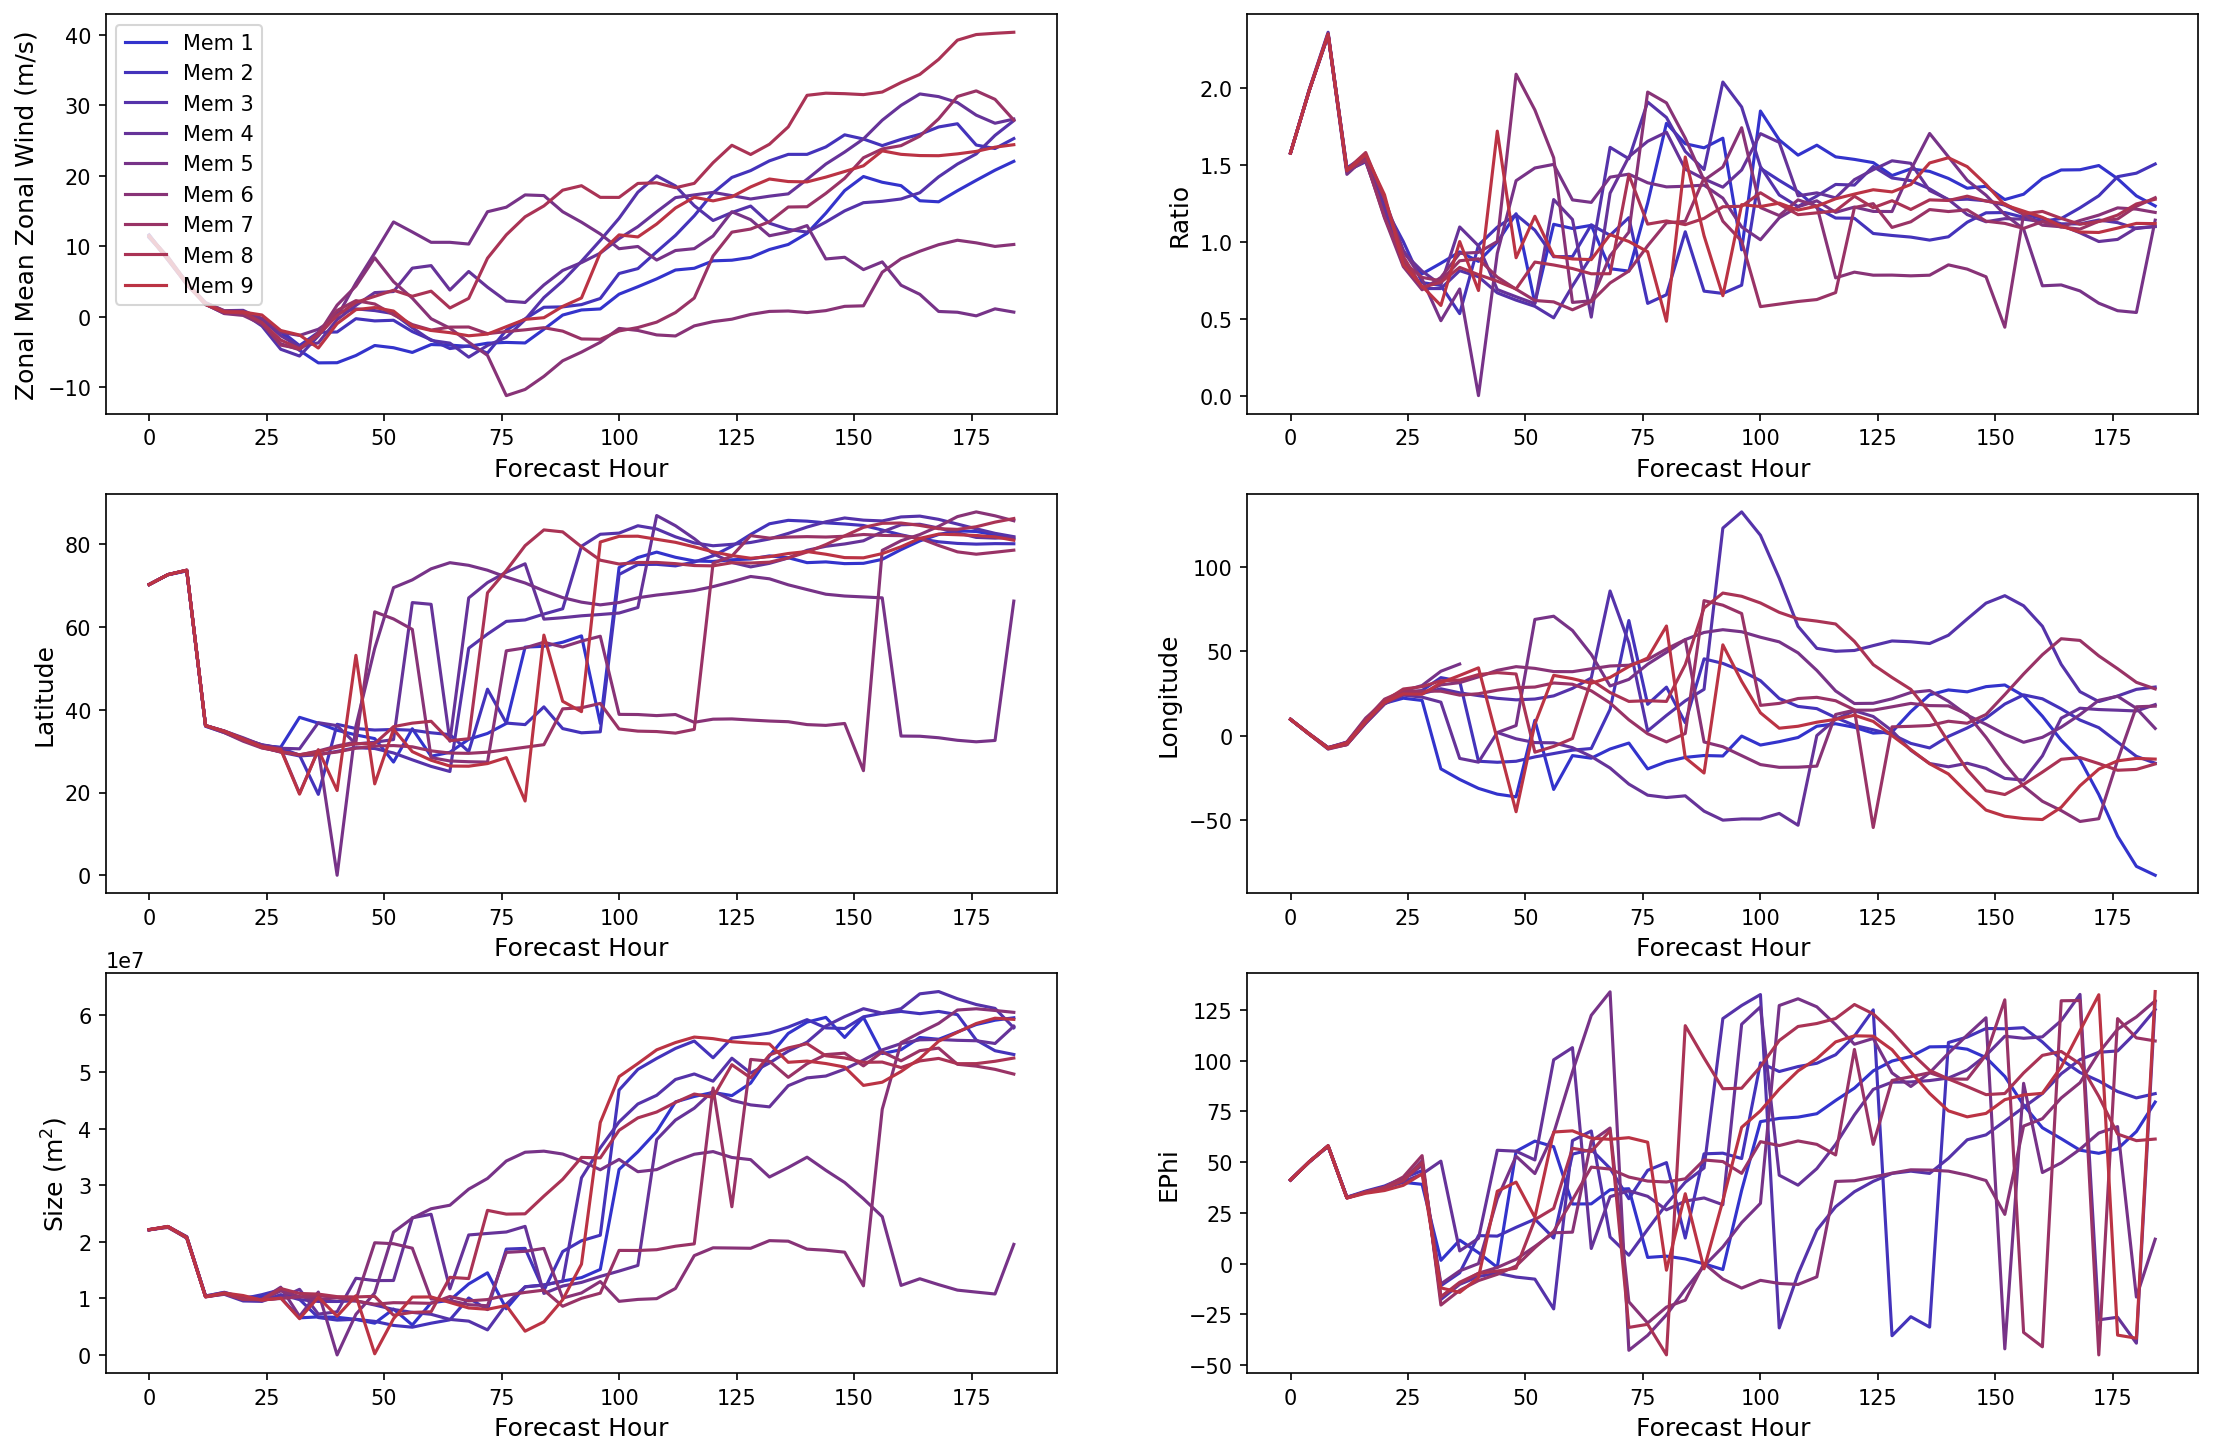

In [9]:
%matplotlib inline
##big plots
myLocator = mticker.MultipleLocator(5)

fig = plt.figure(figsize=(18,12),dpi=150)

#loop through each member
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)
ax6 = plt.subplot(3,2,6)

for m in range(1,10,1):
    #print(u_data_mem)
    # Specify how our lines should look
    colorR = (m+2)/ 15.
    ax1.plot(forecast_days, wind10[m,:], color=(colorR,.2,1-colorR,), label='Mem '+str(m))
    ax1.set_xlabel('Forecast Hour',fontsize = 12)
    ax1.set_ylabel('Zonal Mean Zonal Wind (m/s)',fontsize = 12)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.legend(loc='upper left',fontsize='medium');
    
    ax2.plot(forecast_days, rat10[m,:], color=(colorR,.2,1-colorR,), label='Mem '+str(m))
    ax2.set_xlabel('Forecast Hour', fontsize = 12)
    ax2.set_ylabel('Ratio', fontsize = 12)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    ax3.plot(forecast_days, cenlat10[m,:], color=(colorR,.2,1-colorR,), label='Mem '+str(m))
    ax3.set_xlabel('Forecast Hour', fontsize = 12)
    ax3.set_ylabel('Latitude', fontsize = 12)
    ax3.tick_params(axis='both', which='major', labelsize=10)
    
    ax4.plot(forecast_days, cenlon10[m,:], color=(colorR,.2,1-colorR,), label='Mem '+str(m))
    ax4.set_xlabel('Forecast Hour', fontsize = 12)
    ax4.set_ylabel('Longitude', fontsize = 12)
    ax4.tick_params(axis='both', which='major', labelsize=10)
    
    ax5.plot(forecast_days, size10[m,:], color=(colorR,.2,1-colorR,), label='Mem '+str(m))
    ax5.set_xlabel('Forecast Hour', fontsize = 12)
    ax5.set_ylabel('Size (m$^2$)', fontsize = 12)
    ax5.tick_params(axis='both', which='major', labelsize=10)
    
    ax6.plot(forecast_days, ep10[m,:], color=(colorR,.2,1-colorR,), label='Mem '+str(m))
    ax6.set_xlabel('Forecast Hour', fontsize = 12)
    ax6.set_ylabel('EPhi', fontsize = 12)
    ax6.tick_params(axis='both', which='major', labelsize=10)
    
plt.show()
